# Часть 3. Выбор и обучение модели

In [1]:
import pandas as pd
import numpy as np
import pickle                                                        #для сохранения модели
from sklearn.model_selection import train_test_split                 #для разбиения данных на выборки
from sklearn import metrics                                          #метрики
from sklearn.linear_model import LinearRegression                    #линейная регрессия
from sklearn.ensemble import RandomForestRegressor                   #случайный лес
from sklearn.ensemble import GradientBoostingRegressor               #градиентный бустинг
import xgboost
# визуальная составляющая
import matplotlib.pyplot as plt
%matplotlib inline

Проверим разные алгоритмы и сравним их показатели. Кроме того, посмотрим показатели на разных датасетах: полном и сокращенном

In [2]:
#зафиксируем параметры
RANDOM_SEED = 34
TEST_SIZE=0.2

#загружаем датасеты для обучения
data = pd.read_csv('data4ml_5.csv')  #датасет с удаленными колонками после feature-selector

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374333 entries, 0 to 374332
Data columns (total 44 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   7                    374333 non-null  float64
 1   mal_femal            324802 non-null  float64
 2   pool                 374333 non-null  int64  
 3   8                    374333 non-null  float64
 4   street_hash          374333 non-null  int64  
 5   min_dist             374333 non-null  float64
 6   zipcode_int          374333 non-null  int64  
 7   9                    374333 non-null  float64
 8   vacant_units         324802 non-null  float64
 9   12                   374333 non-null  float64
 10  Cooling              374333 non-null  int64  
 11  VACANT               374333 non-null  float64
 12  price                374333 non-null  int64  
 13  Remodeled            374333 non-null  int64  
 14  PK                   374333 non-null  float64
 15  beds_square      

In [4]:
#разделяем датасеты на данные и целевую переменную, отбрасывая при этом стоимость за кв. фут
columns = list(set(data.columns) - set(['target', 'price_sqft', 'price', 'price_lot']))
X = data[columns]
y = data['target']

## Метрики для оценивания результата

### MAPE - "Mean Absolute Percentage Error" - Средняя абсолютная процентная ошибка

коэффициент, не имеющий размерности, с очень простой интерпретацией. Его можно измерять в долях или процентах. Если у вас получилось, например, что MAPE=11.4%, то это говорит о том, что ошибка составила 11,4% от фактических значений. 

Коэффициент по разному относится к положительным и отрицательным ошибкам. этот коэффициент жестче относится к случаям завышенных прогнозов, чем заниженных. В случае с агрегированием прогнозов по разным значениям, это приводит к искажениям - прогнозист не получает достоверной информации о том, насколько его прогноз точен. 

### коэффициент SMAPE - "Symmetric MAPE"

Трактовка у коэффициента примерно такая же, как и у MAPE: какой процент составляет ошибка от этой самой величины.

Коэффициент должен бы быть симметричным, но таковым до конца не является. 

In [11]:
#функция для вычисления процента ошибки
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [12]:
def SMAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2*np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Вычислим стоимость без машинного обучения

Пример, если брать просто среднюю стоимость дома по всей выборке. Процент ошибки = 83%

In [305]:
new_price = data_2['target'].mean()
data_2['new_target'] = new_price
print('средняя стоимость дома по всей выборке', new_price)
print('MAE:', metrics.mean_absolute_error(data_2['target'], data_2['new_target']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(data_2['target'], data_2['new_target'])))
print('R2-score', metrics.r2_score(data_2['target'], data_2['new_target']))
print('MAPE', MAPE(data_2['target'], data_2['new_target']))
print('SMAPE', SMAPE(data_2['target'], data_2['new_target']))

средняя стоимость дома по всей выборке 644821.6591585415
MAE: 580567.0502524216
RMSE: 1842064.6815025436
R2-score 0.0
MAPE 7.951030727669823
SMAPE 0.8360365446875936


Пример, если брать среднюю стоимость по округу (по почтовому индексу). Ошибка уже 53%

In [291]:
by_column = 'zipcode_int' #'state_encoding' #'zipcode_int'
data_mean_price = data.groupby(by = by_column).mean()['target']
data_new = data.merge(data_mean_price, how = 'left', on = by_column)
#data_new['new_price'] = data_mean_price # data_new['price_y'] * data_new['sqft']

print('MAE:', metrics.mean_absolute_error(data_new['target_x'], data_new['target_y']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(data_new['target_x'], data_new['target_y'])))
print('R2-score:', metrics.r2_score(data_new['target_x'], data_new['target_y']))
print('MAPE:', MAPE(data_new['target_x'], data_new['target_y']))
print('SMAPE:', SMAPE(data_new['target_x'], data_new['target_y']))

MAE: 412702.06175783696
RMSE: 1604803.5220831006
R2-score: 0.24101361376439379
MAPE: 3.5322589863274425
SMAPE: 0.5383571056744821


In [306]:
data_mean_price

zipcode_int
0            1.052333e+07
1103         9.700000e+04
1104         1.412411e+05
1105         1.238595e+05
1106         8.028900e+04
                 ...     
277139677    2.850000e+05
277139782    2.750000e+05
277139791    4.490000e+05
770152522    1.399990e+05
770925540    1.300000e+05
Name: target, Length: 4488, dtype: float64

### Рассмотрим несколько алгоритмов и сравним результаты их работы

## Линейная регрессия

In [13]:
#разделяем датасет на тренировочную и валидационные части
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred_lin =  lin_reg.predict(X_test)
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика Mean Absolute Error (MAE) показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_lin))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin)))
print('R2-score', metrics.r2_score(y_test, y_pred_lin))
print('MAPE', MAPE(y_test, y_pred_lin))
print('SMAPE', SMAPE(y_test, y_pred_lin))

#как видим, в среднем ошибка очень большая, что совсем нас не устраивает

MAE: 525431.1139625249
RMSE: 1641590.8941003259
R2-score 0.22055332976011832
MAPE 3.4810424967684117
SMAPE 0.887908521022723


Процент ошибки велик. Даже больше, чем для простого округления. Кроме того, слишком велика абсолютная ошибка (МАЕ)

## Случайный лес

In [14]:
#разделяем датасет на тренировочную и валидационные части
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2-score', metrics.r2_score(y_test, y_pred))
print('MAPE', MAPE(y_test, y_pred))
print('SMAPE', SMAPE(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s


MAE: 212330.73524282407
RMSE: 1075783.6818455805
R2-score 0.6652609016523898
MAPE 0.8180780527991783
SMAPE 0.2727420304542382


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


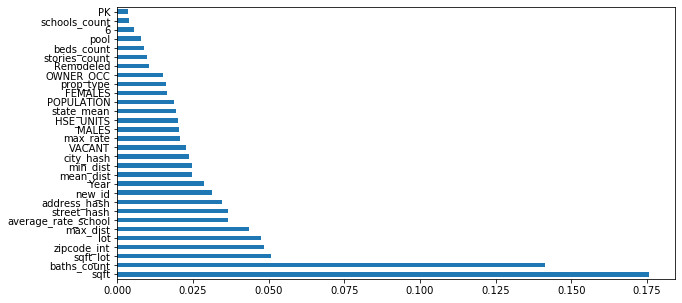

In [15]:
#посмотрим, какие колонки вносят больший вклад
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

## gradient boosting

Проведем процедуру подбора наилучших гиперпараметров перед непосредственно обучением модели

In [33]:
from sklearn.model_selection import GridSearchCV
#подбор гиперпараметров
parameters = {'n_estimators':[30, 50,100], 'learning_rate':[0.1], 'max_depth': [15,20],
             'min_samples_leaf': [2], 'random_state': [RANDOM_SEED]}

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)
gbrt_search = GradientBoostingRegressor()
search = GridSearchCV(gbrt_search, parameters, verbose =1)
search.fit(X_train,y_train)
best_param = search.best_estimator_
best_param


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 252.2min finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=34, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Обучение

In [366]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)
gbrt = GradientBoostingRegressor(max_depth=15, n_estimators=100, 
                                 min_samples_leaf = 2, learning_rate=0.1,random_state = RANDOM_SEED,
                                 verbose =0)
gbrt.fit(X_train,y_train)
y_pred_gbrt = gbrt.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_gbrt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbrt)))
print('R2-score', metrics.r2_score(y_test, y_pred_gbrt))
print('MAPE', MAPE(y_test, y_pred_gbrt))
print('SMAPE', SMAPE(y_test, y_pred_gbrt))

MAE: 223551.89919662432
RMSE: 1165293.9933987588
R2-score 0.6072397272092372
MAPE 0.935749838613261
SMAPE 0.31756624184134474


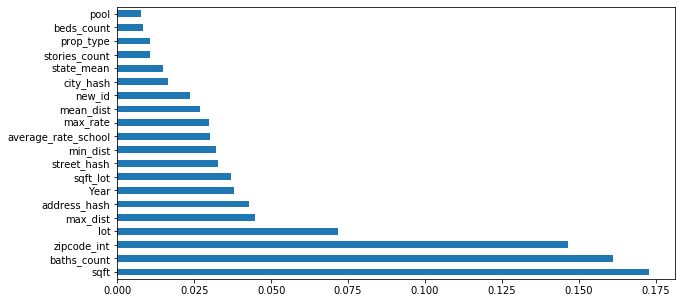

In [367]:
#посмотрим, какие колонки вносят больший вклад
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(gbrt.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Voting

In [35]:
from sklearn.ensemble import VotingRegressor

X_train, X_test, y_train, y_test = train_test_split(X_2,y_2, test_size=TEST_SIZE, random_state = RANDOM_SEED)

reg1 = GradientBoostingRegressor(max_depth=15, n_estimators=100, 
                                 min_samples_leaf = 2, learning_rate=0.1,random_state = RANDOM_SEED,
                                 verbose =0)
reg2 = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(X_train, y_train)

y_pred = ereg.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2-score', metrics.r2_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


MAE: 103573.50763276432
RMSE: 750516.1878318249
R2-score 0.8393842156795602


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


# XGBoost

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)

for i in ['gbtree', 'gblinear','dart']:
    xgb = xgboost.XGBRegressor(n_estimators = 100, max_depth = 20, learning_rate = 0.1, booster = i, random_state = RANDOM_SEED)
    xgb.fit(X_train,y_train)
    y_pred_xgb = xgb.predict(X_test)
    print(i)
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_xgb))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)))
    print('R2-score', metrics.r2_score(y_test, y_pred_xgb))
    print('MAPE', MAPE(y_test, y_pred_xgb))
    print('SMAPE', SMAPE(y_test, y_pred_xgb))
    print(' ============= ')
    

gbtree
MAE: 212122.3073335078
RMSE: 1158553.943132343
R2-score 0.6117700315548119
MAPE 0.8094093488604587
SMAPE 0.28185594705220585
[22:40:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


gblinear
MAE: 532910.6639006374
RMSE: 1693010.4380340567
R2-score 0.1709593823727652
MAPE 3.6236323476533805
SMAPE 0.8518893701306831
dart
MAE: 212179.006705499
RMSE: 1158558.8660637725
R2-score 0.6117667322115479
MAPE 0.8113899608042641
SMAPE 0.2821272460205321


# LightGBM

In [6]:
import lightgbm as lgb

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=TEST_SIZE, random_state = RANDOM_SEED)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

num_round = 1000
param = {'num_leaves': 31, 
         'objective': 'mae', 
         'max_depth': 30, 
         'min_data_in_leaf': 20,
         'bagging_fraction': 0.4,
         'tree_learner':'voting'}
param['metric'] = ['mape', 'rmse', 'mae']

for i in ['mape', 'rmse', 'mae']:
    param['objective'] = i
    bst = lgb.train(param, train_data, num_round, valid_sets=test_data)
    y_pred_bst = bst.predict(X_test)
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_bst))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_bst)))
    print('R2-score', metrics.r2_score(y_test, y_pred_bst))
    print('MAPE', MAPE(y_test, y_pred_bst))
    print('SMAPE', SMAPE(y_test, y_pred_bst))

[1]	valid_0's mape: 0.923979	valid_0's rmse: 1.96301e+06	valid_0's l1: 629527
[2]	valid_0's mape: 0.884295	valid_0's rmse: 1.95913e+06	valid_0's l1: 617557
[3]	valid_0's mape: 0.852839	valid_0's rmse: 1.95572e+06	valid_0's l1: 606926
[4]	valid_0's mape: 0.827634	valid_0's rmse: 1.95271e+06	valid_0's l1: 597503
[5]	valid_0's mape: 0.807423	valid_0's rmse: 1.95004e+06	valid_0's l1: 589159
[6]	valid_0's mape: 0.790927	valid_0's rmse: 1.94764e+06	valid_0's l1: 581675
[7]	valid_0's mape: 0.777619	valid_0's rmse: 1.94551e+06	valid_0's l1: 575055
[8]	valid_0's mape: 0.766973	valid_0's rmse: 1.94362e+06	valid_0's l1: 569204
[9]	valid_0's mape: 0.76378	valid_0's rmse: 1.94344e+06	valid_0's l1: 568675
[10]	valid_0's mape: 0.761269	valid_0's rmse: 1.94329e+06	valid_0's l1: 568201
[11]	valid_0's mape: 0.758202	valid_0's rmse: 1.94303e+06	valid_0's l1: 567400
[12]	valid_0's mape: 0.756858	valid_0's rmse: 1.94282e+06	valid_0's l1: 566751
[13]	valid_0's mape: 0.741725	valid_0's rmse: 1.94099e+06	vali

[106]	valid_0's mape: 0.65749	valid_0's rmse: 1.92663e+06	valid_0's l1: 517789
[107]	valid_0's mape: 0.657489	valid_0's rmse: 1.92663e+06	valid_0's l1: 517789
[108]	valid_0's mape: 0.657487	valid_0's rmse: 1.92663e+06	valid_0's l1: 517789
[109]	valid_0's mape: 0.657486	valid_0's rmse: 1.92663e+06	valid_0's l1: 517789
[110]	valid_0's mape: 0.657486	valid_0's rmse: 1.92663e+06	valid_0's l1: 517789
[111]	valid_0's mape: 0.652052	valid_0's rmse: 1.92581e+06	valid_0's l1: 515622
[112]	valid_0's mape: 0.651932	valid_0's rmse: 1.92581e+06	valid_0's l1: 515626
[113]	valid_0's mape: 0.651817	valid_0's rmse: 1.92582e+06	valid_0's l1: 515630
[114]	valid_0's mape: 0.651714	valid_0's rmse: 1.92582e+06	valid_0's l1: 515633
[115]	valid_0's mape: 0.65162	valid_0's rmse: 1.92582e+06	valid_0's l1: 515636
[116]	valid_0's mape: 0.651537	valid_0's rmse: 1.92582e+06	valid_0's l1: 515639
[117]	valid_0's mape: 0.651462	valid_0's rmse: 1.92582e+06	valid_0's l1: 515641
[118]	valid_0's mape: 0.651397	valid_0's r

[210]	valid_0's mape: 0.627536	valid_0's rmse: 1.92164e+06	valid_0's l1: 505200
[211]	valid_0's mape: 0.627452	valid_0's rmse: 1.92164e+06	valid_0's l1: 505203
[212]	valid_0's mape: 0.627385	valid_0's rmse: 1.92165e+06	valid_0's l1: 505207
[213]	valid_0's mape: 0.627321	valid_0's rmse: 1.92165e+06	valid_0's l1: 505210
[214]	valid_0's mape: 0.627268	valid_0's rmse: 1.92165e+06	valid_0's l1: 505212
[215]	valid_0's mape: 0.627222	valid_0's rmse: 1.92165e+06	valid_0's l1: 505215
[216]	valid_0's mape: 0.62717	valid_0's rmse: 1.92165e+06	valid_0's l1: 505217
[217]	valid_0's mape: 0.627125	valid_0's rmse: 1.92165e+06	valid_0's l1: 505219
[218]	valid_0's mape: 0.627097	valid_0's rmse: 1.92165e+06	valid_0's l1: 505221
[219]	valid_0's mape: 0.627074	valid_0's rmse: 1.92165e+06	valid_0's l1: 505222
[220]	valid_0's mape: 0.627048	valid_0's rmse: 1.92165e+06	valid_0's l1: 505224
[221]	valid_0's mape: 0.627032	valid_0's rmse: 1.92165e+06	valid_0's l1: 505225
[222]	valid_0's mape: 0.627008	valid_0's 

[314]	valid_0's mape: 0.612943	valid_0's rmse: 1.91948e+06	valid_0's l1: 500570
[315]	valid_0's mape: 0.612937	valid_0's rmse: 1.91948e+06	valid_0's l1: 500570
[316]	valid_0's mape: 0.612931	valid_0's rmse: 1.91948e+06	valid_0's l1: 500569
[317]	valid_0's mape: 0.61293	valid_0's rmse: 1.91948e+06	valid_0's l1: 500568
[318]	valid_0's mape: 0.612922	valid_0's rmse: 1.91948e+06	valid_0's l1: 500568
[319]	valid_0's mape: 0.612922	valid_0's rmse: 1.91947e+06	valid_0's l1: 500567
[320]	valid_0's mape: 0.61292	valid_0's rmse: 1.91947e+06	valid_0's l1: 500567
[321]	valid_0's mape: 0.611979	valid_0's rmse: 1.91932e+06	valid_0's l1: 500134
[322]	valid_0's mape: 0.611946	valid_0's rmse: 1.91932e+06	valid_0's l1: 500136
[323]	valid_0's mape: 0.611918	valid_0's rmse: 1.91932e+06	valid_0's l1: 500138
[324]	valid_0's mape: 0.611893	valid_0's rmse: 1.91932e+06	valid_0's l1: 500140
[325]	valid_0's mape: 0.61187	valid_0's rmse: 1.91932e+06	valid_0's l1: 500142
[326]	valid_0's mape: 0.61185	valid_0's rms

[417]	valid_0's mape: 0.602714	valid_0's rmse: 1.91761e+06	valid_0's l1: 496519
[418]	valid_0's mape: 0.602693	valid_0's rmse: 1.91761e+06	valid_0's l1: 496521
[419]	valid_0's mape: 0.602675	valid_0's rmse: 1.91761e+06	valid_0's l1: 496523
[420]	valid_0's mape: 0.60266	valid_0's rmse: 1.91761e+06	valid_0's l1: 496525
[421]	valid_0's mape: 0.602644	valid_0's rmse: 1.91761e+06	valid_0's l1: 496527
[422]	valid_0's mape: 0.602631	valid_0's rmse: 1.91761e+06	valid_0's l1: 496528
[423]	valid_0's mape: 0.602618	valid_0's rmse: 1.91761e+06	valid_0's l1: 496530
[424]	valid_0's mape: 0.602607	valid_0's rmse: 1.91761e+06	valid_0's l1: 496531
[425]	valid_0's mape: 0.602589	valid_0's rmse: 1.91761e+06	valid_0's l1: 496532
[426]	valid_0's mape: 0.60258	valid_0's rmse: 1.91761e+06	valid_0's l1: 496533
[427]	valid_0's mape: 0.602564	valid_0's rmse: 1.91761e+06	valid_0's l1: 496534
[428]	valid_0's mape: 0.60255	valid_0's rmse: 1.91761e+06	valid_0's l1: 496535
[429]	valid_0's mape: 0.602536	valid_0's rm

[520]	valid_0's mape: 0.600562	valid_0's rmse: 1.91719e+06	valid_0's l1: 495446
[521]	valid_0's mape: 0.600455	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[522]	valid_0's mape: 0.600453	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[523]	valid_0's mape: 0.600452	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[524]	valid_0's mape: 0.60045	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[525]	valid_0's mape: 0.600449	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[526]	valid_0's mape: 0.600448	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[527]	valid_0's mape: 0.600447	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[528]	valid_0's mape: 0.600446	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[529]	valid_0's mape: 0.600446	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[530]	valid_0's mape: 0.600445	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[531]	valid_0's mape: 0.600444	valid_0's rmse: 1.91718e+06	valid_0's l1: 495423
[532]	valid_0's mape: 0.600443	valid_0's 

[623]	valid_0's mape: 0.598532	valid_0's rmse: 1.91705e+06	valid_0's l1: 495162
[624]	valid_0's mape: 0.598531	valid_0's rmse: 1.91705e+06	valid_0's l1: 495162
[625]	valid_0's mape: 0.598531	valid_0's rmse: 1.91704e+06	valid_0's l1: 495157
[626]	valid_0's mape: 0.598531	valid_0's rmse: 1.91704e+06	valid_0's l1: 495153
[627]	valid_0's mape: 0.598531	valid_0's rmse: 1.91704e+06	valid_0's l1: 495150
[628]	valid_0's mape: 0.598531	valid_0's rmse: 1.91704e+06	valid_0's l1: 495146
[629]	valid_0's mape: 0.598529	valid_0's rmse: 1.91704e+06	valid_0's l1: 495143
[630]	valid_0's mape: 0.598507	valid_0's rmse: 1.91704e+06	valid_0's l1: 495142
[631]	valid_0's mape: 0.596917	valid_0's rmse: 1.91632e+06	valid_0's l1: 493665
[632]	valid_0's mape: 0.596866	valid_0's rmse: 1.91632e+06	valid_0's l1: 493665
[633]	valid_0's mape: 0.596822	valid_0's rmse: 1.91632e+06	valid_0's l1: 493665
[634]	valid_0's mape: 0.596781	valid_0's rmse: 1.91632e+06	valid_0's l1: 493665
[635]	valid_0's mape: 0.596745	valid_0's

[727]	valid_0's mape: 0.594601	valid_0's rmse: 1.91593e+06	valid_0's l1: 492648
[728]	valid_0's mape: 0.594579	valid_0's rmse: 1.91593e+06	valid_0's l1: 492648
[729]	valid_0's mape: 0.59456	valid_0's rmse: 1.91593e+06	valid_0's l1: 492647
[730]	valid_0's mape: 0.594541	valid_0's rmse: 1.91593e+06	valid_0's l1: 492647
[731]	valid_0's mape: 0.594528	valid_0's rmse: 1.91593e+06	valid_0's l1: 492647
[732]	valid_0's mape: 0.594517	valid_0's rmse: 1.91593e+06	valid_0's l1: 492647
[733]	valid_0's mape: 0.594507	valid_0's rmse: 1.91593e+06	valid_0's l1: 492647
[734]	valid_0's mape: 0.594499	valid_0's rmse: 1.91593e+06	valid_0's l1: 492647
[735]	valid_0's mape: 0.594491	valid_0's rmse: 1.91593e+06	valid_0's l1: 492647
[736]	valid_0's mape: 0.594484	valid_0's rmse: 1.91593e+06	valid_0's l1: 492647
[737]	valid_0's mape: 0.594478	valid_0's rmse: 1.91593e+06	valid_0's l1: 492647
[738]	valid_0's mape: 0.594472	valid_0's rmse: 1.91593e+06	valid_0's l1: 492647
[739]	valid_0's mape: 0.594466	valid_0's 

[831]	valid_0's mape: 0.593661	valid_0's rmse: 1.91585e+06	valid_0's l1: 492403
[832]	valid_0's mape: 0.59366	valid_0's rmse: 1.91585e+06	valid_0's l1: 492408
[833]	valid_0's mape: 0.59366	valid_0's rmse: 1.91585e+06	valid_0's l1: 492411
[834]	valid_0's mape: 0.593659	valid_0's rmse: 1.91585e+06	valid_0's l1: 492415
[835]	valid_0's mape: 0.593659	valid_0's rmse: 1.91585e+06	valid_0's l1: 492417
[836]	valid_0's mape: 0.593226	valid_0's rmse: 1.91588e+06	valid_0's l1: 492466
[837]	valid_0's mape: 0.593225	valid_0's rmse: 1.91588e+06	valid_0's l1: 492466
[838]	valid_0's mape: 0.593223	valid_0's rmse: 1.91588e+06	valid_0's l1: 492468
[839]	valid_0's mape: 0.593222	valid_0's rmse: 1.91588e+06	valid_0's l1: 492470
[840]	valid_0's mape: 0.592295	valid_0's rmse: 1.91547e+06	valid_0's l1: 491525
[841]	valid_0's mape: 0.59227	valid_0's rmse: 1.91547e+06	valid_0's l1: 491527
[842]	valid_0's mape: 0.592251	valid_0's rmse: 1.91547e+06	valid_0's l1: 491527
[843]	valid_0's mape: 0.592234	valid_0's rm

[934]	valid_0's mape: 0.588066	valid_0's rmse: 1.91479e+06	valid_0's l1: 490174
[935]	valid_0's mape: 0.588066	valid_0's rmse: 1.91479e+06	valid_0's l1: 490174
[936]	valid_0's mape: 0.588061	valid_0's rmse: 1.91479e+06	valid_0's l1: 490174
[937]	valid_0's mape: 0.588061	valid_0's rmse: 1.91479e+06	valid_0's l1: 490174
[938]	valid_0's mape: 0.58806	valid_0's rmse: 1.91479e+06	valid_0's l1: 490174
[939]	valid_0's mape: 0.588058	valid_0's rmse: 1.91479e+06	valid_0's l1: 490174
[940]	valid_0's mape: 0.588058	valid_0's rmse: 1.91479e+06	valid_0's l1: 490174
[941]	valid_0's mape: 0.588057	valid_0's rmse: 1.91479e+06	valid_0's l1: 490174
[942]	valid_0's mape: 0.588058	valid_0's rmse: 1.91479e+06	valid_0's l1: 490174
[943]	valid_0's mape: 0.588056	valid_0's rmse: 1.91479e+06	valid_0's l1: 490166
[944]	valid_0's mape: 0.587368	valid_0's rmse: 1.91441e+06	valid_0's l1: 489341
[945]	valid_0's mape: 0.587344	valid_0's rmse: 1.91441e+06	valid_0's l1: 489341
[946]	valid_0's mape: 0.587326	valid_0's 

[39]	valid_0's mape: 2.49723	valid_0's rmse: 1.17086e+06	valid_0's l1: 318935
[40]	valid_0's mape: 2.45257	valid_0's rmse: 1.16759e+06	valid_0's l1: 317595
[41]	valid_0's mape: 2.42726	valid_0's rmse: 1.16417e+06	valid_0's l1: 316524
[42]	valid_0's mape: 2.36725	valid_0's rmse: 1.16181e+06	valid_0's l1: 314809
[43]	valid_0's mape: 2.35022	valid_0's rmse: 1.15882e+06	valid_0's l1: 314029
[44]	valid_0's mape: 2.33185	valid_0's rmse: 1.15715e+06	valid_0's l1: 313255
[45]	valid_0's mape: 2.32418	valid_0's rmse: 1.15425e+06	valid_0's l1: 312645
[46]	valid_0's mape: 2.3116	valid_0's rmse: 1.15279e+06	valid_0's l1: 311813
[47]	valid_0's mape: 2.28941	valid_0's rmse: 1.15046e+06	valid_0's l1: 310565
[48]	valid_0's mape: 2.28133	valid_0's rmse: 1.14853e+06	valid_0's l1: 309843
[49]	valid_0's mape: 2.25451	valid_0's rmse: 1.14643e+06	valid_0's l1: 308945
[50]	valid_0's mape: 2.23229	valid_0's rmse: 1.14471e+06	valid_0's l1: 308568
[51]	valid_0's mape: 2.21269	valid_0's rmse: 1.14267e+06	valid_0'

[150]	valid_0's mape: 1.42628	valid_0's rmse: 1.07951e+06	valid_0's l1: 278296
[151]	valid_0's mape: 1.42564	valid_0's rmse: 1.07914e+06	valid_0's l1: 278075
[152]	valid_0's mape: 1.42462	valid_0's rmse: 1.07883e+06	valid_0's l1: 278000
[153]	valid_0's mape: 1.42125	valid_0's rmse: 1.07869e+06	valid_0's l1: 278011
[154]	valid_0's mape: 1.41867	valid_0's rmse: 1.07803e+06	valid_0's l1: 277955
[155]	valid_0's mape: 1.4162	valid_0's rmse: 1.0783e+06	valid_0's l1: 277785
[156]	valid_0's mape: 1.41449	valid_0's rmse: 1.07732e+06	valid_0's l1: 277738
[157]	valid_0's mape: 1.40913	valid_0's rmse: 1.07656e+06	valid_0's l1: 277591
[158]	valid_0's mape: 1.40073	valid_0's rmse: 1.07613e+06	valid_0's l1: 277489
[159]	valid_0's mape: 1.39539	valid_0's rmse: 1.07604e+06	valid_0's l1: 277463
[160]	valid_0's mape: 1.39301	valid_0's rmse: 1.0748e+06	valid_0's l1: 277157
[161]	valid_0's mape: 1.38931	valid_0's rmse: 1.07464e+06	valid_0's l1: 277071
[162]	valid_0's mape: 1.38598	valid_0's rmse: 1.07431e+

[256]	valid_0's mape: 1.29572	valid_0's rmse: 1.05307e+06	valid_0's l1: 267122
[257]	valid_0's mape: 1.29108	valid_0's rmse: 1.05288e+06	valid_0's l1: 267087
[258]	valid_0's mape: 1.29145	valid_0's rmse: 1.05241e+06	valid_0's l1: 267056
[259]	valid_0's mape: 1.2916	valid_0's rmse: 1.05243e+06	valid_0's l1: 267046
[260]	valid_0's mape: 1.29036	valid_0's rmse: 1.05224e+06	valid_0's l1: 266880
[261]	valid_0's mape: 1.28941	valid_0's rmse: 1.05204e+06	valid_0's l1: 266892
[262]	valid_0's mape: 1.28808	valid_0's rmse: 1.05193e+06	valid_0's l1: 266818
[263]	valid_0's mape: 1.28443	valid_0's rmse: 1.05107e+06	valid_0's l1: 266695
[264]	valid_0's mape: 1.28297	valid_0's rmse: 1.05093e+06	valid_0's l1: 266541
[265]	valid_0's mape: 1.28322	valid_0's rmse: 1.05103e+06	valid_0's l1: 266541
[266]	valid_0's mape: 1.28401	valid_0's rmse: 1.05133e+06	valid_0's l1: 266566
[267]	valid_0's mape: 1.28258	valid_0's rmse: 1.05157e+06	valid_0's l1: 266537
[268]	valid_0's mape: 1.28304	valid_0's rmse: 1.05134

[361]	valid_0's mape: 1.2115	valid_0's rmse: 1.03638e+06	valid_0's l1: 260633
[362]	valid_0's mape: 1.21204	valid_0's rmse: 1.0361e+06	valid_0's l1: 260605
[363]	valid_0's mape: 1.21159	valid_0's rmse: 1.03595e+06	valid_0's l1: 260555
[364]	valid_0's mape: 1.21188	valid_0's rmse: 1.0354e+06	valid_0's l1: 260502
[365]	valid_0's mape: 1.21174	valid_0's rmse: 1.03547e+06	valid_0's l1: 260516
[366]	valid_0's mape: 1.21093	valid_0's rmse: 1.03505e+06	valid_0's l1: 260475
[367]	valid_0's mape: 1.21155	valid_0's rmse: 1.0349e+06	valid_0's l1: 260419
[368]	valid_0's mape: 1.21111	valid_0's rmse: 1.03421e+06	valid_0's l1: 260411
[369]	valid_0's mape: 1.21034	valid_0's rmse: 1.03436e+06	valid_0's l1: 260415
[370]	valid_0's mape: 1.20973	valid_0's rmse: 1.03417e+06	valid_0's l1: 260348
[371]	valid_0's mape: 1.21008	valid_0's rmse: 1.0341e+06	valid_0's l1: 260296
[372]	valid_0's mape: 1.20943	valid_0's rmse: 1.03409e+06	valid_0's l1: 260262
[373]	valid_0's mape: 1.20905	valid_0's rmse: 1.03398e+06

[467]	valid_0's mape: 1.1744	valid_0's rmse: 1.02599e+06	valid_0's l1: 255870
[468]	valid_0's mape: 1.17472	valid_0's rmse: 1.02577e+06	valid_0's l1: 255781
[469]	valid_0's mape: 1.17497	valid_0's rmse: 1.02561e+06	valid_0's l1: 255749
[470]	valid_0's mape: 1.17456	valid_0's rmse: 1.02547e+06	valid_0's l1: 255716
[471]	valid_0's mape: 1.17302	valid_0's rmse: 1.02543e+06	valid_0's l1: 255580
[472]	valid_0's mape: 1.17271	valid_0's rmse: 1.02544e+06	valid_0's l1: 255559
[473]	valid_0's mape: 1.17188	valid_0's rmse: 1.02534e+06	valid_0's l1: 255475
[474]	valid_0's mape: 1.17162	valid_0's rmse: 1.02532e+06	valid_0's l1: 255463
[475]	valid_0's mape: 1.17167	valid_0's rmse: 1.0253e+06	valid_0's l1: 255433
[476]	valid_0's mape: 1.17175	valid_0's rmse: 1.02532e+06	valid_0's l1: 255427
[477]	valid_0's mape: 1.17154	valid_0's rmse: 1.02531e+06	valid_0's l1: 255437
[478]	valid_0's mape: 1.17306	valid_0's rmse: 1.02528e+06	valid_0's l1: 255447
[479]	valid_0's mape: 1.17297	valid_0's rmse: 1.02531e

[580]	valid_0's mape: 1.14483	valid_0's rmse: 1.01921e+06	valid_0's l1: 252513
[581]	valid_0's mape: 1.14543	valid_0's rmse: 1.01909e+06	valid_0's l1: 252431
[582]	valid_0's mape: 1.1454	valid_0's rmse: 1.01899e+06	valid_0's l1: 252376
[583]	valid_0's mape: 1.14454	valid_0's rmse: 1.01888e+06	valid_0's l1: 252310
[584]	valid_0's mape: 1.14414	valid_0's rmse: 1.01884e+06	valid_0's l1: 252266
[585]	valid_0's mape: 1.14452	valid_0's rmse: 1.01883e+06	valid_0's l1: 252292
[586]	valid_0's mape: 1.14514	valid_0's rmse: 1.01884e+06	valid_0's l1: 252336
[587]	valid_0's mape: 1.14578	valid_0's rmse: 1.01872e+06	valid_0's l1: 252314
[588]	valid_0's mape: 1.14522	valid_0's rmse: 1.0187e+06	valid_0's l1: 252176
[589]	valid_0's mape: 1.1451	valid_0's rmse: 1.01869e+06	valid_0's l1: 252182
[590]	valid_0's mape: 1.14527	valid_0's rmse: 1.01864e+06	valid_0's l1: 252190
[591]	valid_0's mape: 1.14548	valid_0's rmse: 1.01868e+06	valid_0's l1: 252202
[592]	valid_0's mape: 1.1456	valid_0's rmse: 1.01863e+0

[685]	valid_0's mape: 1.13377	valid_0's rmse: 1.0167e+06	valid_0's l1: 250473
[686]	valid_0's mape: 1.13349	valid_0's rmse: 1.01656e+06	valid_0's l1: 250373
[687]	valid_0's mape: 1.13373	valid_0's rmse: 1.01664e+06	valid_0's l1: 250346
[688]	valid_0's mape: 1.13348	valid_0's rmse: 1.01707e+06	valid_0's l1: 250355
[689]	valid_0's mape: 1.13233	valid_0's rmse: 1.01711e+06	valid_0's l1: 250347
[690]	valid_0's mape: 1.13244	valid_0's rmse: 1.01706e+06	valid_0's l1: 250347
[691]	valid_0's mape: 1.13261	valid_0's rmse: 1.01704e+06	valid_0's l1: 250347
[692]	valid_0's mape: 1.13121	valid_0's rmse: 1.01703e+06	valid_0's l1: 250334
[693]	valid_0's mape: 1.13132	valid_0's rmse: 1.01698e+06	valid_0's l1: 250288
[694]	valid_0's mape: 1.13125	valid_0's rmse: 1.01688e+06	valid_0's l1: 250233
[695]	valid_0's mape: 1.1309	valid_0's rmse: 1.01682e+06	valid_0's l1: 250186
[696]	valid_0's mape: 1.13145	valid_0's rmse: 1.01681e+06	valid_0's l1: 250152
[697]	valid_0's mape: 1.13101	valid_0's rmse: 1.01668e

[791]	valid_0's mape: 1.13164	valid_0's rmse: 1.01302e+06	valid_0's l1: 248660
[792]	valid_0's mape: 1.13202	valid_0's rmse: 1.01304e+06	valid_0's l1: 248682
[793]	valid_0's mape: 1.13204	valid_0's rmse: 1.01292e+06	valid_0's l1: 248661
[794]	valid_0's mape: 1.13183	valid_0's rmse: 1.01297e+06	valid_0's l1: 248649
[795]	valid_0's mape: 1.1321	valid_0's rmse: 1.01292e+06	valid_0's l1: 248629
[796]	valid_0's mape: 1.13186	valid_0's rmse: 1.01289e+06	valid_0's l1: 248603
[797]	valid_0's mape: 1.12953	valid_0's rmse: 1.0129e+06	valid_0's l1: 248593
[798]	valid_0's mape: 1.13305	valid_0's rmse: 1.01293e+06	valid_0's l1: 248577
[799]	valid_0's mape: 1.13335	valid_0's rmse: 1.01279e+06	valid_0's l1: 248590
[800]	valid_0's mape: 1.1333	valid_0's rmse: 1.01278e+06	valid_0's l1: 248540
[801]	valid_0's mape: 1.13324	valid_0's rmse: 1.01278e+06	valid_0's l1: 248535
[802]	valid_0's mape: 1.1338	valid_0's rmse: 1.0127e+06	valid_0's l1: 248512
[803]	valid_0's mape: 1.13394	valid_0's rmse: 1.01268e+06

[895]	valid_0's mape: 1.11512	valid_0's rmse: 1.01078e+06	valid_0's l1: 246922
[896]	valid_0's mape: 1.11522	valid_0's rmse: 1.01065e+06	valid_0's l1: 246909
[897]	valid_0's mape: 1.11516	valid_0's rmse: 1.01064e+06	valid_0's l1: 246903
[898]	valid_0's mape: 1.11529	valid_0's rmse: 1.01074e+06	valid_0's l1: 246898
[899]	valid_0's mape: 1.1153	valid_0's rmse: 1.01076e+06	valid_0's l1: 246896
[900]	valid_0's mape: 1.11513	valid_0's rmse: 1.0105e+06	valid_0's l1: 246897
[901]	valid_0's mape: 1.117	valid_0's rmse: 1.01051e+06	valid_0's l1: 246905
[902]	valid_0's mape: 1.11678	valid_0's rmse: 1.01038e+06	valid_0's l1: 246853
[903]	valid_0's mape: 1.11704	valid_0's rmse: 1.01027e+06	valid_0's l1: 246830
[904]	valid_0's mape: 1.11706	valid_0's rmse: 1.0104e+06	valid_0's l1: 246853
[905]	valid_0's mape: 1.11737	valid_0's rmse: 1.01042e+06	valid_0's l1: 246859
[906]	valid_0's mape: 1.11746	valid_0's rmse: 1.01037e+06	valid_0's l1: 246850
[907]	valid_0's mape: 1.11701	valid_0's rmse: 1.01033e+06

MAE: 245899.3215856925
RMSE: 1009504.8832065111
R2-score 0.7052367166756873
MAPE 1.1115509731486048
SMAPE 0.3988785949451424
[1]	valid_0's mape: 2.92006	valid_0's rmse: 1.87937e+06	valid_0's l1: 458122
[2]	valid_0's mape: 2.7925	valid_0's rmse: 1.86772e+06	valid_0's l1: 443681
[3]	valid_0's mape: 2.67417	valid_0's rmse: 1.8601e+06	valid_0's l1: 432081
[4]	valid_0's mape: 2.57256	valid_0's rmse: 1.85204e+06	valid_0's l1: 421694
[5]	valid_0's mape: 2.46936	valid_0's rmse: 1.84491e+06	valid_0's l1: 412421
[6]	valid_0's mape: 2.37418	valid_0's rmse: 1.83863e+06	valid_0's l1: 404410
[7]	valid_0's mape: 2.27328	valid_0's rmse: 1.83036e+06	valid_0's l1: 396521
[8]	valid_0's mape: 2.17445	valid_0's rmse: 1.82459e+06	valid_0's l1: 390346
[9]	valid_0's mape: 2.09215	valid_0's rmse: 1.81816e+06	valid_0's l1: 383956
[10]	valid_0's mape: 1.99457	valid_0's rmse: 1.81197e+06	valid_0's l1: 378073
[11]	valid_0's mape: 1.90849	valid_0's rmse: 1.80401e+06	valid_0's l1: 372576
[12]	valid_0's mape: 1.84028

[104]	valid_0's mape: 0.678744	valid_0's rmse: 1.51815e+06	valid_0's l1: 272341
[105]	valid_0's mape: 0.675912	valid_0's rmse: 1.51713e+06	valid_0's l1: 272093
[106]	valid_0's mape: 0.675107	valid_0's rmse: 1.51697e+06	valid_0's l1: 271971
[107]	valid_0's mape: 0.673301	valid_0's rmse: 1.51496e+06	valid_0's l1: 271572
[108]	valid_0's mape: 0.671023	valid_0's rmse: 1.51485e+06	valid_0's l1: 271389
[109]	valid_0's mape: 0.670223	valid_0's rmse: 1.5138e+06	valid_0's l1: 270982
[110]	valid_0's mape: 0.669484	valid_0's rmse: 1.5137e+06	valid_0's l1: 270854
[111]	valid_0's mape: 0.668538	valid_0's rmse: 1.51232e+06	valid_0's l1: 270471
[112]	valid_0's mape: 0.667845	valid_0's rmse: 1.50919e+06	valid_0's l1: 269971
[113]	valid_0's mape: 0.666695	valid_0's rmse: 1.50836e+06	valid_0's l1: 269638
[114]	valid_0's mape: 0.666137	valid_0's rmse: 1.50793e+06	valid_0's l1: 269376
[115]	valid_0's mape: 0.664082	valid_0's rmse: 1.50738e+06	valid_0's l1: 269153
[116]	valid_0's mape: 0.662864	valid_0's r

[209]	valid_0's mape: 0.606953	valid_0's rmse: 1.40775e+06	valid_0's l1: 251332
[210]	valid_0's mape: 0.606785	valid_0's rmse: 1.40256e+06	valid_0's l1: 250987
[211]	valid_0's mape: 0.606377	valid_0's rmse: 1.40012e+06	valid_0's l1: 250793
[212]	valid_0's mape: 0.606188	valid_0's rmse: 1.39618e+06	valid_0's l1: 250590
[213]	valid_0's mape: 0.606024	valid_0's rmse: 1.39613e+06	valid_0's l1: 250553
[214]	valid_0's mape: 0.604414	valid_0's rmse: 1.39602e+06	valid_0's l1: 250510
[215]	valid_0's mape: 0.604215	valid_0's rmse: 1.39342e+06	valid_0's l1: 250352
[216]	valid_0's mape: 0.604181	valid_0's rmse: 1.39153e+06	valid_0's l1: 250108
[217]	valid_0's mape: 0.603561	valid_0's rmse: 1.3914e+06	valid_0's l1: 250056
[218]	valid_0's mape: 0.603183	valid_0's rmse: 1.39138e+06	valid_0's l1: 250007
[219]	valid_0's mape: 0.602829	valid_0's rmse: 1.39133e+06	valid_0's l1: 249935
[220]	valid_0's mape: 0.602533	valid_0's rmse: 1.39112e+06	valid_0's l1: 249839
[221]	valid_0's mape: 0.602065	valid_0's 

[313]	valid_0's mape: 0.57644	valid_0's rmse: 1.34611e+06	valid_0's l1: 241835
[314]	valid_0's mape: 0.576415	valid_0's rmse: 1.34567e+06	valid_0's l1: 241773
[315]	valid_0's mape: 0.576343	valid_0's rmse: 1.34564e+06	valid_0's l1: 241728
[316]	valid_0's mape: 0.576108	valid_0's rmse: 1.34561e+06	valid_0's l1: 241670
[317]	valid_0's mape: 0.576166	valid_0's rmse: 1.34559e+06	valid_0's l1: 241640
[318]	valid_0's mape: 0.575877	valid_0's rmse: 1.34556e+06	valid_0's l1: 241558
[319]	valid_0's mape: 0.575484	valid_0's rmse: 1.34555e+06	valid_0's l1: 241504
[320]	valid_0's mape: 0.575456	valid_0's rmse: 1.3449e+06	valid_0's l1: 241446
[321]	valid_0's mape: 0.575466	valid_0's rmse: 1.34454e+06	valid_0's l1: 241332
[322]	valid_0's mape: 0.575246	valid_0's rmse: 1.34423e+06	valid_0's l1: 241215
[323]	valid_0's mape: 0.574853	valid_0's rmse: 1.34419e+06	valid_0's l1: 241143
[324]	valid_0's mape: 0.574709	valid_0's rmse: 1.34404e+06	valid_0's l1: 241075
[325]	valid_0's mape: 0.574675	valid_0's r

[418]	valid_0's mape: 0.560381	valid_0's rmse: 1.32247e+06	valid_0's l1: 236306
[419]	valid_0's mape: 0.560251	valid_0's rmse: 1.32175e+06	valid_0's l1: 236207
[420]	valid_0's mape: 0.560219	valid_0's rmse: 1.32165e+06	valid_0's l1: 236186
[421]	valid_0's mape: 0.560146	valid_0's rmse: 1.32141e+06	valid_0's l1: 236103
[422]	valid_0's mape: 0.560078	valid_0's rmse: 1.32143e+06	valid_0's l1: 236062
[423]	valid_0's mape: 0.559975	valid_0's rmse: 1.32134e+06	valid_0's l1: 236014
[424]	valid_0's mape: 0.559886	valid_0's rmse: 1.32132e+06	valid_0's l1: 235982
[425]	valid_0's mape: 0.559609	valid_0's rmse: 1.3213e+06	valid_0's l1: 235952
[426]	valid_0's mape: 0.559524	valid_0's rmse: 1.32129e+06	valid_0's l1: 235928
[427]	valid_0's mape: 0.55891	valid_0's rmse: 1.32127e+06	valid_0's l1: 235897
[428]	valid_0's mape: 0.558806	valid_0's rmse: 1.32126e+06	valid_0's l1: 235890
[429]	valid_0's mape: 0.558779	valid_0's rmse: 1.32113e+06	valid_0's l1: 235843
[430]	valid_0's mape: 0.558402	valid_0's r

[525]	valid_0's mape: 0.550887	valid_0's rmse: 1.31482e+06	valid_0's l1: 233212
[526]	valid_0's mape: 0.550868	valid_0's rmse: 1.31483e+06	valid_0's l1: 233212
[527]	valid_0's mape: 0.550782	valid_0's rmse: 1.31478e+06	valid_0's l1: 233166
[528]	valid_0's mape: 0.550688	valid_0's rmse: 1.31478e+06	valid_0's l1: 233162
[529]	valid_0's mape: 0.550683	valid_0's rmse: 1.31457e+06	valid_0's l1: 233075
[530]	valid_0's mape: 0.550626	valid_0's rmse: 1.31455e+06	valid_0's l1: 233040
[531]	valid_0's mape: 0.550484	valid_0's rmse: 1.31455e+06	valid_0's l1: 233024
[532]	valid_0's mape: 0.550239	valid_0's rmse: 1.31445e+06	valid_0's l1: 232956
[533]	valid_0's mape: 0.5502	valid_0's rmse: 1.3138e+06	valid_0's l1: 232873
[534]	valid_0's mape: 0.550144	valid_0's rmse: 1.31376e+06	valid_0's l1: 232852
[535]	valid_0's mape: 0.550052	valid_0's rmse: 1.3137e+06	valid_0's l1: 232808
[536]	valid_0's mape: 0.549823	valid_0's rmse: 1.31369e+06	valid_0's l1: 232774
[537]	valid_0's mape: 0.549771	valid_0's rms

[630]	valid_0's mape: 0.545824	valid_0's rmse: 1.30369e+06	valid_0's l1: 229813
[631]	valid_0's mape: 0.545811	valid_0's rmse: 1.30369e+06	valid_0's l1: 229810
[632]	valid_0's mape: 0.545788	valid_0's rmse: 1.30369e+06	valid_0's l1: 229804
[633]	valid_0's mape: 0.545767	valid_0's rmse: 1.30369e+06	valid_0's l1: 229793
[634]	valid_0's mape: 0.545756	valid_0's rmse: 1.30369e+06	valid_0's l1: 229791
[635]	valid_0's mape: 0.54574	valid_0's rmse: 1.30369e+06	valid_0's l1: 229788
[636]	valid_0's mape: 0.545613	valid_0's rmse: 1.30364e+06	valid_0's l1: 229760
[637]	valid_0's mape: 0.545584	valid_0's rmse: 1.30362e+06	valid_0's l1: 229733
[638]	valid_0's mape: 0.545482	valid_0's rmse: 1.30361e+06	valid_0's l1: 229716
[639]	valid_0's mape: 0.545496	valid_0's rmse: 1.29945e+06	valid_0's l1: 229659
[640]	valid_0's mape: 0.545459	valid_0's rmse: 1.29942e+06	valid_0's l1: 229642
[641]	valid_0's mape: 0.545433	valid_0's rmse: 1.29942e+06	valid_0's l1: 229637
[642]	valid_0's mape: 0.545425	valid_0's 

[738]	valid_0's mape: 0.539336	valid_0's rmse: 1.28428e+06	valid_0's l1: 227192
[739]	valid_0's mape: 0.539203	valid_0's rmse: 1.28427e+06	valid_0's l1: 227173
[740]	valid_0's mape: 0.539186	valid_0's rmse: 1.2842e+06	valid_0's l1: 227119
[741]	valid_0's mape: 0.539131	valid_0's rmse: 1.2842e+06	valid_0's l1: 227114
[742]	valid_0's mape: 0.539206	valid_0's rmse: 1.28418e+06	valid_0's l1: 227092
[743]	valid_0's mape: 0.539082	valid_0's rmse: 1.28419e+06	valid_0's l1: 227080
[744]	valid_0's mape: 0.539058	valid_0's rmse: 1.28419e+06	valid_0's l1: 227068
[745]	valid_0's mape: 0.539008	valid_0's rmse: 1.28418e+06	valid_0's l1: 227039
[746]	valid_0's mape: 0.539006	valid_0's rmse: 1.28417e+06	valid_0's l1: 227027
[747]	valid_0's mape: 0.538955	valid_0's rmse: 1.28416e+06	valid_0's l1: 227000
[748]	valid_0's mape: 0.538976	valid_0's rmse: 1.28416e+06	valid_0's l1: 226993
[749]	valid_0's mape: 0.538882	valid_0's rmse: 1.28409e+06	valid_0's l1: 226947
[750]	valid_0's mape: 0.538818	valid_0's r

[842]	valid_0's mape: 0.535021	valid_0's rmse: 1.28113e+06	valid_0's l1: 225722
[843]	valid_0's mape: 0.535081	valid_0's rmse: 1.28112e+06	valid_0's l1: 225721
[844]	valid_0's mape: 0.535075	valid_0's rmse: 1.28113e+06	valid_0's l1: 225721
[845]	valid_0's mape: 0.53501	valid_0's rmse: 1.28112e+06	valid_0's l1: 225705
[846]	valid_0's mape: 0.534668	valid_0's rmse: 1.2811e+06	valid_0's l1: 225687
[847]	valid_0's mape: 0.534589	valid_0's rmse: 1.2811e+06	valid_0's l1: 225676
[848]	valid_0's mape: 0.534615	valid_0's rmse: 1.28109e+06	valid_0's l1: 225672
[849]	valid_0's mape: 0.534455	valid_0's rmse: 1.28106e+06	valid_0's l1: 225642
[850]	valid_0's mape: 0.534434	valid_0's rmse: 1.28106e+06	valid_0's l1: 225632
[851]	valid_0's mape: 0.534427	valid_0's rmse: 1.28106e+06	valid_0's l1: 225628
[852]	valid_0's mape: 0.534463	valid_0's rmse: 1.28105e+06	valid_0's l1: 225621
[853]	valid_0's mape: 0.534485	valid_0's rmse: 1.28104e+06	valid_0's l1: 225611
[854]	valid_0's mape: 0.534511	valid_0's rm

[945]	valid_0's mape: 0.529658	valid_0's rmse: 1.25842e+06	valid_0's l1: 223056
[946]	valid_0's mape: 0.529625	valid_0's rmse: 1.25842e+06	valid_0's l1: 223045
[947]	valid_0's mape: 0.529579	valid_0's rmse: 1.25841e+06	valid_0's l1: 223033
[948]	valid_0's mape: 0.529536	valid_0's rmse: 1.25841e+06	valid_0's l1: 223023
[949]	valid_0's mape: 0.529506	valid_0's rmse: 1.25839e+06	valid_0's l1: 223009
[950]	valid_0's mape: 0.529509	valid_0's rmse: 1.2584e+06	valid_0's l1: 223003
[951]	valid_0's mape: 0.529503	valid_0's rmse: 1.25837e+06	valid_0's l1: 222987
[952]	valid_0's mape: 0.529483	valid_0's rmse: 1.25837e+06	valid_0's l1: 222981
[953]	valid_0's mape: 0.529517	valid_0's rmse: 1.25837e+06	valid_0's l1: 222981
[954]	valid_0's mape: 0.529493	valid_0's rmse: 1.25836e+06	valid_0's l1: 222969
[955]	valid_0's mape: 0.529486	valid_0's rmse: 1.25834e+06	valid_0's l1: 222953
[956]	valid_0's mape: 0.529425	valid_0's rmse: 1.25834e+06	valid_0's l1: 222945
[957]	valid_0's mape: 0.529284	valid_0's 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=TEST_SIZE, random_state = RANDOM_SEED)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

num_round = 10000
param = {'num_leaves': 100, 
         'objective': 'mape', 
         'max_depth': 30, 
         #'min_data_in_leaf': 20,
         'bagging_fraction': 0.8,
         'learning_rate': 0.1,
         'boosting': 'dart',
         'tree_learner':'voting'}
param['metric'] = ['mape', 'rmse', 'mae']

for i in ['mae']:
    param['objective'] = i
    bst = lgb.train(param, train_data, num_round, valid_sets=test_data)
    y_pred_bst = bst.predict(X_test)
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_bst))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_bst)))
    print('R2-score', metrics.r2_score(y_test, y_pred_bst))
    print('MAPE', MAPE(y_test, y_pred_bst))
    print('SMAPE', SMAPE(y_test, y_pred_bst))

[1]	valid_0's mape: 4.28616	valid_0's rmse: 1.708e+06	valid_0's l1: 445116
[2]	valid_0's mape: 4.1497	valid_0's rmse: 1.69496e+06	valid_0's l1: 428646
[3]	valid_0's mape: 3.99075	valid_0's rmse: 1.68411e+06	valid_0's l1: 414341
[4]	valid_0's mape: 3.85204	valid_0's rmse: 1.67019e+06	valid_0's l1: 400793
[5]	valid_0's mape: 3.74274	valid_0's rmse: 1.66055e+06	valid_0's l1: 389752
[6]	valid_0's mape: 3.61851	valid_0's rmse: 1.64975e+06	valid_0's l1: 379273
[7]	valid_0's mape: 3.49207	valid_0's rmse: 1.64045e+06	valid_0's l1: 370343
[8]	valid_0's mape: 3.53407	valid_0's rmse: 1.64453e+06	valid_0's l1: 374169
[9]	valid_0's mape: 3.43765	valid_0's rmse: 1.63282e+06	valid_0's l1: 364984
[10]	valid_0's mape: 3.3324	valid_0's rmse: 1.62334e+06	valid_0's l1: 357337
[11]	valid_0's mape: 3.22241	valid_0's rmse: 1.61405e+06	valid_0's l1: 349698
[12]	valid_0's mape: 3.25623	valid_0's rmse: 1.61676e+06	valid_0's l1: 352318
[13]	valid_0's mape: 3.1629	valid_0's rmse: 1.60835e+06	valid_0's l1: 345546


[107]	valid_0's mape: 1.81488	valid_0's rmse: 1.47518e+06	valid_0's l1: 295101
[108]	valid_0's mape: 1.82315	valid_0's rmse: 1.47194e+06	valid_0's l1: 291880
[109]	valid_0's mape: 1.81864	valid_0's rmse: 1.47412e+06	valid_0's l1: 292899
[110]	valid_0's mape: 1.81004	valid_0's rmse: 1.47653e+06	valid_0's l1: 294069
[111]	valid_0's mape: 1.84607	valid_0's rmse: 1.46319e+06	valid_0's l1: 289905
[112]	valid_0's mape: 1.85444	valid_0's rmse: 1.4567e+06	valid_0's l1: 286380
[113]	valid_0's mape: 1.98402	valid_0's rmse: 1.45209e+06	valid_0's l1: 283538
[114]	valid_0's mape: 1.99223	valid_0's rmse: 1.44728e+06	valid_0's l1: 280970
[115]	valid_0's mape: 2.00533	valid_0's rmse: 1.44188e+06	valid_0's l1: 278325
[116]	valid_0's mape: 2.01265	valid_0's rmse: 1.4354e+06	valid_0's l1: 275892
[117]	valid_0's mape: 2.0049	valid_0's rmse: 1.43719e+06	valid_0's l1: 276753
[118]	valid_0's mape: 2.01278	valid_0's rmse: 1.43455e+06	valid_0's l1: 274847
[119]	valid_0's mape: 2.00744	valid_0's rmse: 1.43695e+

[214]	valid_0's mape: 2.00955	valid_0's rmse: 1.36582e+06	valid_0's l1: 254438
[215]	valid_0's mape: 2.01252	valid_0's rmse: 1.36374e+06	valid_0's l1: 253380
[216]	valid_0's mape: 2.00945	valid_0's rmse: 1.36597e+06	valid_0's l1: 254091
[217]	valid_0's mape: 2.01096	valid_0's rmse: 1.36421e+06	valid_0's l1: 253069
[218]	valid_0's mape: 2.08868	valid_0's rmse: 1.36009e+06	valid_0's l1: 251986
[219]	valid_0's mape: 2.05432	valid_0's rmse: 1.36221e+06	valid_0's l1: 253089
[220]	valid_0's mape: 2.05884	valid_0's rmse: 1.3606e+06	valid_0's l1: 252276
[221]	valid_0's mape: 2.04932	valid_0's rmse: 1.3625e+06	valid_0's l1: 252896
[222]	valid_0's mape: 2.06576	valid_0's rmse: 1.36149e+06	valid_0's l1: 252062
[223]	valid_0's mape: 2.06812	valid_0's rmse: 1.35985e+06	valid_0's l1: 251269
[224]	valid_0's mape: 2.0628	valid_0's rmse: 1.362e+06	valid_0's l1: 251953
[225]	valid_0's mape: 2.05355	valid_0's rmse: 1.36444e+06	valid_0's l1: 252720
[226]	valid_0's mape: 2.04254	valid_0's rmse: 1.36653e+06

[318]	valid_0's mape: 2.18598	valid_0's rmse: 1.31001e+06	valid_0's l1: 237422
[319]	valid_0's mape: 2.17794	valid_0's rmse: 1.31132e+06	valid_0's l1: 237819
[320]	valid_0's mape: 2.19568	valid_0's rmse: 1.30913e+06	valid_0's l1: 237248
[321]	valid_0's mape: 2.19163	valid_0's rmse: 1.31064e+06	valid_0's l1: 237643
[322]	valid_0's mape: 2.19391	valid_0's rmse: 1.30758e+06	valid_0's l1: 237006
[323]	valid_0's mape: 2.19642	valid_0's rmse: 1.30676e+06	valid_0's l1: 236631
[324]	valid_0's mape: 2.19021	valid_0's rmse: 1.30831e+06	valid_0's l1: 237046
[325]	valid_0's mape: 2.19181	valid_0's rmse: 1.30668e+06	valid_0's l1: 236537
[326]	valid_0's mape: 2.18645	valid_0's rmse: 1.30827e+06	valid_0's l1: 236946
[327]	valid_0's mape: 2.18852	valid_0's rmse: 1.30643e+06	valid_0's l1: 236425
[328]	valid_0's mape: 2.18455	valid_0's rmse: 1.30786e+06	valid_0's l1: 236799
[329]	valid_0's mape: 2.1897	valid_0's rmse: 1.30631e+06	valid_0's l1: 236332
[330]	valid_0's mape: 2.18157	valid_0's rmse: 1.30774

[424]	valid_0's mape: 2.22214	valid_0's rmse: 1.25e+06	valid_0's l1: 225284
[425]	valid_0's mape: 2.21664	valid_0's rmse: 1.25125e+06	valid_0's l1: 225541
[426]	valid_0's mape: 2.21472	valid_0's rmse: 1.2505e+06	valid_0's l1: 225256
[427]	valid_0's mape: 2.21476	valid_0's rmse: 1.24811e+06	valid_0's l1: 224814
[428]	valid_0's mape: 2.21168	valid_0's rmse: 1.24952e+06	valid_0's l1: 225079
[429]	valid_0's mape: 2.21477	valid_0's rmse: 1.24506e+06	valid_0's l1: 224682
[430]	valid_0's mape: 2.19819	valid_0's rmse: 1.24626e+06	valid_0's l1: 224998
[431]	valid_0's mape: 2.20009	valid_0's rmse: 1.24491e+06	valid_0's l1: 224748
[432]	valid_0's mape: 2.20378	valid_0's rmse: 1.24261e+06	valid_0's l1: 224404
[433]	valid_0's mape: 2.20531	valid_0's rmse: 1.24224e+06	valid_0's l1: 224253
[434]	valid_0's mape: 2.2033	valid_0's rmse: 1.24328e+06	valid_0's l1: 224481
[435]	valid_0's mape: 2.1987	valid_0's rmse: 1.24448e+06	valid_0's l1: 224727
[436]	valid_0's mape: 2.19949	valid_0's rmse: 1.24418e+06	

[531]	valid_0's mape: 2.25323	valid_0's rmse: 1.23037e+06	valid_0's l1: 220012
[532]	valid_0's mape: 2.25399	valid_0's rmse: 1.23005e+06	valid_0's l1: 219829
[533]	valid_0's mape: 2.25238	valid_0's rmse: 1.2311e+06	valid_0's l1: 220036
[534]	valid_0's mape: 2.25359	valid_0's rmse: 1.22997e+06	valid_0's l1: 219860
[535]	valid_0's mape: 2.25659	valid_0's rmse: 1.22971e+06	valid_0's l1: 219673
[536]	valid_0's mape: 2.25117	valid_0's rmse: 1.23056e+06	valid_0's l1: 219839
[537]	valid_0's mape: 2.25259	valid_0's rmse: 1.23026e+06	valid_0's l1: 219655
[538]	valid_0's mape: 2.25325	valid_0's rmse: 1.22969e+06	valid_0's l1: 219491
[539]	valid_0's mape: 2.24866	valid_0's rmse: 1.23064e+06	valid_0's l1: 219686
[540]	valid_0's mape: 2.24339	valid_0's rmse: 1.23159e+06	valid_0's l1: 219883
[541]	valid_0's mape: 2.2398	valid_0's rmse: 1.23265e+06	valid_0's l1: 220101
[542]	valid_0's mape: 2.23806	valid_0's rmse: 1.23133e+06	valid_0's l1: 219826
[543]	valid_0's mape: 2.23264	valid_0's rmse: 1.23212e

[637]	valid_0's mape: 2.18382	valid_0's rmse: 1.22909e+06	valid_0's l1: 217841
[638]	valid_0's mape: 2.18147	valid_0's rmse: 1.22978e+06	valid_0's l1: 217999
[639]	valid_0's mape: 2.17885	valid_0's rmse: 1.23066e+06	valid_0's l1: 218177
[640]	valid_0's mape: 2.18166	valid_0's rmse: 1.22886e+06	valid_0's l1: 217972
[641]	valid_0's mape: 2.17978	valid_0's rmse: 1.2296e+06	valid_0's l1: 218135
[642]	valid_0's mape: 2.17737	valid_0's rmse: 1.23028e+06	valid_0's l1: 218290
[643]	valid_0's mape: 2.17908	valid_0's rmse: 1.22988e+06	valid_0's l1: 218138
[644]	valid_0's mape: 2.17644	valid_0's rmse: 1.23065e+06	valid_0's l1: 218299
[645]	valid_0's mape: 2.20222	valid_0's rmse: 1.22911e+06	valid_0's l1: 218065
[646]	valid_0's mape: 2.2024	valid_0's rmse: 1.22653e+06	valid_0's l1: 217769
[647]	valid_0's mape: 2.20388	valid_0's rmse: 1.22581e+06	valid_0's l1: 217552
[648]	valid_0's mape: 2.21304	valid_0's rmse: 1.22457e+06	valid_0's l1: 217316
[649]	valid_0's mape: 2.19965	valid_0's rmse: 1.22553e

[745]	valid_0's mape: 2.28001	valid_0's rmse: 1.21434e+06	valid_0's l1: 215370
[746]	valid_0's mape: 2.26842	valid_0's rmse: 1.21505e+06	valid_0's l1: 215570
[747]	valid_0's mape: 2.26963	valid_0's rmse: 1.21289e+06	valid_0's l1: 215379
[748]	valid_0's mape: 2.27294	valid_0's rmse: 1.21202e+06	valid_0's l1: 215169
[749]	valid_0's mape: 2.26998	valid_0's rmse: 1.21268e+06	valid_0's l1: 215307
[750]	valid_0's mape: 2.27135	valid_0's rmse: 1.21247e+06	valid_0's l1: 215224
[751]	valid_0's mape: 2.26838	valid_0's rmse: 1.20963e+06	valid_0's l1: 214821
[752]	valid_0's mape: 2.26595	valid_0's rmse: 1.21035e+06	valid_0's l1: 214963
[753]	valid_0's mape: 2.26974	valid_0's rmse: 1.20978e+06	valid_0's l1: 214756
[754]	valid_0's mape: 2.26623	valid_0's rmse: 1.21066e+06	valid_0's l1: 214918
[755]	valid_0's mape: 2.267	valid_0's rmse: 1.20865e+06	valid_0's l1: 214709
[756]	valid_0's mape: 2.26421	valid_0's rmse: 1.20929e+06	valid_0's l1: 214850
[757]	valid_0's mape: 2.26208	valid_0's rmse: 1.20992e

[851]	valid_0's mape: 2.44966	valid_0's rmse: 1.19603e+06	valid_0's l1: 212420
[852]	valid_0's mape: 2.45033	valid_0's rmse: 1.1949e+06	valid_0's l1: 212228
[853]	valid_0's mape: 2.45046	valid_0's rmse: 1.19466e+06	valid_0's l1: 212106
[854]	valid_0's mape: 2.44571	valid_0's rmse: 1.1953e+06	valid_0's l1: 212215
[855]	valid_0's mape: 2.44598	valid_0's rmse: 1.19469e+06	valid_0's l1: 212099
[856]	valid_0's mape: 2.44628	valid_0's rmse: 1.19405e+06	valid_0's l1: 211935
[857]	valid_0's mape: 2.44404	valid_0's rmse: 1.19463e+06	valid_0's l1: 212043
[858]	valid_0's mape: 2.44249	valid_0's rmse: 1.19521e+06	valid_0's l1: 212152
[859]	valid_0's mape: 2.43958	valid_0's rmse: 1.19577e+06	valid_0's l1: 212272
[860]	valid_0's mape: 2.44097	valid_0's rmse: 1.19554e+06	valid_0's l1: 212190
[861]	valid_0's mape: 2.44227	valid_0's rmse: 1.19541e+06	valid_0's l1: 212131
[862]	valid_0's mape: 2.44283	valid_0's rmse: 1.19486e+06	valid_0's l1: 211998
[863]	valid_0's mape: 2.44097	valid_0's rmse: 1.19536e

[958]	valid_0's mape: 2.38293	valid_0's rmse: 1.18731e+06	valid_0's l1: 210850
[959]	valid_0's mape: 2.38579	valid_0's rmse: 1.18632e+06	valid_0's l1: 210666
[960]	valid_0's mape: 2.38674	valid_0's rmse: 1.18585e+06	valid_0's l1: 210492
[961]	valid_0's mape: 2.38744	valid_0's rmse: 1.18561e+06	valid_0's l1: 210360
[962]	valid_0's mape: 2.38985	valid_0's rmse: 1.18402e+06	valid_0's l1: 210129
[963]	valid_0's mape: 2.39084	valid_0's rmse: 1.18115e+06	valid_0's l1: 209719
[964]	valid_0's mape: 2.38934	valid_0's rmse: 1.18162e+06	valid_0's l1: 209810
[965]	valid_0's mape: 2.38988	valid_0's rmse: 1.18017e+06	valid_0's l1: 209561
[966]	valid_0's mape: 2.38905	valid_0's rmse: 1.1807e+06	valid_0's l1: 209662
[967]	valid_0's mape: 2.3857	valid_0's rmse: 1.18119e+06	valid_0's l1: 209767
[968]	valid_0's mape: 2.38434	valid_0's rmse: 1.18175e+06	valid_0's l1: 209870
[969]	valid_0's mape: 2.38274	valid_0's rmse: 1.18226e+06	valid_0's l1: 209977
[970]	valid_0's mape: 2.38308	valid_0's rmse: 1.182e+0

[1062]	valid_0's mape: 2.37406	valid_0's rmse: 1.17588e+06	valid_0's l1: 209022
[1063]	valid_0's mape: 2.37738	valid_0's rmse: 1.17575e+06	valid_0's l1: 208942
[1064]	valid_0's mape: 2.37602	valid_0's rmse: 1.17616e+06	valid_0's l1: 209040
[1065]	valid_0's mape: 2.37436	valid_0's rmse: 1.1766e+06	valid_0's l1: 209135
[1066]	valid_0's mape: 2.37639	valid_0's rmse: 1.17628e+06	valid_0's l1: 209037
[1067]	valid_0's mape: 2.37521	valid_0's rmse: 1.17664e+06	valid_0's l1: 209129
[1068]	valid_0's mape: 2.37522	valid_0's rmse: 1.17613e+06	valid_0's l1: 209015
[1069]	valid_0's mape: 2.37466	valid_0's rmse: 1.17665e+06	valid_0's l1: 209123
[1070]	valid_0's mape: 2.37602	valid_0's rmse: 1.17653e+06	valid_0's l1: 209047
[1071]	valid_0's mape: 2.37777	valid_0's rmse: 1.17639e+06	valid_0's l1: 208975
[1072]	valid_0's mape: 2.37589	valid_0's rmse: 1.17696e+06	valid_0's l1: 209088
[1073]	valid_0's mape: 2.37734	valid_0's rmse: 1.17669e+06	valid_0's l1: 208994
[1074]	valid_0's mape: 2.37582	valid_0's 

[1165]	valid_0's mape: 2.46533	valid_0's rmse: 1.17821e+06	valid_0's l1: 208529
[1166]	valid_0's mape: 2.46568	valid_0's rmse: 1.17783e+06	valid_0's l1: 208397
[1167]	valid_0's mape: 2.46632	valid_0's rmse: 1.17689e+06	valid_0's l1: 208218
[1168]	valid_0's mape: 2.45736	valid_0's rmse: 1.1774e+06	valid_0's l1: 208343
[1169]	valid_0's mape: 2.45542	valid_0's rmse: 1.17798e+06	valid_0's l1: 208446
[1170]	valid_0's mape: 2.45367	valid_0's rmse: 1.17853e+06	valid_0's l1: 208549
[1171]	valid_0's mape: 2.45504	valid_0's rmse: 1.1775e+06	valid_0's l1: 208398
[1172]	valid_0's mape: 2.45231	valid_0's rmse: 1.17807e+06	valid_0's l1: 208501
[1173]	valid_0's mape: 2.45327	valid_0's rmse: 1.17794e+06	valid_0's l1: 208401
[1174]	valid_0's mape: 2.45051	valid_0's rmse: 1.17844e+06	valid_0's l1: 208498
[1175]	valid_0's mape: 2.45013	valid_0's rmse: 1.1788e+06	valid_0's l1: 208585
[1176]	valid_0's mape: 2.45116	valid_0's rmse: 1.17799e+06	valid_0's l1: 208469
[1177]	valid_0's mape: 2.44368	valid_0's rm

[1268]	valid_0's mape: 2.44523	valid_0's rmse: 1.17069e+06	valid_0's l1: 206520
[1269]	valid_0's mape: 2.44243	valid_0's rmse: 1.17118e+06	valid_0's l1: 206610
[1270]	valid_0's mape: 2.44248	valid_0's rmse: 1.16828e+06	valid_0's l1: 206383
[1271]	valid_0's mape: 2.44242	valid_0's rmse: 1.16304e+06	valid_0's l1: 206065
[1272]	valid_0's mape: 2.44057	valid_0's rmse: 1.16348e+06	valid_0's l1: 206144
[1273]	valid_0's mape: 2.43882	valid_0's rmse: 1.16384e+06	valid_0's l1: 206211
[1274]	valid_0's mape: 2.43758	valid_0's rmse: 1.16425e+06	valid_0's l1: 206288
[1275]	valid_0's mape: 2.4391	valid_0's rmse: 1.1641e+06	valid_0's l1: 206217
[1276]	valid_0's mape: 2.43704	valid_0's rmse: 1.16452e+06	valid_0's l1: 206299
[1277]	valid_0's mape: 2.43545	valid_0's rmse: 1.16489e+06	valid_0's l1: 206378
[1278]	valid_0's mape: 2.43557	valid_0's rmse: 1.16427e+06	valid_0's l1: 206222
[1279]	valid_0's mape: 2.43434	valid_0's rmse: 1.16458e+06	valid_0's l1: 206294
[1280]	valid_0's mape: 2.4328	valid_0's rm

[1371]	valid_0's mape: 2.71116	valid_0's rmse: 1.15432e+06	valid_0's l1: 204172
[1372]	valid_0's mape: 2.7144	valid_0's rmse: 1.15304e+06	valid_0's l1: 204054
[1373]	valid_0's mape: 2.72554	valid_0's rmse: 1.1524e+06	valid_0's l1: 203909
[1374]	valid_0's mape: 2.71976	valid_0's rmse: 1.15279e+06	valid_0's l1: 203975
[1375]	valid_0's mape: 2.72897	valid_0's rmse: 1.15265e+06	valid_0's l1: 203918
[1376]	valid_0's mape: 2.72103	valid_0's rmse: 1.15308e+06	valid_0's l1: 204009
[1377]	valid_0's mape: 2.72036	valid_0's rmse: 1.15352e+06	valid_0's l1: 204086
[1378]	valid_0's mape: 2.71961	valid_0's rmse: 1.15395e+06	valid_0's l1: 204160
[1379]	valid_0's mape: 2.71992	valid_0's rmse: 1.15388e+06	valid_0's l1: 204113
[1380]	valid_0's mape: 2.72002	valid_0's rmse: 1.1538e+06	valid_0's l1: 204068
[1381]	valid_0's mape: 2.72064	valid_0's rmse: 1.15269e+06	valid_0's l1: 204002
[1382]	valid_0's mape: 2.71937	valid_0's rmse: 1.15311e+06	valid_0's l1: 204073
[1383]	valid_0's mape: 2.71768	valid_0's rm

[1474]	valid_0's mape: 2.65849	valid_0's rmse: 1.15639e+06	valid_0's l1: 204129
[1475]	valid_0's mape: 2.65754	valid_0's rmse: 1.15677e+06	valid_0's l1: 204199
[1476]	valid_0's mape: 2.65668	valid_0's rmse: 1.1571e+06	valid_0's l1: 204269
[1477]	valid_0's mape: 2.65702	valid_0's rmse: 1.15656e+06	valid_0's l1: 204204
[1478]	valid_0's mape: 2.65766	valid_0's rmse: 1.15451e+06	valid_0's l1: 204049
[1479]	valid_0's mape: 2.65574	valid_0's rmse: 1.1549e+06	valid_0's l1: 204125
[1480]	valid_0's mape: 2.65621	valid_0's rmse: 1.15319e+06	valid_0's l1: 204048
[1481]	valid_0's mape: 2.65605	valid_0's rmse: 1.15283e+06	valid_0's l1: 203944
[1482]	valid_0's mape: 2.65632	valid_0's rmse: 1.15201e+06	valid_0's l1: 203798
[1483]	valid_0's mape: 2.66045	valid_0's rmse: 1.15165e+06	valid_0's l1: 203704
[1484]	valid_0's mape: 2.66109	valid_0's rmse: 1.15127e+06	valid_0's l1: 203599
[1485]	valid_0's mape: 2.66019	valid_0's rmse: 1.15164e+06	valid_0's l1: 203665
[1486]	valid_0's mape: 2.6593	valid_0's rm

[1577]	valid_0's mape: 2.64184	valid_0's rmse: 1.14693e+06	valid_0's l1: 202534
[1578]	valid_0's mape: 2.64182	valid_0's rmse: 1.14481e+06	valid_0's l1: 202362
[1579]	valid_0's mape: 2.64075	valid_0's rmse: 1.14506e+06	valid_0's l1: 202405
[1580]	valid_0's mape: 2.63973	valid_0's rmse: 1.14539e+06	valid_0's l1: 202459
[1581]	valid_0's mape: 2.64836	valid_0's rmse: 1.14521e+06	valid_0's l1: 202406
[1582]	valid_0's mape: 2.64858	valid_0's rmse: 1.1449e+06	valid_0's l1: 202348
[1583]	valid_0's mape: 2.64723	valid_0's rmse: 1.1452e+06	valid_0's l1: 202397
[1584]	valid_0's mape: 2.64719	valid_0's rmse: 1.14503e+06	valid_0's l1: 202324
[1585]	valid_0's mape: 2.64723	valid_0's rmse: 1.14366e+06	valid_0's l1: 202241
[1586]	valid_0's mape: 2.64724	valid_0's rmse: 1.14337e+06	valid_0's l1: 202160
[1587]	valid_0's mape: 2.64357	valid_0's rmse: 1.1437e+06	valid_0's l1: 202213
[1588]	valid_0's mape: 2.64243	valid_0's rmse: 1.14398e+06	valid_0's l1: 202268
[1589]	valid_0's mape: 2.64239	valid_0's rm

[1682]	valid_0's mape: 2.7272	valid_0's rmse: 1.13682e+06	valid_0's l1: 201473
[1683]	valid_0's mape: 2.72661	valid_0's rmse: 1.13721e+06	valid_0's l1: 201536
[1684]	valid_0's mape: 2.72594	valid_0's rmse: 1.13747e+06	valid_0's l1: 201582
[1685]	valid_0's mape: 2.72634	valid_0's rmse: 1.1369e+06	valid_0's l1: 201506
[1686]	valid_0's mape: 2.72589	valid_0's rmse: 1.13633e+06	valid_0's l1: 201387
[1687]	valid_0's mape: 2.72604	valid_0's rmse: 1.13575e+06	valid_0's l1: 201303
[1688]	valid_0's mape: 2.7242	valid_0's rmse: 1.13609e+06	valid_0's l1: 201363
[1689]	valid_0's mape: 2.72439	valid_0's rmse: 1.13323e+06	valid_0's l1: 201182
[1690]	valid_0's mape: 2.72453	valid_0's rmse: 1.13228e+06	valid_0's l1: 201079
[1691]	valid_0's mape: 2.72554	valid_0's rmse: 1.13214e+06	valid_0's l1: 201016
[1692]	valid_0's mape: 2.7253	valid_0's rmse: 1.1324e+06	valid_0's l1: 201060
[1693]	valid_0's mape: 2.72619	valid_0's rmse: 1.13185e+06	valid_0's l1: 200926
[1694]	valid_0's mape: 2.728	valid_0's rmse: 

[1785]	valid_0's mape: 2.68763	valid_0's rmse: 1.12529e+06	valid_0's l1: 200032
[1786]	valid_0's mape: 2.68611	valid_0's rmse: 1.12556e+06	valid_0's l1: 200084
[1787]	valid_0's mape: 2.68786	valid_0's rmse: 1.12543e+06	valid_0's l1: 200040
[1788]	valid_0's mape: 2.68817	valid_0's rmse: 1.12509e+06	valid_0's l1: 199956
[1789]	valid_0's mape: 2.68741	valid_0's rmse: 1.12543e+06	valid_0's l1: 200018
[1790]	valid_0's mape: 2.68802	valid_0's rmse: 1.12523e+06	valid_0's l1: 199953
[1791]	valid_0's mape: 2.68635	valid_0's rmse: 1.12551e+06	valid_0's l1: 200008
[1792]	valid_0's mape: 2.6868	valid_0's rmse: 1.12517e+06	valid_0's l1: 199905
[1793]	valid_0's mape: 2.68537	valid_0's rmse: 1.12555e+06	valid_0's l1: 199964
[1794]	valid_0's mape: 2.68475	valid_0's rmse: 1.12597e+06	valid_0's l1: 200027
[1795]	valid_0's mape: 2.68617	valid_0's rmse: 1.1258e+06	valid_0's l1: 199931
[1796]	valid_0's mape: 2.6855	valid_0's rmse: 1.12605e+06	valid_0's l1: 199973
[1797]	valid_0's mape: 2.6797	valid_0's rms

[1889]	valid_0's mape: 2.69088	valid_0's rmse: 1.11662e+06	valid_0's l1: 199313
[1890]	valid_0's mape: 2.6902	valid_0's rmse: 1.117e+06	valid_0's l1: 199372
[1891]	valid_0's mape: 2.69645	valid_0's rmse: 1.11691e+06	valid_0's l1: 199327
[1892]	valid_0's mape: 2.69659	valid_0's rmse: 1.11673e+06	valid_0's l1: 199252
[1893]	valid_0's mape: 2.69648	valid_0's rmse: 1.11624e+06	valid_0's l1: 199180
[1894]	valid_0's mape: 2.6972	valid_0's rmse: 1.1158e+06	valid_0's l1: 199083
[1895]	valid_0's mape: 2.69749	valid_0's rmse: 1.11573e+06	valid_0's l1: 199054
[1896]	valid_0's mape: 2.69781	valid_0's rmse: 1.11541e+06	valid_0's l1: 199006
[1897]	valid_0's mape: 2.69864	valid_0's rmse: 1.11535e+06	valid_0's l1: 198963
[1898]	valid_0's mape: 2.69867	valid_0's rmse: 1.11506e+06	valid_0's l1: 198893
[1899]	valid_0's mape: 2.69829	valid_0's rmse: 1.11542e+06	valid_0's l1: 198947
[1900]	valid_0's mape: 2.69708	valid_0's rmse: 1.11576e+06	valid_0's l1: 198999
[1901]	valid_0's mape: 2.69638	valid_0's rmse

[1993]	valid_0's mape: 2.67187	valid_0's rmse: 1.11832e+06	valid_0's l1: 198954
[1994]	valid_0's mape: 2.67243	valid_0's rmse: 1.11802e+06	valid_0's l1: 198882
[1995]	valid_0's mape: 2.67317	valid_0's rmse: 1.11787e+06	valid_0's l1: 198843
[1996]	valid_0's mape: 2.6669	valid_0's rmse: 1.11816e+06	valid_0's l1: 198917
[1997]	valid_0's mape: 2.66622	valid_0's rmse: 1.11846e+06	valid_0's l1: 198963
[1998]	valid_0's mape: 2.66693	valid_0's rmse: 1.11789e+06	valid_0's l1: 198872
[1999]	valid_0's mape: 2.66564	valid_0's rmse: 1.11735e+06	valid_0's l1: 198797
[2000]	valid_0's mape: 2.66664	valid_0's rmse: 1.11689e+06	valid_0's l1: 198711
[2001]	valid_0's mape: 2.66603	valid_0's rmse: 1.1172e+06	valid_0's l1: 198763
[2002]	valid_0's mape: 2.66507	valid_0's rmse: 1.11743e+06	valid_0's l1: 198809
[2003]	valid_0's mape: 2.66374	valid_0's rmse: 1.11771e+06	valid_0's l1: 198859
[2004]	valid_0's mape: 2.66434	valid_0's rmse: 1.11752e+06	valid_0's l1: 198781
[2005]	valid_0's mape: 2.66348	valid_0's r

[2099]	valid_0's mape: 2.70408	valid_0's rmse: 1.11244e+06	valid_0's l1: 197465
[2100]	valid_0's mape: 2.70424	valid_0's rmse: 1.11215e+06	valid_0's l1: 197392
[2101]	valid_0's mape: 2.70298	valid_0's rmse: 1.11236e+06	valid_0's l1: 197426
[2102]	valid_0's mape: 2.70348	valid_0's rmse: 1.11198e+06	valid_0's l1: 197409
[2103]	valid_0's mape: 2.70232	valid_0's rmse: 1.11223e+06	valid_0's l1: 197447
[2104]	valid_0's mape: 2.70204	valid_0's rmse: 1.11249e+06	valid_0's l1: 197490
[2105]	valid_0's mape: 2.70192	valid_0's rmse: 1.11247e+06	valid_0's l1: 197468
[2106]	valid_0's mape: 2.70219	valid_0's rmse: 1.11151e+06	valid_0's l1: 197412
[2107]	valid_0's mape: 2.70171	valid_0's rmse: 1.11174e+06	valid_0's l1: 197448
[2108]	valid_0's mape: 2.69942	valid_0's rmse: 1.11198e+06	valid_0's l1: 197487
[2109]	valid_0's mape: 2.69815	valid_0's rmse: 1.11223e+06	valid_0's l1: 197533
[2110]	valid_0's mape: 2.69723	valid_0's rmse: 1.11248e+06	valid_0's l1: 197576
[2111]	valid_0's mape: 2.69494	valid_0's

[2202]	valid_0's mape: 2.67081	valid_0's rmse: 1.11183e+06	valid_0's l1: 196901
[2203]	valid_0's mape: 2.66936	valid_0's rmse: 1.11199e+06	valid_0's l1: 196933
[2204]	valid_0's mape: 2.66841	valid_0's rmse: 1.11217e+06	valid_0's l1: 196966
[2205]	valid_0's mape: 2.66777	valid_0's rmse: 1.11238e+06	valid_0's l1: 197001
[2206]	valid_0's mape: 2.66817	valid_0's rmse: 1.11219e+06	valid_0's l1: 196967
[2207]	valid_0's mape: 2.66639	valid_0's rmse: 1.1125e+06	valid_0's l1: 197011
[2208]	valid_0's mape: 2.66574	valid_0's rmse: 1.11271e+06	valid_0's l1: 197052
[2209]	valid_0's mape: 2.66609	valid_0's rmse: 1.11267e+06	valid_0's l1: 197026
[2210]	valid_0's mape: 2.66341	valid_0's rmse: 1.11285e+06	valid_0's l1: 197061
[2211]	valid_0's mape: 2.66421	valid_0's rmse: 1.11263e+06	valid_0's l1: 197010
[2212]	valid_0's mape: 2.66441	valid_0's rmse: 1.11252e+06	valid_0's l1: 196957
[2213]	valid_0's mape: 2.66347	valid_0's rmse: 1.11274e+06	valid_0's l1: 196994
[2214]	valid_0's mape: 2.66286	valid_0's 

[2307]	valid_0's mape: 2.64634	valid_0's rmse: 1.10732e+06	valid_0's l1: 195822
[2308]	valid_0's mape: 2.64536	valid_0's rmse: 1.1075e+06	valid_0's l1: 195856
[2309]	valid_0's mape: 2.64257	valid_0's rmse: 1.10779e+06	valid_0's l1: 195902
[2310]	valid_0's mape: 2.64147	valid_0's rmse: 1.10797e+06	valid_0's l1: 195933
[2311]	valid_0's mape: 2.64228	valid_0's rmse: 1.10784e+06	valid_0's l1: 195889
[2312]	valid_0's mape: 2.63986	valid_0's rmse: 1.10818e+06	valid_0's l1: 195943
[2313]	valid_0's mape: 2.63818	valid_0's rmse: 1.10839e+06	valid_0's l1: 195982
[2314]	valid_0's mape: 2.63784	valid_0's rmse: 1.10868e+06	valid_0's l1: 196028
[2315]	valid_0's mape: 2.63773	valid_0's rmse: 1.1086e+06	valid_0's l1: 195995
[2316]	valid_0's mape: 2.63777	valid_0's rmse: 1.10858e+06	valid_0's l1: 195985
[2317]	valid_0's mape: 2.63798	valid_0's rmse: 1.10852e+06	valid_0's l1: 195952
[2318]	valid_0's mape: 2.63818	valid_0's rmse: 1.10825e+06	valid_0's l1: 195906
[2319]	valid_0's mape: 2.63761	valid_0's r

[2411]	valid_0's mape: 2.7421	valid_0's rmse: 1.10438e+06	valid_0's l1: 195263
[2412]	valid_0's mape: 2.74167	valid_0's rmse: 1.10456e+06	valid_0's l1: 195293
[2413]	valid_0's mape: 2.74105	valid_0's rmse: 1.10479e+06	valid_0's l1: 195332
[2414]	valid_0's mape: 2.74159	valid_0's rmse: 1.10477e+06	valid_0's l1: 195315
[2415]	valid_0's mape: 2.7422	valid_0's rmse: 1.10473e+06	valid_0's l1: 195280
[2416]	valid_0's mape: 2.74281	valid_0's rmse: 1.10462e+06	valid_0's l1: 195246
[2417]	valid_0's mape: 2.74154	valid_0's rmse: 1.10484e+06	valid_0's l1: 195284
[2418]	valid_0's mape: 2.7424	valid_0's rmse: 1.10451e+06	valid_0's l1: 195222
[2419]	valid_0's mape: 2.74261	valid_0's rmse: 1.10433e+06	valid_0's l1: 195156
[2420]	valid_0's mape: 2.74188	valid_0's rmse: 1.10452e+06	valid_0's l1: 195190
[2421]	valid_0's mape: 2.74217	valid_0's rmse: 1.10429e+06	valid_0's l1: 195133
[2422]	valid_0's mape: 2.73619	valid_0's rmse: 1.10449e+06	valid_0's l1: 195185
[2423]	valid_0's mape: 2.73331	valid_0's rm

[2514]	valid_0's mape: 2.71104	valid_0's rmse: 1.10382e+06	valid_0's l1: 194870
[2515]	valid_0's mape: 2.71124	valid_0's rmse: 1.10361e+06	valid_0's l1: 194839
[2516]	valid_0's mape: 2.75722	valid_0's rmse: 1.10339e+06	valid_0's l1: 194785
[2517]	valid_0's mape: 2.75728	valid_0's rmse: 1.10318e+06	valid_0's l1: 194725
[2518]	valid_0's mape: 2.75557	valid_0's rmse: 1.10346e+06	valid_0's l1: 194774
[2519]	valid_0's mape: 2.75401	valid_0's rmse: 1.10365e+06	valid_0's l1: 194808
[2520]	valid_0's mape: 2.75945	valid_0's rmse: 1.10391e+06	valid_0's l1: 194846
[2521]	valid_0's mape: 2.75957	valid_0's rmse: 1.10379e+06	valid_0's l1: 194819
[2522]	valid_0's mape: 2.75916	valid_0's rmse: 1.10397e+06	valid_0's l1: 194848
[2523]	valid_0's mape: 2.75929	valid_0's rmse: 1.10393e+06	valid_0's l1: 194832
[2524]	valid_0's mape: 2.75916	valid_0's rmse: 1.10342e+06	valid_0's l1: 194717
[2525]	valid_0's mape: 2.76366	valid_0's rmse: 1.10329e+06	valid_0's l1: 194692
[2526]	valid_0's mape: 2.75878	valid_0's

[2617]	valid_0's mape: 2.74876	valid_0's rmse: 1.10683e+06	valid_0's l1: 194982
[2618]	valid_0's mape: 2.74897	valid_0's rmse: 1.10648e+06	valid_0's l1: 194909
[2619]	valid_0's mape: 2.74925	valid_0's rmse: 1.10632e+06	valid_0's l1: 194875
[2620]	valid_0's mape: 2.74841	valid_0's rmse: 1.10651e+06	valid_0's l1: 194903
[2621]	valid_0's mape: 2.74878	valid_0's rmse: 1.10632e+06	valid_0's l1: 194850
[2622]	valid_0's mape: 2.74833	valid_0's rmse: 1.10649e+06	valid_0's l1: 194881
[2623]	valid_0's mape: 2.74936	valid_0's rmse: 1.1064e+06	valid_0's l1: 194848
[2624]	valid_0's mape: 2.74899	valid_0's rmse: 1.10656e+06	valid_0's l1: 194878
[2625]	valid_0's mape: 2.74942	valid_0's rmse: 1.10647e+06	valid_0's l1: 194830
[2626]	valid_0's mape: 2.74998	valid_0's rmse: 1.10643e+06	valid_0's l1: 194795
[2627]	valid_0's mape: 2.75061	valid_0's rmse: 1.10616e+06	valid_0's l1: 194746
[2628]	valid_0's mape: 2.74942	valid_0's rmse: 1.10634e+06	valid_0's l1: 194780
[2629]	valid_0's mape: 2.74963	valid_0's 

[2720]	valid_0's mape: 2.74474	valid_0's rmse: 1.10388e+06	valid_0's l1: 194218
[2721]	valid_0's mape: 2.74335	valid_0's rmse: 1.10405e+06	valid_0's l1: 194247
[2722]	valid_0's mape: 2.74391	valid_0's rmse: 1.10393e+06	valid_0's l1: 194214
[2723]	valid_0's mape: 2.75111	valid_0's rmse: 1.10412e+06	valid_0's l1: 194247
[2724]	valid_0's mape: 2.75032	valid_0's rmse: 1.10426e+06	valid_0's l1: 194273
[2725]	valid_0's mape: 2.74957	valid_0's rmse: 1.10452e+06	valid_0's l1: 194310
[2726]	valid_0's mape: 2.74815	valid_0's rmse: 1.10477e+06	valid_0's l1: 194343
[2727]	valid_0's mape: 2.74774	valid_0's rmse: 1.10498e+06	valid_0's l1: 194378
[2728]	valid_0's mape: 2.74289	valid_0's rmse: 1.10527e+06	valid_0's l1: 194441
[2729]	valid_0's mape: 2.74331	valid_0's rmse: 1.10506e+06	valid_0's l1: 194388
[2730]	valid_0's mape: 2.74189	valid_0's rmse: 1.10519e+06	valid_0's l1: 194418
[2731]	valid_0's mape: 2.74235	valid_0's rmse: 1.10516e+06	valid_0's l1: 194388
[2732]	valid_0's mape: 2.7427	valid_0's 

[2823]	valid_0's mape: 2.67051	valid_0's rmse: 1.10599e+06	valid_0's l1: 194461
[2824]	valid_0's mape: 2.67233	valid_0's rmse: 1.10587e+06	valid_0's l1: 194436
[2825]	valid_0's mape: 2.66755	valid_0's rmse: 1.10611e+06	valid_0's l1: 194475
[2826]	valid_0's mape: 2.66644	valid_0's rmse: 1.10627e+06	valid_0's l1: 194502
[2827]	valid_0's mape: 2.66588	valid_0's rmse: 1.10645e+06	valid_0's l1: 194534
[2828]	valid_0's mape: 2.66744	valid_0's rmse: 1.1063e+06	valid_0's l1: 194501
[2829]	valid_0's mape: 2.72645	valid_0's rmse: 1.10614e+06	valid_0's l1: 194435
[2830]	valid_0's mape: 2.72725	valid_0's rmse: 1.10592e+06	valid_0's l1: 194395
[2831]	valid_0's mape: 2.72714	valid_0's rmse: 1.10578e+06	valid_0's l1: 194360
[2832]	valid_0's mape: 2.72726	valid_0's rmse: 1.10593e+06	valid_0's l1: 194391
[2833]	valid_0's mape: 2.72298	valid_0's rmse: 1.10623e+06	valid_0's l1: 194433
[2834]	valid_0's mape: 2.72403	valid_0's rmse: 1.10636e+06	valid_0's l1: 194455
[2835]	valid_0's mape: 2.72433	valid_0's 

[2926]	valid_0's mape: 2.67227	valid_0's rmse: 1.10391e+06	valid_0's l1: 193926
[2927]	valid_0's mape: 2.67146	valid_0's rmse: 1.10412e+06	valid_0's l1: 193963
[2928]	valid_0's mape: 2.67211	valid_0's rmse: 1.10405e+06	valid_0's l1: 193934
[2929]	valid_0's mape: 2.67091	valid_0's rmse: 1.10427e+06	valid_0's l1: 193969
[2930]	valid_0's mape: 2.67144	valid_0's rmse: 1.10425e+06	valid_0's l1: 193949
[2931]	valid_0's mape: 2.67219	valid_0's rmse: 1.10419e+06	valid_0's l1: 193916
[2932]	valid_0's mape: 2.67335	valid_0's rmse: 1.10436e+06	valid_0's l1: 193949
[2933]	valid_0's mape: 2.67222	valid_0's rmse: 1.10449e+06	valid_0's l1: 193974
[2934]	valid_0's mape: 2.67326	valid_0's rmse: 1.10441e+06	valid_0's l1: 193944
[2935]	valid_0's mape: 2.67357	valid_0's rmse: 1.10427e+06	valid_0's l1: 193911
[2936]	valid_0's mape: 2.67418	valid_0's rmse: 1.10422e+06	valid_0's l1: 193886
[2937]	valid_0's mape: 2.67323	valid_0's rmse: 1.10442e+06	valid_0's l1: 193920
[2938]	valid_0's mape: 2.67265	valid_0's

[3029]	valid_0's mape: 2.65169	valid_0's rmse: 1.09783e+06	valid_0's l1: 193009
[3030]	valid_0's mape: 2.651	valid_0's rmse: 1.09811e+06	valid_0's l1: 193048
[3031]	valid_0's mape: 2.6511	valid_0's rmse: 1.098e+06	valid_0's l1: 193015
[3032]	valid_0's mape: 2.65023	valid_0's rmse: 1.09823e+06	valid_0's l1: 193046
[3033]	valid_0's mape: 2.65035	valid_0's rmse: 1.09813e+06	valid_0's l1: 193029
[3034]	valid_0's mape: 2.65047	valid_0's rmse: 1.09807e+06	valid_0's l1: 193003
[3035]	valid_0's mape: 2.65107	valid_0's rmse: 1.0979e+06	valid_0's l1: 192967
[3036]	valid_0's mape: 2.65046	valid_0's rmse: 1.09805e+06	valid_0's l1: 192992
[3037]	valid_0's mape: 2.64993	valid_0's rmse: 1.09825e+06	valid_0's l1: 193020
[3038]	valid_0's mape: 2.65026	valid_0's rmse: 1.0982e+06	valid_0's l1: 192996
[3039]	valid_0's mape: 2.6473	valid_0's rmse: 1.09832e+06	valid_0's l1: 193017
[3040]	valid_0's mape: 2.64753	valid_0's rmse: 1.09826e+06	valid_0's l1: 192999
[3041]	valid_0's mape: 2.64629	valid_0's rmse: 1

[3132]	valid_0's mape: 3.01476	valid_0's rmse: 1.0976e+06	valid_0's l1: 192580
[3133]	valid_0's mape: 3.01517	valid_0's rmse: 1.09754e+06	valid_0's l1: 192560
[3134]	valid_0's mape: 3.01396	valid_0's rmse: 1.09768e+06	valid_0's l1: 192587
[3135]	valid_0's mape: 3.01097	valid_0's rmse: 1.09792e+06	valid_0's l1: 192622
[3136]	valid_0's mape: 3.01115	valid_0's rmse: 1.09782e+06	valid_0's l1: 192592
[3137]	valid_0's mape: 3.01156	valid_0's rmse: 1.09776e+06	valid_0's l1: 192579
[3138]	valid_0's mape: 3.0117	valid_0's rmse: 1.09769e+06	valid_0's l1: 192551
[3139]	valid_0's mape: 3.01198	valid_0's rmse: 1.09755e+06	valid_0's l1: 192505
[3140]	valid_0's mape: 3.01157	valid_0's rmse: 1.09767e+06	valid_0's l1: 192528
[3141]	valid_0's mape: 3.01204	valid_0's rmse: 1.09761e+06	valid_0's l1: 192496
[3142]	valid_0's mape: 3.01212	valid_0's rmse: 1.09757e+06	valid_0's l1: 192483
[3143]	valid_0's mape: 3.01107	valid_0's rmse: 1.09773e+06	valid_0's l1: 192511
[3144]	valid_0's mape: 3.01015	valid_0's r

[3235]	valid_0's mape: 2.98001	valid_0's rmse: 1.09906e+06	valid_0's l1: 192415
[3236]	valid_0's mape: 2.97699	valid_0's rmse: 1.09925e+06	valid_0's l1: 192446
[3237]	valid_0's mape: 2.97649	valid_0's rmse: 1.09942e+06	valid_0's l1: 192471
[3238]	valid_0's mape: 2.97374	valid_0's rmse: 1.09961e+06	valid_0's l1: 192500
[3239]	valid_0's mape: 2.97299	valid_0's rmse: 1.09976e+06	valid_0's l1: 192521
[3240]	valid_0's mape: 2.97325	valid_0's rmse: 1.0996e+06	valid_0's l1: 192488
[3241]	valid_0's mape: 2.97284	valid_0's rmse: 1.09978e+06	valid_0's l1: 192521
[3242]	valid_0's mape: 2.973	valid_0's rmse: 1.09971e+06	valid_0's l1: 192504
[3243]	valid_0's mape: 2.97377	valid_0's rmse: 1.09959e+06	valid_0's l1: 192473
[3244]	valid_0's mape: 2.97418	valid_0's rmse: 1.09939e+06	valid_0's l1: 192438
[3245]	valid_0's mape: 2.97495	valid_0's rmse: 1.09934e+06	valid_0's l1: 192417
[3246]	valid_0's mape: 2.97438	valid_0's rmse: 1.09944e+06	valid_0's l1: 192435
[3247]	valid_0's mape: 2.97394	valid_0's rm

[3340]	valid_0's mape: 2.84878	valid_0's rmse: 1.09472e+06	valid_0's l1: 191561
[3341]	valid_0's mape: 2.84832	valid_0's rmse: 1.09487e+06	valid_0's l1: 191582
[3342]	valid_0's mape: 2.84832	valid_0's rmse: 1.09486e+06	valid_0's l1: 191569
[3343]	valid_0's mape: 2.8478	valid_0's rmse: 1.09504e+06	valid_0's l1: 191592
[3344]	valid_0's mape: 2.84778	valid_0's rmse: 1.095e+06	valid_0's l1: 191576
[3345]	valid_0's mape: 2.84814	valid_0's rmse: 1.09499e+06	valid_0's l1: 191561
[3346]	valid_0's mape: 2.84824	valid_0's rmse: 1.09478e+06	valid_0's l1: 191535
[3347]	valid_0's mape: 2.8476	valid_0's rmse: 1.09492e+06	valid_0's l1: 191556
[3348]	valid_0's mape: 2.84778	valid_0's rmse: 1.09488e+06	valid_0's l1: 191532
[3349]	valid_0's mape: 2.84777	valid_0's rmse: 1.09452e+06	valid_0's l1: 191466
[3350]	valid_0's mape: 2.84802	valid_0's rmse: 1.09426e+06	valid_0's l1: 191429
[3351]	valid_0's mape: 2.84944	valid_0's rmse: 1.09348e+06	valid_0's l1: 191358
[3352]	valid_0's mape: 2.8495	valid_0's rmse

[3443]	valid_0's mape: 2.82133	valid_0's rmse: 1.09183e+06	valid_0's l1: 191135
[3444]	valid_0's mape: 2.82143	valid_0's rmse: 1.08703e+06	valid_0's l1: 190955
[3445]	valid_0's mape: 2.82177	valid_0's rmse: 1.08698e+06	valid_0's l1: 190934
[3446]	valid_0's mape: 2.8219	valid_0's rmse: 1.08678e+06	valid_0's l1: 190909
[3447]	valid_0's mape: 2.82105	valid_0's rmse: 1.08694e+06	valid_0's l1: 190937
[3448]	valid_0's mape: 2.8206	valid_0's rmse: 1.08708e+06	valid_0's l1: 190956
[3449]	valid_0's mape: 2.81996	valid_0's rmse: 1.08725e+06	valid_0's l1: 190982
[3450]	valid_0's mape: 2.81939	valid_0's rmse: 1.08736e+06	valid_0's l1: 191004
[3451]	valid_0's mape: 2.81962	valid_0's rmse: 1.08725e+06	valid_0's l1: 190981
[3452]	valid_0's mape: 2.81923	valid_0's rmse: 1.08744e+06	valid_0's l1: 191013
[3453]	valid_0's mape: 2.81836	valid_0's rmse: 1.08766e+06	valid_0's l1: 191046
[3454]	valid_0's mape: 2.81763	valid_0's rmse: 1.08784e+06	valid_0's l1: 191081
[3455]	valid_0's mape: 2.8171	valid_0's rm

[3546]	valid_0's mape: 2.81414	valid_0's rmse: 1.08198e+06	valid_0's l1: 190491
[3547]	valid_0's mape: 2.8144	valid_0's rmse: 1.0819e+06	valid_0's l1: 190465
[3548]	valid_0's mape: 2.8153	valid_0's rmse: 1.08183e+06	valid_0's l1: 190441
[3549]	valid_0's mape: 2.8147	valid_0's rmse: 1.08203e+06	valid_0's l1: 190470
[3550]	valid_0's mape: 2.81483	valid_0's rmse: 1.0819e+06	valid_0's l1: 190448
[3551]	valid_0's mape: 2.81439	valid_0's rmse: 1.08203e+06	valid_0's l1: 190470
[3552]	valid_0's mape: 2.81473	valid_0's rmse: 1.082e+06	valid_0's l1: 190464
[3553]	valid_0's mape: 2.81477	valid_0's rmse: 1.08189e+06	valid_0's l1: 190444
[3554]	valid_0's mape: 2.81486	valid_0's rmse: 1.08186e+06	valid_0's l1: 190435
[3555]	valid_0's mape: 2.81494	valid_0's rmse: 1.08185e+06	valid_0's l1: 190421
[3556]	valid_0's mape: 2.81465	valid_0's rmse: 1.08196e+06	valid_0's l1: 190438
[3557]	valid_0's mape: 2.81073	valid_0's rmse: 1.08215e+06	valid_0's l1: 190474
[3558]	valid_0's mape: 2.81103	valid_0's rmse: 

[3649]	valid_0's mape: 2.79118	valid_0's rmse: 1.08329e+06	valid_0's l1: 190268
[3650]	valid_0's mape: 2.79005	valid_0's rmse: 1.08344e+06	valid_0's l1: 190290
[3651]	valid_0's mape: 2.78907	valid_0's rmse: 1.08356e+06	valid_0's l1: 190312
[3652]	valid_0's mape: 2.78846	valid_0's rmse: 1.08371e+06	valid_0's l1: 190339
[3653]	valid_0's mape: 2.78884	valid_0's rmse: 1.08368e+06	valid_0's l1: 190330
[3654]	valid_0's mape: 2.78941	valid_0's rmse: 1.08351e+06	valid_0's l1: 190312
[3655]	valid_0's mape: 2.78893	valid_0's rmse: 1.08364e+06	valid_0's l1: 190331
[3656]	valid_0's mape: 2.78835	valid_0's rmse: 1.0838e+06	valid_0's l1: 190356
[3657]	valid_0's mape: 2.78762	valid_0's rmse: 1.08405e+06	valid_0's l1: 190387
[3658]	valid_0's mape: 2.78691	valid_0's rmse: 1.08416e+06	valid_0's l1: 190405
[3659]	valid_0's mape: 2.78635	valid_0's rmse: 1.0843e+06	valid_0's l1: 190431
[3660]	valid_0's mape: 2.78636	valid_0's rmse: 1.08425e+06	valid_0's l1: 190408
[3661]	valid_0's mape: 2.78759	valid_0's r

[3753]	valid_0's mape: 2.78362	valid_0's rmse: 1.08193e+06	valid_0's l1: 189845
[3754]	valid_0's mape: 2.78386	valid_0's rmse: 1.08178e+06	valid_0's l1: 189825
[3755]	valid_0's mape: 2.78278	valid_0's rmse: 1.08192e+06	valid_0's l1: 189846
[3756]	valid_0's mape: 2.78305	valid_0's rmse: 1.08187e+06	valid_0's l1: 189822
[3757]	valid_0's mape: 2.78313	valid_0's rmse: 1.08176e+06	valid_0's l1: 189809
[3758]	valid_0's mape: 2.78258	valid_0's rmse: 1.08192e+06	valid_0's l1: 189832
[3759]	valid_0's mape: 2.77959	valid_0's rmse: 1.08209e+06	valid_0's l1: 189855
[3760]	valid_0's mape: 2.77962	valid_0's rmse: 1.08221e+06	valid_0's l1: 189874
[3761]	valid_0's mape: 2.77884	valid_0's rmse: 1.08229e+06	valid_0's l1: 189889
[3762]	valid_0's mape: 2.7789	valid_0's rmse: 1.08206e+06	valid_0's l1: 189838
[3763]	valid_0's mape: 2.77833	valid_0's rmse: 1.08218e+06	valid_0's l1: 189858
[3764]	valid_0's mape: 2.77707	valid_0's rmse: 1.08228e+06	valid_0's l1: 189877
[3765]	valid_0's mape: 2.77718	valid_0's 

[3856]	valid_0's mape: 2.75029	valid_0's rmse: 1.07958e+06	valid_0's l1: 189485
[3857]	valid_0's mape: 2.74998	valid_0's rmse: 1.07974e+06	valid_0's l1: 189504
[3858]	valid_0's mape: 2.75014	valid_0's rmse: 1.07937e+06	valid_0's l1: 189473
[3859]	valid_0's mape: 2.74949	valid_0's rmse: 1.07952e+06	valid_0's l1: 189495
[3860]	valid_0's mape: 2.74964	valid_0's rmse: 1.07947e+06	valid_0's l1: 189478
[3861]	valid_0's mape: 2.74976	valid_0's rmse: 1.07944e+06	valid_0's l1: 189459
[3862]	valid_0's mape: 2.7491	valid_0's rmse: 1.07955e+06	valid_0's l1: 189475
[3863]	valid_0's mape: 2.74847	valid_0's rmse: 1.07978e+06	valid_0's l1: 189506
[3864]	valid_0's mape: 2.74873	valid_0's rmse: 1.07974e+06	valid_0's l1: 189495
[3865]	valid_0's mape: 2.74802	valid_0's rmse: 1.07986e+06	valid_0's l1: 189515
[3866]	valid_0's mape: 2.74763	valid_0's rmse: 1.08002e+06	valid_0's l1: 189538
[3867]	valid_0's mape: 2.74724	valid_0's rmse: 1.08023e+06	valid_0's l1: 189571
[3868]	valid_0's mape: 2.74747	valid_0's 

[3959]	valid_0's mape: 2.77873	valid_0's rmse: 1.07792e+06	valid_0's l1: 188839
[3960]	valid_0's mape: 2.77878	valid_0's rmse: 1.07783e+06	valid_0's l1: 188824
[3961]	valid_0's mape: 2.77815	valid_0's rmse: 1.07793e+06	valid_0's l1: 188838
[3962]	valid_0's mape: 2.77819	valid_0's rmse: 1.07792e+06	valid_0's l1: 188833
[3963]	valid_0's mape: 2.77883	valid_0's rmse: 1.07763e+06	valid_0's l1: 188811
[3964]	valid_0's mape: 2.7784	valid_0's rmse: 1.07774e+06	valid_0's l1: 188826
[3965]	valid_0's mape: 2.77637	valid_0's rmse: 1.07785e+06	valid_0's l1: 188842
[3966]	valid_0's mape: 2.77643	valid_0's rmse: 1.07785e+06	valid_0's l1: 188838
[3967]	valid_0's mape: 2.77652	valid_0's rmse: 1.07784e+06	valid_0's l1: 188826
[3968]	valid_0's mape: 2.77583	valid_0's rmse: 1.07795e+06	valid_0's l1: 188842
[3969]	valid_0's mape: 2.77503	valid_0's rmse: 1.0781e+06	valid_0's l1: 188861
[3970]	valid_0's mape: 2.7751	valid_0's rmse: 1.07802e+06	valid_0's l1: 188842
[3971]	valid_0's mape: 2.77279	valid_0's rm

[4062]	valid_0's mape: 2.93584	valid_0's rmse: 1.07949e+06	valid_0's l1: 189095
[4063]	valid_0's mape: 2.93537	valid_0's rmse: 1.07961e+06	valid_0's l1: 189115
[4064]	valid_0's mape: 2.93306	valid_0's rmse: 1.07975e+06	valid_0's l1: 189140
[4065]	valid_0's mape: 2.93279	valid_0's rmse: 1.07986e+06	valid_0's l1: 189158
[4066]	valid_0's mape: 2.9323	valid_0's rmse: 1.07995e+06	valid_0's l1: 189176
[4067]	valid_0's mape: 2.93059	valid_0's rmse: 1.08022e+06	valid_0's l1: 189207
[4068]	valid_0's mape: 2.92963	valid_0's rmse: 1.08049e+06	valid_0's l1: 189242
[4069]	valid_0's mape: 2.92926	valid_0's rmse: 1.08073e+06	valid_0's l1: 189275
[4070]	valid_0's mape: 2.92959	valid_0's rmse: 1.08069e+06	valid_0's l1: 189248
[4071]	valid_0's mape: 2.92974	valid_0's rmse: 1.08066e+06	valid_0's l1: 189233
[4072]	valid_0's mape: 2.92991	valid_0's rmse: 1.08046e+06	valid_0's l1: 189195
[4073]	valid_0's mape: 2.93077	valid_0's rmse: 1.08043e+06	valid_0's l1: 189183
[4074]	valid_0's mape: 2.93102	valid_0's 

[4166]	valid_0's mape: 2.89444	valid_0's rmse: 1.07989e+06	valid_0's l1: 188860
[4167]	valid_0's mape: 2.89592	valid_0's rmse: 1.07981e+06	valid_0's l1: 188838
[4168]	valid_0's mape: 2.8955	valid_0's rmse: 1.07991e+06	valid_0's l1: 188856
[4169]	valid_0's mape: 2.89568	valid_0's rmse: 1.08006e+06	valid_0's l1: 188882
[4170]	valid_0's mape: 2.89616	valid_0's rmse: 1.08001e+06	valid_0's l1: 188868
[4171]	valid_0's mape: 2.89547	valid_0's rmse: 1.08018e+06	valid_0's l1: 188890
[4172]	valid_0's mape: 2.89383	valid_0's rmse: 1.08037e+06	valid_0's l1: 188914
[4173]	valid_0's mape: 2.89451	valid_0's rmse: 1.08027e+06	valid_0's l1: 188904
[4174]	valid_0's mape: 2.89444	valid_0's rmse: 1.08038e+06	valid_0's l1: 188923
[4175]	valid_0's mape: 2.8943	valid_0's rmse: 1.08048e+06	valid_0's l1: 188942
[4176]	valid_0's mape: 2.89227	valid_0's rmse: 1.08061e+06	valid_0's l1: 188964
[4177]	valid_0's mape: 2.89176	valid_0's rmse: 1.0807e+06	valid_0's l1: 188979
[4178]	valid_0's mape: 2.89158	valid_0's rm

[4269]	valid_0's mape: 2.89001	valid_0's rmse: 1.07994e+06	valid_0's l1: 188677
[4270]	valid_0's mape: 2.89026	valid_0's rmse: 1.0799e+06	valid_0's l1: 188666
[4271]	valid_0's mape: 2.88975	valid_0's rmse: 1.07996e+06	valid_0's l1: 188678
[4272]	valid_0's mape: 2.88932	valid_0's rmse: 1.08005e+06	valid_0's l1: 188697
[4273]	valid_0's mape: 2.88916	valid_0's rmse: 1.0802e+06	valid_0's l1: 188717
[4274]	valid_0's mape: 2.88765	valid_0's rmse: 1.08032e+06	valid_0's l1: 188736
[4275]	valid_0's mape: 2.88699	valid_0's rmse: 1.08052e+06	valid_0's l1: 188761
[4276]	valid_0's mape: 2.88701	valid_0's rmse: 1.08043e+06	valid_0's l1: 188742
[4277]	valid_0's mape: 2.88658	valid_0's rmse: 1.08054e+06	valid_0's l1: 188763
[4278]	valid_0's mape: 2.88586	valid_0's rmse: 1.08063e+06	valid_0's l1: 188777
[4279]	valid_0's mape: 2.886	valid_0's rmse: 1.08046e+06	valid_0's l1: 188745
[4280]	valid_0's mape: 2.88626	valid_0's rmse: 1.08037e+06	valid_0's l1: 188722
[4281]	valid_0's mape: 2.88472	valid_0's rms

[4372]	valid_0's mape: 2.92064	valid_0's rmse: 1.07996e+06	valid_0's l1: 188648
[4373]	valid_0's mape: 2.91905	valid_0's rmse: 1.08008e+06	valid_0's l1: 188668
[4374]	valid_0's mape: 2.91863	valid_0's rmse: 1.08033e+06	valid_0's l1: 188696
[4375]	valid_0's mape: 2.91818	valid_0's rmse: 1.0804e+06	valid_0's l1: 188710
[4376]	valid_0's mape: 2.91891	valid_0's rmse: 1.08017e+06	valid_0's l1: 188685
[4377]	valid_0's mape: 2.91922	valid_0's rmse: 1.08009e+06	valid_0's l1: 188659
[4378]	valid_0's mape: 2.91958	valid_0's rmse: 1.08019e+06	valid_0's l1: 188674
[4379]	valid_0's mape: 2.92035	valid_0's rmse: 1.08011e+06	valid_0's l1: 188654
[4380]	valid_0's mape: 2.90891	valid_0's rmse: 1.07959e+06	valid_0's l1: 188596
[4381]	valid_0's mape: 2.90771	valid_0's rmse: 1.07979e+06	valid_0's l1: 188617
[4382]	valid_0's mape: 2.90781	valid_0's rmse: 1.07968e+06	valid_0's l1: 188603
[4383]	valid_0's mape: 2.9076	valid_0's rmse: 1.07981e+06	valid_0's l1: 188621
[4384]	valid_0's mape: 2.90635	valid_0's r

[4475]	valid_0's mape: 3.07862	valid_0's rmse: 1.07813e+06	valid_0's l1: 188367
[4476]	valid_0's mape: 3.07772	valid_0's rmse: 1.0783e+06	valid_0's l1: 188389
[4477]	valid_0's mape: 3.07794	valid_0's rmse: 1.07828e+06	valid_0's l1: 188381
[4478]	valid_0's mape: 3.07815	valid_0's rmse: 1.0782e+06	valid_0's l1: 188369
[4479]	valid_0's mape: 3.0774	valid_0's rmse: 1.0783e+06	valid_0's l1: 188388
[4480]	valid_0's mape: 3.07764	valid_0's rmse: 1.07825e+06	valid_0's l1: 188374
[4481]	valid_0's mape: 3.07777	valid_0's rmse: 1.07822e+06	valid_0's l1: 188360
[4482]	valid_0's mape: 3.07708	valid_0's rmse: 1.0784e+06	valid_0's l1: 188384
[4483]	valid_0's mape: 3.07675	valid_0's rmse: 1.07856e+06	valid_0's l1: 188403
[4484]	valid_0's mape: 3.07627	valid_0's rmse: 1.07866e+06	valid_0's l1: 188419
[4485]	valid_0's mape: 3.07591	valid_0's rmse: 1.07877e+06	valid_0's l1: 188438
[4486]	valid_0's mape: 3.07612	valid_0's rmse: 1.07876e+06	valid_0's l1: 188425
[4487]	valid_0's mape: 3.07636	valid_0's rmse

[4578]	valid_0's mape: 3.05558	valid_0's rmse: 1.07721e+06	valid_0's l1: 188302
[4579]	valid_0's mape: 3.05521	valid_0's rmse: 1.07728e+06	valid_0's l1: 188313
[4580]	valid_0's mape: 3.05478	valid_0's rmse: 1.07738e+06	valid_0's l1: 188332
[4581]	valid_0's mape: 3.05489	valid_0's rmse: 1.07729e+06	valid_0's l1: 188317
[4582]	valid_0's mape: 3.05561	valid_0's rmse: 1.07714e+06	valid_0's l1: 188276
[4583]	valid_0's mape: 3.05629	valid_0's rmse: 1.07712e+06	valid_0's l1: 188266
[4584]	valid_0's mape: 3.05648	valid_0's rmse: 1.07718e+06	valid_0's l1: 188279
[4585]	valid_0's mape: 3.05594	valid_0's rmse: 1.07732e+06	valid_0's l1: 188299
[4586]	valid_0's mape: 3.05681	valid_0's rmse: 1.07731e+06	valid_0's l1: 188281
[4587]	valid_0's mape: 3.05629	valid_0's rmse: 1.07761e+06	valid_0's l1: 188309
[4588]	valid_0's mape: 3.05605	valid_0's rmse: 1.07771e+06	valid_0's l1: 188329
[4589]	valid_0's mape: 3.05613	valid_0's rmse: 1.07764e+06	valid_0's l1: 188299
[4590]	valid_0's mape: 3.05632	valid_0's

[4681]	valid_0's mape: 3.07312	valid_0's rmse: 1.07735e+06	valid_0's l1: 188170
[4682]	valid_0's mape: 3.07316	valid_0's rmse: 1.0773e+06	valid_0's l1: 188156
[4683]	valid_0's mape: 3.07317	valid_0's rmse: 1.07706e+06	valid_0's l1: 188113
[4684]	valid_0's mape: 3.07358	valid_0's rmse: 1.07696e+06	valid_0's l1: 188083
[4685]	valid_0's mape: 3.07386	valid_0's rmse: 1.07651e+06	valid_0's l1: 188052
[4686]	valid_0's mape: 3.07318	valid_0's rmse: 1.07658e+06	valid_0's l1: 188065
[4687]	valid_0's mape: 3.08022	valid_0's rmse: 1.07655e+06	valid_0's l1: 188059
[4688]	valid_0's mape: 3.08031	valid_0's rmse: 1.07623e+06	valid_0's l1: 188002
[4689]	valid_0's mape: 3.08029	valid_0's rmse: 1.0762e+06	valid_0's l1: 187995
[4690]	valid_0's mape: 3.08031	valid_0's rmse: 1.07615e+06	valid_0's l1: 187981
[4691]	valid_0's mape: 3.07989	valid_0's rmse: 1.07625e+06	valid_0's l1: 187996
[4692]	valid_0's mape: 3.07982	valid_0's rmse: 1.07632e+06	valid_0's l1: 188009
[4693]	valid_0's mape: 3.0788	valid_0's rm

[4784]	valid_0's mape: 3.06403	valid_0's rmse: 1.07277e+06	valid_0's l1: 187390
[4785]	valid_0's mape: 3.06343	valid_0's rmse: 1.07285e+06	valid_0's l1: 187401
[4786]	valid_0's mape: 3.06361	valid_0's rmse: 1.07271e+06	valid_0's l1: 187380
[4787]	valid_0's mape: 3.06349	valid_0's rmse: 1.07285e+06	valid_0's l1: 187395
[4788]	valid_0's mape: 3.06325	valid_0's rmse: 1.07295e+06	valid_0's l1: 187409
[4789]	valid_0's mape: 3.06328	valid_0's rmse: 1.07293e+06	valid_0's l1: 187401
[4790]	valid_0's mape: 3.06265	valid_0's rmse: 1.07302e+06	valid_0's l1: 187417
[4791]	valid_0's mape: 3.06234	valid_0's rmse: 1.0731e+06	valid_0's l1: 187432
[4792]	valid_0's mape: 3.06201	valid_0's rmse: 1.07324e+06	valid_0's l1: 187452
[4793]	valid_0's mape: 3.06158	valid_0's rmse: 1.07336e+06	valid_0's l1: 187471
[4794]	valid_0's mape: 3.06213	valid_0's rmse: 1.07325e+06	valid_0's l1: 187453
[4795]	valid_0's mape: 3.05886	valid_0's rmse: 1.0734e+06	valid_0's l1: 187483
[4796]	valid_0's mape: 3.05927	valid_0's r

[4890]	valid_0's mape: 3.05165	valid_0's rmse: 1.07328e+06	valid_0's l1: 187311
[4891]	valid_0's mape: 3.05177	valid_0's rmse: 1.07323e+06	valid_0's l1: 187299
[4892]	valid_0's mape: 3.05137	valid_0's rmse: 1.07335e+06	valid_0's l1: 187316
[4893]	valid_0's mape: 3.05072	valid_0's rmse: 1.07345e+06	valid_0's l1: 187333
[4894]	valid_0's mape: 3.05021	valid_0's rmse: 1.07353e+06	valid_0's l1: 187346
[4895]	valid_0's mape: 3.05038	valid_0's rmse: 1.0734e+06	valid_0's l1: 187328
[4896]	valid_0's mape: 3.04991	valid_0's rmse: 1.07348e+06	valid_0's l1: 187342
[4897]	valid_0's mape: 3.04928	valid_0's rmse: 1.07356e+06	valid_0's l1: 187357
[4898]	valid_0's mape: 3.04949	valid_0's rmse: 1.07351e+06	valid_0's l1: 187332
[4899]	valid_0's mape: 3.04959	valid_0's rmse: 1.07348e+06	valid_0's l1: 187318
[4900]	valid_0's mape: 3.05106	valid_0's rmse: 1.07336e+06	valid_0's l1: 187300
[4901]	valid_0's mape: 3.05124	valid_0's rmse: 1.07326e+06	valid_0's l1: 187277
[4902]	valid_0's mape: 3.05131	valid_0's 

[4993]	valid_0's mape: 3.07713	valid_0's rmse: 1.06776e+06	valid_0's l1: 186527
[4994]	valid_0's mape: 3.07625	valid_0's rmse: 1.06783e+06	valid_0's l1: 186541
[4995]	valid_0's mape: 3.07569	valid_0's rmse: 1.06791e+06	valid_0's l1: 186550
[4996]	valid_0's mape: 3.07572	valid_0's rmse: 1.06786e+06	valid_0's l1: 186543
[4997]	valid_0's mape: 3.0758	valid_0's rmse: 1.06778e+06	valid_0's l1: 186522
[4998]	valid_0's mape: 3.07583	valid_0's rmse: 1.06771e+06	valid_0's l1: 186507
[4999]	valid_0's mape: 3.0753	valid_0's rmse: 1.0678e+06	valid_0's l1: 186521
[5000]	valid_0's mape: 3.07481	valid_0's rmse: 1.06791e+06	valid_0's l1: 186536
[5001]	valid_0's mape: 3.07338	valid_0's rmse: 1.06803e+06	valid_0's l1: 186556
[5002]	valid_0's mape: 3.07233	valid_0's rmse: 1.06817e+06	valid_0's l1: 186572
[5003]	valid_0's mape: 3.07261	valid_0's rmse: 1.06773e+06	valid_0's l1: 186521
[5004]	valid_0's mape: 3.0727	valid_0's rmse: 1.06771e+06	valid_0's l1: 186509
[5005]	valid_0's mape: 3.07282	valid_0's rms

[5096]	valid_0's mape: 3.05914	valid_0's rmse: 1.06928e+06	valid_0's l1: 186563
[5097]	valid_0's mape: 3.05898	valid_0's rmse: 1.06935e+06	valid_0's l1: 186575
[5098]	valid_0's mape: 3.0579	valid_0's rmse: 1.06945e+06	valid_0's l1: 186588
[5099]	valid_0's mape: 3.05765	valid_0's rmse: 1.0695e+06	valid_0's l1: 186600
[5100]	valid_0's mape: 3.05773	valid_0's rmse: 1.06942e+06	valid_0's l1: 186568
[5101]	valid_0's mape: 3.05754	valid_0's rmse: 1.06938e+06	valid_0's l1: 186551
[5102]	valid_0's mape: 3.05722	valid_0's rmse: 1.06946e+06	valid_0's l1: 186563
[5103]	valid_0's mape: 3.05672	valid_0's rmse: 1.06953e+06	valid_0's l1: 186576
[5104]	valid_0's mape: 3.05719	valid_0's rmse: 1.06948e+06	valid_0's l1: 186561
[5105]	valid_0's mape: 3.05644	valid_0's rmse: 1.06931e+06	valid_0's l1: 186545
[5106]	valid_0's mape: 3.05618	valid_0's rmse: 1.06943e+06	valid_0's l1: 186559
[5107]	valid_0's mape: 3.05627	valid_0's rmse: 1.06941e+06	valid_0's l1: 186545
[5108]	valid_0's mape: 3.05589	valid_0's r

[5201]	valid_0's mape: 3.04883	valid_0's rmse: 1.0664e+06	valid_0's l1: 186192
[5202]	valid_0's mape: 3.04794	valid_0's rmse: 1.06648e+06	valid_0's l1: 186205
[5203]	valid_0's mape: 3.048	valid_0's rmse: 1.06631e+06	valid_0's l1: 186191
[5204]	valid_0's mape: 3.04804	valid_0's rmse: 1.06625e+06	valid_0's l1: 186175
[5205]	valid_0's mape: 3.04724	valid_0's rmse: 1.06635e+06	valid_0's l1: 186187
[5206]	valid_0's mape: 3.04728	valid_0's rmse: 1.06629e+06	valid_0's l1: 186166
[5207]	valid_0's mape: 3.04728	valid_0's rmse: 1.06618e+06	valid_0's l1: 186141
[5208]	valid_0's mape: 3.04702	valid_0's rmse: 1.06627e+06	valid_0's l1: 186156
[5209]	valid_0's mape: 3.04637	valid_0's rmse: 1.06639e+06	valid_0's l1: 186169
[5210]	valid_0's mape: 3.04615	valid_0's rmse: 1.06647e+06	valid_0's l1: 186183
[5211]	valid_0's mape: 3.04578	valid_0's rmse: 1.06654e+06	valid_0's l1: 186197
[5212]	valid_0's mape: 3.04553	valid_0's rmse: 1.06662e+06	valid_0's l1: 186207
[5213]	valid_0's mape: 3.04471	valid_0's rm

[5305]	valid_0's mape: 3.06614	valid_0's rmse: 1.06495e+06	valid_0's l1: 186014
[5306]	valid_0's mape: 3.06563	valid_0's rmse: 1.06502e+06	valid_0's l1: 186025
[5307]	valid_0's mape: 3.06612	valid_0's rmse: 1.06497e+06	valid_0's l1: 186012
[5308]	valid_0's mape: 3.06586	valid_0's rmse: 1.06511e+06	valid_0's l1: 186028
[5309]	valid_0's mape: 3.06611	valid_0's rmse: 1.06505e+06	valid_0's l1: 186017
[5310]	valid_0's mape: 3.06575	valid_0's rmse: 1.06512e+06	valid_0's l1: 186027
[5311]	valid_0's mape: 3.06551	valid_0's rmse: 1.06522e+06	valid_0's l1: 186040
[5312]	valid_0's mape: 3.06602	valid_0's rmse: 1.06518e+06	valid_0's l1: 186024
[5313]	valid_0's mape: 3.06562	valid_0's rmse: 1.06528e+06	valid_0's l1: 186039
[5314]	valid_0's mape: 3.06502	valid_0's rmse: 1.06537e+06	valid_0's l1: 186054
[5315]	valid_0's mape: 3.06508	valid_0's rmse: 1.06534e+06	valid_0's l1: 186033
[5316]	valid_0's mape: 3.06476	valid_0's rmse: 1.06528e+06	valid_0's l1: 186017
[5317]	valid_0's mape: 3.06588	valid_0's

[5409]	valid_0's mape: 3.13182	valid_0's rmse: 1.06432e+06	valid_0's l1: 185634
[5410]	valid_0's mape: 3.13104	valid_0's rmse: 1.06443e+06	valid_0's l1: 185650
[5411]	valid_0's mape: 3.13122	valid_0's rmse: 1.06441e+06	valid_0's l1: 185633
[5412]	valid_0's mape: 3.13082	valid_0's rmse: 1.06456e+06	valid_0's l1: 185650
[5413]	valid_0's mape: 3.13031	valid_0's rmse: 1.06465e+06	valid_0's l1: 185662
[5414]	valid_0's mape: 3.13076	valid_0's rmse: 1.06461e+06	valid_0's l1: 185645
[5415]	valid_0's mape: 3.13012	valid_0's rmse: 1.06472e+06	valid_0's l1: 185659
[5416]	valid_0's mape: 3.1302	valid_0's rmse: 1.0647e+06	valid_0's l1: 185651
[5417]	valid_0's mape: 3.13038	valid_0's rmse: 1.06469e+06	valid_0's l1: 185647
[5418]	valid_0's mape: 3.13014	valid_0's rmse: 1.06476e+06	valid_0's l1: 185657
[5419]	valid_0's mape: 3.12974	valid_0's rmse: 1.06485e+06	valid_0's l1: 185667
[5420]	valid_0's mape: 3.1299	valid_0's rmse: 1.06477e+06	valid_0's l1: 185644
[5421]	valid_0's mape: 3.12959	valid_0's rm

[5514]	valid_0's mape: 3.12076	valid_0's rmse: 1.06219e+06	valid_0's l1: 185223
[5515]	valid_0's mape: 3.1204	valid_0's rmse: 1.06232e+06	valid_0's l1: 185240
[5516]	valid_0's mape: 3.12015	valid_0's rmse: 1.06238e+06	valid_0's l1: 185249
[5517]	valid_0's mape: 3.1197	valid_0's rmse: 1.06245e+06	valid_0's l1: 185260
[5518]	valid_0's mape: 3.11884	valid_0's rmse: 1.06253e+06	valid_0's l1: 185274
[5519]	valid_0's mape: 3.11899	valid_0's rmse: 1.06251e+06	valid_0's l1: 185266
[5520]	valid_0's mape: 3.11919	valid_0's rmse: 1.0625e+06	valid_0's l1: 185261
[5521]	valid_0's mape: 3.11922	valid_0's rmse: 1.06249e+06	valid_0's l1: 185254
[5522]	valid_0's mape: 3.11883	valid_0's rmse: 1.06255e+06	valid_0's l1: 185264
[5523]	valid_0's mape: 3.11921	valid_0's rmse: 1.06254e+06	valid_0's l1: 185258
[5524]	valid_0's mape: 3.11891	valid_0's rmse: 1.06261e+06	valid_0's l1: 185271
[5525]	valid_0's mape: 3.11835	valid_0's rmse: 1.0627e+06	valid_0's l1: 185282
[5526]	valid_0's mape: 3.11777	valid_0's rms

[5619]	valid_0's mape: 3.11107	valid_0's rmse: 1.06114e+06	valid_0's l1: 185069
[5620]	valid_0's mape: 3.11087	valid_0's rmse: 1.06123e+06	valid_0's l1: 185084
[5621]	valid_0's mape: 3.11095	valid_0's rmse: 1.0612e+06	valid_0's l1: 185073
[5622]	valid_0's mape: 3.11056	valid_0's rmse: 1.06127e+06	valid_0's l1: 185085
[5623]	valid_0's mape: 3.11088	valid_0's rmse: 1.06126e+06	valid_0's l1: 185076
[5624]	valid_0's mape: 3.11137	valid_0's rmse: 1.06123e+06	valid_0's l1: 185064
[5625]	valid_0's mape: 3.11113	valid_0's rmse: 1.06129e+06	valid_0's l1: 185074
[5626]	valid_0's mape: 3.11085	valid_0's rmse: 1.06135e+06	valid_0's l1: 185086
[5627]	valid_0's mape: 3.11109	valid_0's rmse: 1.06132e+06	valid_0's l1: 185075
[5628]	valid_0's mape: 3.11091	valid_0's rmse: 1.0614e+06	valid_0's l1: 185087
[5629]	valid_0's mape: 3.11051	valid_0's rmse: 1.06146e+06	valid_0's l1: 185096
[5630]	valid_0's mape: 3.1104	valid_0's rmse: 1.06142e+06	valid_0's l1: 185084
[5631]	valid_0's mape: 3.11013	valid_0's rm

[5724]	valid_0's mape: 3.10535	valid_0's rmse: 1.06011e+06	valid_0's l1: 184824
[5725]	valid_0's mape: 3.10493	valid_0's rmse: 1.06017e+06	valid_0's l1: 184835
[5726]	valid_0's mape: 3.10465	valid_0's rmse: 1.06027e+06	valid_0's l1: 184852
[5727]	valid_0's mape: 3.1041	valid_0's rmse: 1.06036e+06	valid_0's l1: 184869
[5728]	valid_0's mape: 3.10349	valid_0's rmse: 1.06047e+06	valid_0's l1: 184882
[5729]	valid_0's mape: 3.10364	valid_0's rmse: 1.06042e+06	valid_0's l1: 184870
[5730]	valid_0's mape: 3.10377	valid_0's rmse: 1.06041e+06	valid_0's l1: 184864
[5731]	valid_0's mape: 3.10364	valid_0's rmse: 1.06047e+06	valid_0's l1: 184874
[5732]	valid_0's mape: 3.10408	valid_0's rmse: 1.06035e+06	valid_0's l1: 184858
[5733]	valid_0's mape: 3.10381	valid_0's rmse: 1.06041e+06	valid_0's l1: 184868
[5734]	valid_0's mape: 3.10356	valid_0's rmse: 1.06048e+06	valid_0's l1: 184879
[5735]	valid_0's mape: 3.10368	valid_0's rmse: 1.06043e+06	valid_0's l1: 184870
[5736]	valid_0's mape: 3.10086	valid_0's 

[5827]	valid_0's mape: 3.10089	valid_0's rmse: 1.06182e+06	valid_0's l1: 184907
[5828]	valid_0's mape: 3.10106	valid_0's rmse: 1.06178e+06	valid_0's l1: 184897
[5829]	valid_0's mape: 3.10044	valid_0's rmse: 1.06186e+06	valid_0's l1: 184909
[5830]	valid_0's mape: 3.09972	valid_0's rmse: 1.06199e+06	valid_0's l1: 184925
[5831]	valid_0's mape: 3.09935	valid_0's rmse: 1.06208e+06	valid_0's l1: 184939
[5832]	valid_0's mape: 3.09913	valid_0's rmse: 1.06213e+06	valid_0's l1: 184951
[5833]	valid_0's mape: 3.09905	valid_0's rmse: 1.06221e+06	valid_0's l1: 184965
[5834]	valid_0's mape: 3.09877	valid_0's rmse: 1.06227e+06	valid_0's l1: 184976
[5835]	valid_0's mape: 3.09964	valid_0's rmse: 1.06224e+06	valid_0's l1: 184965
[5836]	valid_0's mape: 3.09979	valid_0's rmse: 1.06211e+06	valid_0's l1: 184940
[5837]	valid_0's mape: 3.10028	valid_0's rmse: 1.06208e+06	valid_0's l1: 184927
[5838]	valid_0's mape: 3.09965	valid_0's rmse: 1.06218e+06	valid_0's l1: 184944
[5839]	valid_0's mape: 3.09937	valid_0's

[5931]	valid_0's mape: 3.09536	valid_0's rmse: 1.06153e+06	valid_0's l1: 184741
[5932]	valid_0's mape: 3.09574	valid_0's rmse: 1.06132e+06	valid_0's l1: 184721
[5933]	valid_0's mape: 3.09586	valid_0's rmse: 1.0612e+06	valid_0's l1: 184704
[5934]	valid_0's mape: 3.09537	valid_0's rmse: 1.06127e+06	valid_0's l1: 184718
[5935]	valid_0's mape: 3.09505	valid_0's rmse: 1.06138e+06	valid_0's l1: 184731
[5936]	valid_0's mape: 3.09547	valid_0's rmse: 1.06134e+06	valid_0's l1: 184717
[5937]	valid_0's mape: 3.09541	valid_0's rmse: 1.06143e+06	valid_0's l1: 184729
[5938]	valid_0's mape: 3.09562	valid_0's rmse: 1.06142e+06	valid_0's l1: 184724
[5939]	valid_0's mape: 3.09535	valid_0's rmse: 1.06148e+06	valid_0's l1: 184734
[5940]	valid_0's mape: 3.15155	valid_0's rmse: 1.06121e+06	valid_0's l1: 184706
[5941]	valid_0's mape: 3.15161	valid_0's rmse: 1.06117e+06	valid_0's l1: 184690
[5942]	valid_0's mape: 3.15139	valid_0's rmse: 1.06124e+06	valid_0's l1: 184700
[5943]	valid_0's mape: 3.15146	valid_0's 

[6034]	valid_0's mape: 3.14513	valid_0's rmse: 1.06155e+06	valid_0's l1: 184655
[6035]	valid_0's mape: 3.1453	valid_0's rmse: 1.06153e+06	valid_0's l1: 184641
[6036]	valid_0's mape: 3.14577	valid_0's rmse: 1.06148e+06	valid_0's l1: 184629
[6037]	valid_0's mape: 3.14612	valid_0's rmse: 1.06142e+06	valid_0's l1: 184615
[6038]	valid_0's mape: 3.14654	valid_0's rmse: 1.06137e+06	valid_0's l1: 184605
[6039]	valid_0's mape: 3.14643	valid_0's rmse: 1.06146e+06	valid_0's l1: 184619
[6040]	valid_0's mape: 3.14593	valid_0's rmse: 1.06155e+06	valid_0's l1: 184632
[6041]	valid_0's mape: 3.14478	valid_0's rmse: 1.06162e+06	valid_0's l1: 184644
[6042]	valid_0's mape: 3.14495	valid_0's rmse: 1.06154e+06	valid_0's l1: 184632
[6043]	valid_0's mape: 3.14477	valid_0's rmse: 1.06159e+06	valid_0's l1: 184643
[6044]	valid_0's mape: 3.14453	valid_0's rmse: 1.06164e+06	valid_0's l1: 184652
[6045]	valid_0's mape: 3.14438	valid_0's rmse: 1.06171e+06	valid_0's l1: 184660
[6046]	valid_0's mape: 3.1438	valid_0's r

[6137]	valid_0's mape: 3.12699	valid_0's rmse: 1.06122e+06	valid_0's l1: 184416
[6138]	valid_0's mape: 3.12726	valid_0's rmse: 1.06114e+06	valid_0's l1: 184403
[6139]	valid_0's mape: 3.12751	valid_0's rmse: 1.0611e+06	valid_0's l1: 184387
[6140]	valid_0's mape: 3.12728	valid_0's rmse: 1.06118e+06	valid_0's l1: 184399
[6141]	valid_0's mape: 3.12751	valid_0's rmse: 1.06112e+06	valid_0's l1: 184384
[6142]	valid_0's mape: 3.12791	valid_0's rmse: 1.06106e+06	valid_0's l1: 184369
[6143]	valid_0's mape: 3.12811	valid_0's rmse: 1.06095e+06	valid_0's l1: 184377
[6144]	valid_0's mape: 3.12827	valid_0's rmse: 1.06093e+06	valid_0's l1: 184369
[6145]	valid_0's mape: 3.12782	valid_0's rmse: 1.06103e+06	valid_0's l1: 184384
[6146]	valid_0's mape: 3.12711	valid_0's rmse: 1.06111e+06	valid_0's l1: 184398
[6147]	valid_0's mape: 3.1269	valid_0's rmse: 1.06118e+06	valid_0's l1: 184408
[6148]	valid_0's mape: 3.12652	valid_0's rmse: 1.06123e+06	valid_0's l1: 184417
[6149]	valid_0's mape: 3.12675	valid_0's r

[6240]	valid_0's mape: 3.18937	valid_0's rmse: 1.05928e+06	valid_0's l1: 184209
[6241]	valid_0's mape: 3.18941	valid_0's rmse: 1.05892e+06	valid_0's l1: 184158
[6242]	valid_0's mape: 3.18665	valid_0's rmse: 1.05902e+06	valid_0's l1: 184173
[6243]	valid_0's mape: 3.18689	valid_0's rmse: 1.05901e+06	valid_0's l1: 184166
[6244]	valid_0's mape: 3.18654	valid_0's rmse: 1.05909e+06	valid_0's l1: 184179
[6245]	valid_0's mape: 3.18635	valid_0's rmse: 1.05915e+06	valid_0's l1: 184190
[6246]	valid_0's mape: 3.18623	valid_0's rmse: 1.05911e+06	valid_0's l1: 184179
[6247]	valid_0's mape: 3.186	valid_0's rmse: 1.05916e+06	valid_0's l1: 184187
[6248]	valid_0's mape: 3.18584	valid_0's rmse: 1.05915e+06	valid_0's l1: 184184
[6249]	valid_0's mape: 3.18609	valid_0's rmse: 1.05908e+06	valid_0's l1: 184173
[6250]	valid_0's mape: 3.18627	valid_0's rmse: 1.05905e+06	valid_0's l1: 184171
[6251]	valid_0's mape: 3.18645	valid_0's rmse: 1.05855e+06	valid_0's l1: 184125
[6252]	valid_0's mape: 3.18662	valid_0's r

[6342]	valid_0's mape: 3.17131	valid_0's rmse: 1.05951e+06	valid_0's l1: 184181
[6343]	valid_0's mape: 3.17141	valid_0's rmse: 1.05949e+06	valid_0's l1: 184173
[6344]	valid_0's mape: 3.17127	valid_0's rmse: 1.05954e+06	valid_0's l1: 184181
[6345]	valid_0's mape: 3.17139	valid_0's rmse: 1.05909e+06	valid_0's l1: 184137
[6346]	valid_0's mape: 3.17188	valid_0's rmse: 1.05885e+06	valid_0's l1: 184114
[6347]	valid_0's mape: 3.17305	valid_0's rmse: 1.05875e+06	valid_0's l1: 184085
[6348]	valid_0's mape: 3.17286	valid_0's rmse: 1.05881e+06	valid_0's l1: 184094
[6349]	valid_0's mape: 3.17247	valid_0's rmse: 1.05888e+06	valid_0's l1: 184106
[6350]	valid_0's mape: 3.1723	valid_0's rmse: 1.05897e+06	valid_0's l1: 184117
[6351]	valid_0's mape: 3.17196	valid_0's rmse: 1.05905e+06	valid_0's l1: 184129
[6352]	valid_0's mape: 3.17178	valid_0's rmse: 1.05912e+06	valid_0's l1: 184141
[6353]	valid_0's mape: 3.17185	valid_0's rmse: 1.05909e+06	valid_0's l1: 184134
[6354]	valid_0's mape: 3.17176	valid_0's 

[6445]	valid_0's mape: 3.16421	valid_0's rmse: 1.0594e+06	valid_0's l1: 184079
[6446]	valid_0's mape: 3.16398	valid_0's rmse: 1.05946e+06	valid_0's l1: 184090
[6447]	valid_0's mape: 3.1638	valid_0's rmse: 1.05954e+06	valid_0's l1: 184100
[6448]	valid_0's mape: 3.16411	valid_0's rmse: 1.05948e+06	valid_0's l1: 184089
[6449]	valid_0's mape: 3.16383	valid_0's rmse: 1.05951e+06	valid_0's l1: 184096
[6450]	valid_0's mape: 3.16347	valid_0's rmse: 1.05959e+06	valid_0's l1: 184108
[6451]	valid_0's mape: 3.16298	valid_0's rmse: 1.05965e+06	valid_0's l1: 184117
[6452]	valid_0's mape: 3.16281	valid_0's rmse: 1.0597e+06	valid_0's l1: 184123
[6453]	valid_0's mape: 3.16255	valid_0's rmse: 1.05975e+06	valid_0's l1: 184134
[6454]	valid_0's mape: 3.16274	valid_0's rmse: 1.05973e+06	valid_0's l1: 184129
[6455]	valid_0's mape: 3.16294	valid_0's rmse: 1.05765e+06	valid_0's l1: 184049
[6456]	valid_0's mape: 3.16316	valid_0's rmse: 1.0576e+06	valid_0's l1: 184039
[6457]	valid_0's mape: 3.16329	valid_0's rms

[6550]	valid_0's mape: 3.1488	valid_0's rmse: 1.05533e+06	valid_0's l1: 183731
[6551]	valid_0's mape: 3.14891	valid_0's rmse: 1.0553e+06	valid_0's l1: 183720
[6552]	valid_0's mape: 3.14929	valid_0's rmse: 1.05528e+06	valid_0's l1: 183716
[6553]	valid_0's mape: 3.14903	valid_0's rmse: 1.05533e+06	valid_0's l1: 183724
[6554]	valid_0's mape: 3.14884	valid_0's rmse: 1.05539e+06	valid_0's l1: 183734
[6555]	valid_0's mape: 3.14901	valid_0's rmse: 1.05529e+06	valid_0's l1: 183707
[6556]	valid_0's mape: 3.14855	valid_0's rmse: 1.05537e+06	valid_0's l1: 183719
[6557]	valid_0's mape: 3.14843	valid_0's rmse: 1.05544e+06	valid_0's l1: 183729
[6558]	valid_0's mape: 3.14854	valid_0's rmse: 1.05541e+06	valid_0's l1: 183713
[6559]	valid_0's mape: 3.14868	valid_0's rmse: 1.05528e+06	valid_0's l1: 183694
[6560]	valid_0's mape: 3.14875	valid_0's rmse: 1.05523e+06	valid_0's l1: 183670
[6561]	valid_0's mape: 3.14678	valid_0's rmse: 1.05529e+06	valid_0's l1: 183681
[6562]	valid_0's mape: 3.14712	valid_0's r

[6653]	valid_0's mape: 3.13282	valid_0's rmse: 1.05544e+06	valid_0's l1: 183529
[6654]	valid_0's mape: 3.13273	valid_0's rmse: 1.05552e+06	valid_0's l1: 183541
[6655]	valid_0's mape: 3.13251	valid_0's rmse: 1.05558e+06	valid_0's l1: 183549
[6656]	valid_0's mape: 3.13258	valid_0's rmse: 1.0554e+06	valid_0's l1: 183544
[6657]	valid_0's mape: 3.13087	valid_0's rmse: 1.05545e+06	valid_0's l1: 183552
[6658]	valid_0's mape: 3.13059	valid_0's rmse: 1.05552e+06	valid_0's l1: 183562
[6659]	valid_0's mape: 3.1305	valid_0's rmse: 1.05562e+06	valid_0's l1: 183572
[6660]	valid_0's mape: 3.13025	valid_0's rmse: 1.05568e+06	valid_0's l1: 183583
[6661]	valid_0's mape: 3.12972	valid_0's rmse: 1.05573e+06	valid_0's l1: 183592
[6662]	valid_0's mape: 3.12981	valid_0's rmse: 1.05571e+06	valid_0's l1: 183584
[6663]	valid_0's mape: 3.12985	valid_0's rmse: 1.05552e+06	valid_0's l1: 183572
[6664]	valid_0's mape: 3.12996	valid_0's rmse: 1.05542e+06	valid_0's l1: 183561
[6665]	valid_0's mape: 3.12999	valid_0's r

[6758]	valid_0's mape: 3.11207	valid_0's rmse: 1.05453e+06	valid_0's l1: 183342
[6759]	valid_0's mape: 3.11227	valid_0's rmse: 1.05453e+06	valid_0's l1: 183341
[6760]	valid_0's mape: 3.11247	valid_0's rmse: 1.05452e+06	valid_0's l1: 183338
[6761]	valid_0's mape: 3.11217	valid_0's rmse: 1.05457e+06	valid_0's l1: 183347
[6762]	valid_0's mape: 3.11241	valid_0's rmse: 1.05457e+06	valid_0's l1: 183343
[6763]	valid_0's mape: 3.11226	valid_0's rmse: 1.05462e+06	valid_0's l1: 183351
[6764]	valid_0's mape: 3.11244	valid_0's rmse: 1.05461e+06	valid_0's l1: 183346
[6765]	valid_0's mape: 3.11229	valid_0's rmse: 1.05466e+06	valid_0's l1: 183354
[6766]	valid_0's mape: 3.11245	valid_0's rmse: 1.05464e+06	valid_0's l1: 183351
[6767]	valid_0's mape: 3.11238	valid_0's rmse: 1.05469e+06	valid_0's l1: 183359
[6768]	valid_0's mape: 3.11206	valid_0's rmse: 1.05475e+06	valid_0's l1: 183370
[6769]	valid_0's mape: 3.11186	valid_0's rmse: 1.05481e+06	valid_0's l1: 183379
[6770]	valid_0's mape: 3.11039	valid_0's

[6861]	valid_0's mape: 3.17501	valid_0's rmse: 1.05547e+06	valid_0's l1: 183360
[6862]	valid_0's mape: 3.17446	valid_0's rmse: 1.05555e+06	valid_0's l1: 183373
[6863]	valid_0's mape: 3.1746	valid_0's rmse: 1.05553e+06	valid_0's l1: 183364
[6864]	valid_0's mape: 3.17493	valid_0's rmse: 1.05551e+06	valid_0's l1: 183357
[6865]	valid_0's mape: 3.17367	valid_0's rmse: 1.05555e+06	valid_0's l1: 183365
[6866]	valid_0's mape: 3.1742	valid_0's rmse: 1.05551e+06	valid_0's l1: 183351
[6867]	valid_0's mape: 3.17441	valid_0's rmse: 1.05546e+06	valid_0's l1: 183336
[6868]	valid_0's mape: 3.17445	valid_0's rmse: 1.05544e+06	valid_0's l1: 183333
[6869]	valid_0's mape: 3.17453	valid_0's rmse: 1.05539e+06	valid_0's l1: 183324
[6870]	valid_0's mape: 3.17464	valid_0's rmse: 1.05527e+06	valid_0's l1: 183301
[6871]	valid_0's mape: 3.17431	valid_0's rmse: 1.05533e+06	valid_0's l1: 183310
[6872]	valid_0's mape: 3.17452	valid_0's rmse: 1.05527e+06	valid_0's l1: 183294
[6873]	valid_0's mape: 3.17442	valid_0's r

[6965]	valid_0's mape: 3.1594	valid_0's rmse: 1.05538e+06	valid_0's l1: 183188
[6966]	valid_0's mape: 3.15955	valid_0's rmse: 1.05536e+06	valid_0's l1: 183182
[6967]	valid_0's mape: 3.15969	valid_0's rmse: 1.05532e+06	valid_0's l1: 183171
[6968]	valid_0's mape: 3.15951	valid_0's rmse: 1.05538e+06	valid_0's l1: 183181
[6969]	valid_0's mape: 3.15959	valid_0's rmse: 1.05515e+06	valid_0's l1: 183159
[6970]	valid_0's mape: 3.15959	valid_0's rmse: 1.0551e+06	valid_0's l1: 183143
[6971]	valid_0's mape: 3.15965	valid_0's rmse: 1.0549e+06	valid_0's l1: 183119
[6972]	valid_0's mape: 3.15861	valid_0's rmse: 1.05468e+06	valid_0's l1: 183072
[6973]	valid_0's mape: 3.15838	valid_0's rmse: 1.05474e+06	valid_0's l1: 183080
[6974]	valid_0's mape: 3.15704	valid_0's rmse: 1.05481e+06	valid_0's l1: 183093
[6975]	valid_0's mape: 3.15696	valid_0's rmse: 1.05485e+06	valid_0's l1: 183100
[6976]	valid_0's mape: 3.15353	valid_0's rmse: 1.05492e+06	valid_0's l1: 183114
[6977]	valid_0's mape: 3.15378	valid_0's rm

[7070]	valid_0's mape: 3.14753	valid_0's rmse: 1.0557e+06	valid_0's l1: 183093
[7071]	valid_0's mape: 3.14644	valid_0's rmse: 1.05575e+06	valid_0's l1: 183101
[7072]	valid_0's mape: 3.14589	valid_0's rmse: 1.05585e+06	valid_0's l1: 183112
[7073]	valid_0's mape: 3.14578	valid_0's rmse: 1.05591e+06	valid_0's l1: 183121
[7074]	valid_0's mape: 3.14595	valid_0's rmse: 1.05589e+06	valid_0's l1: 183113
[7075]	valid_0's mape: 3.14632	valid_0's rmse: 1.05524e+06	valid_0's l1: 183061
[7076]	valid_0's mape: 3.14558	valid_0's rmse: 1.0553e+06	valid_0's l1: 183073
[7077]	valid_0's mape: 3.14523	valid_0's rmse: 1.05536e+06	valid_0's l1: 183084
[7078]	valid_0's mape: 3.14505	valid_0's rmse: 1.05541e+06	valid_0's l1: 183092
[7079]	valid_0's mape: 3.1441	valid_0's rmse: 1.05545e+06	valid_0's l1: 183099
[7080]	valid_0's mape: 3.14425	valid_0's rmse: 1.05543e+06	valid_0's l1: 183091
[7081]	valid_0's mape: 3.14444	valid_0's rmse: 1.05539e+06	valid_0's l1: 183080
[7082]	valid_0's mape: 3.14328	valid_0's rm

[7174]	valid_0's mape: 3.13586	valid_0's rmse: 1.05565e+06	valid_0's l1: 183061
[7175]	valid_0's mape: 3.1359	valid_0's rmse: 1.05555e+06	valid_0's l1: 183052
[7176]	valid_0's mape: 3.13559	valid_0's rmse: 1.05561e+06	valid_0's l1: 183061
[7177]	valid_0's mape: 3.13494	valid_0's rmse: 1.05568e+06	valid_0's l1: 183075
[7178]	valid_0's mape: 3.13511	valid_0's rmse: 1.05556e+06	valid_0's l1: 183056
[7179]	valid_0's mape: 3.13524	valid_0's rmse: 1.05554e+06	valid_0's l1: 183047
[7180]	valid_0's mape: 3.13547	valid_0's rmse: 1.05525e+06	valid_0's l1: 183036
[7181]	valid_0's mape: 3.13541	valid_0's rmse: 1.05529e+06	valid_0's l1: 183043
[7182]	valid_0's mape: 3.13525	valid_0's rmse: 1.05532e+06	valid_0's l1: 183050
[7183]	valid_0's mape: 3.13455	valid_0's rmse: 1.05536e+06	valid_0's l1: 183056
[7184]	valid_0's mape: 3.13438	valid_0's rmse: 1.05543e+06	valid_0's l1: 183065
[7185]	valid_0's mape: 3.13415	valid_0's rmse: 1.05546e+06	valid_0's l1: 183070
[7186]	valid_0's mape: 3.134	valid_0's rm

[7277]	valid_0's mape: 3.12157	valid_0's rmse: 1.05581e+06	valid_0's l1: 183054
[7278]	valid_0's mape: 3.1207	valid_0's rmse: 1.05589e+06	valid_0's l1: 183066
[7279]	valid_0's mape: 3.12096	valid_0's rmse: 1.05583e+06	valid_0's l1: 183051
[7280]	valid_0's mape: 3.12079	valid_0's rmse: 1.05586e+06	valid_0's l1: 183057
[7281]	valid_0's mape: 3.12046	valid_0's rmse: 1.05591e+06	valid_0's l1: 183066
[7282]	valid_0's mape: 3.12112	valid_0's rmse: 1.05589e+06	valid_0's l1: 183055
[7283]	valid_0's mape: 3.12147	valid_0's rmse: 1.05584e+06	valid_0's l1: 183042
[7284]	valid_0's mape: 3.12213	valid_0's rmse: 1.05583e+06	valid_0's l1: 183038
[7285]	valid_0's mape: 3.12266	valid_0's rmse: 1.05581e+06	valid_0's l1: 183032
[7286]	valid_0's mape: 3.12239	valid_0's rmse: 1.05587e+06	valid_0's l1: 183040
[7287]	valid_0's mape: 3.12242	valid_0's rmse: 1.05418e+06	valid_0's l1: 182955
[7288]	valid_0's mape: 3.12308	valid_0's rmse: 1.0541e+06	valid_0's l1: 182938
[7289]	valid_0's mape: 3.12317	valid_0's r

[7380]	valid_0's mape: 3.11188	valid_0's rmse: 1.05281e+06	valid_0's l1: 182763
[7381]	valid_0's mape: 3.11098	valid_0's rmse: 1.05287e+06	valid_0's l1: 182774
[7382]	valid_0's mape: 3.11126	valid_0's rmse: 1.05285e+06	valid_0's l1: 182767
[7383]	valid_0's mape: 3.11066	valid_0's rmse: 1.05291e+06	valid_0's l1: 182778
[7384]	valid_0's mape: 3.10979	valid_0's rmse: 1.05295e+06	valid_0's l1: 182785
[7385]	valid_0's mape: 3.10944	valid_0's rmse: 1.053e+06	valid_0's l1: 182795
[7386]	valid_0's mape: 3.10936	valid_0's rmse: 1.05305e+06	valid_0's l1: 182802
[7387]	valid_0's mape: 3.10884	valid_0's rmse: 1.05313e+06	valid_0's l1: 182816
[7388]	valid_0's mape: 3.10905	valid_0's rmse: 1.0531e+06	valid_0's l1: 182808
[7389]	valid_0's mape: 3.10842	valid_0's rmse: 1.05318e+06	valid_0's l1: 182820
[7390]	valid_0's mape: 3.10888	valid_0's rmse: 1.05315e+06	valid_0's l1: 182809
[7391]	valid_0's mape: 3.10936	valid_0's rmse: 1.05312e+06	valid_0's l1: 182800
[7392]	valid_0's mape: 3.10949	valid_0's rm

[7483]	valid_0's mape: 3.10848	valid_0's rmse: 1.05263e+06	valid_0's l1: 182642
[7484]	valid_0's mape: 3.10811	valid_0's rmse: 1.05267e+06	valid_0's l1: 182649
[7485]	valid_0's mape: 3.10817	valid_0's rmse: 1.05264e+06	valid_0's l1: 182644
[7486]	valid_0's mape: 3.10803	valid_0's rmse: 1.05269e+06	valid_0's l1: 182651
[7487]	valid_0's mape: 3.10943	valid_0's rmse: 1.05265e+06	valid_0's l1: 182641
[7488]	valid_0's mape: 3.10953	valid_0's rmse: 1.05265e+06	valid_0's l1: 182638
[7489]	valid_0's mape: 3.10954	valid_0's rmse: 1.05263e+06	valid_0's l1: 182631
[7490]	valid_0's mape: 3.10975	valid_0's rmse: 1.05257e+06	valid_0's l1: 182615
[7491]	valid_0's mape: 3.11001	valid_0's rmse: 1.05254e+06	valid_0's l1: 182605
[7492]	valid_0's mape: 3.11006	valid_0's rmse: 1.05247e+06	valid_0's l1: 182590
[7493]	valid_0's mape: 3.1102	valid_0's rmse: 1.0524e+06	valid_0's l1: 182580
[7494]	valid_0's mape: 3.10983	valid_0's rmse: 1.05243e+06	valid_0's l1: 182586
[7495]	valid_0's mape: 3.1099	valid_0's rm

[7586]	valid_0's mape: 3.18685	valid_0's rmse: 1.05363e+06	valid_0's l1: 182681
[7587]	valid_0's mape: 3.18607	valid_0's rmse: 1.05369e+06	valid_0's l1: 182688
[7588]	valid_0's mape: 3.18593	valid_0's rmse: 1.05372e+06	valid_0's l1: 182695
[7589]	valid_0's mape: 3.18605	valid_0's rmse: 1.0537e+06	valid_0's l1: 182683
[7590]	valid_0's mape: 3.18619	valid_0's rmse: 1.05362e+06	valid_0's l1: 182674
[7591]	valid_0's mape: 3.18646	valid_0's rmse: 1.05358e+06	valid_0's l1: 182660
[7592]	valid_0's mape: 3.18628	valid_0's rmse: 1.05364e+06	valid_0's l1: 182670
[7593]	valid_0's mape: 3.18598	valid_0's rmse: 1.05371e+06	valid_0's l1: 182679
[7594]	valid_0's mape: 3.1861	valid_0's rmse: 1.05364e+06	valid_0's l1: 182664
[7595]	valid_0's mape: 3.1864	valid_0's rmse: 1.0536e+06	valid_0's l1: 182654
[7596]	valid_0's mape: 3.18614	valid_0's rmse: 1.05364e+06	valid_0's l1: 182661
[7597]	valid_0's mape: 3.18617	valid_0's rmse: 1.05363e+06	valid_0's l1: 182653
[7598]	valid_0's mape: 3.18641	valid_0's rms

[7689]	valid_0's mape: 3.17286	valid_0's rmse: 1.05019e+06	valid_0's l1: 182360
[7690]	valid_0's mape: 3.17308	valid_0's rmse: 1.05015e+06	valid_0's l1: 182353
[7691]	valid_0's mape: 3.17333	valid_0's rmse: 1.05015e+06	valid_0's l1: 182347
[7692]	valid_0's mape: 3.17353	valid_0's rmse: 1.05012e+06	valid_0's l1: 182341
[7693]	valid_0's mape: 3.17404	valid_0's rmse: 1.05012e+06	valid_0's l1: 182330
[7694]	valid_0's mape: 3.1745	valid_0's rmse: 1.05011e+06	valid_0's l1: 182327
[7695]	valid_0's mape: 3.17393	valid_0's rmse: 1.05016e+06	valid_0's l1: 182334
[7696]	valid_0's mape: 3.17339	valid_0's rmse: 1.05022e+06	valid_0's l1: 182343
[7697]	valid_0's mape: 3.17376	valid_0's rmse: 1.05021e+06	valid_0's l1: 182337
[7698]	valid_0's mape: 3.17408	valid_0's rmse: 1.0502e+06	valid_0's l1: 182328
[7699]	valid_0's mape: 3.17381	valid_0's rmse: 1.05023e+06	valid_0's l1: 182333
[7700]	valid_0's mape: 3.17412	valid_0's rmse: 1.0502e+06	valid_0's l1: 182322
[7701]	valid_0's mape: 3.17417	valid_0's rm

[7794]	valid_0's mape: 3.16435	valid_0's rmse: 1.04566e+06	valid_0's l1: 181911
[7795]	valid_0's mape: 3.16409	valid_0's rmse: 1.04572e+06	valid_0's l1: 181921
[7796]	valid_0's mape: 3.16409	valid_0's rmse: 1.04571e+06	valid_0's l1: 181918
[7797]	valid_0's mape: 3.16395	valid_0's rmse: 1.04577e+06	valid_0's l1: 181924
[7798]	valid_0's mape: 3.16393	valid_0's rmse: 1.04571e+06	valid_0's l1: 181908
[7799]	valid_0's mape: 3.16397	valid_0's rmse: 1.0457e+06	valid_0's l1: 181905
[7800]	valid_0's mape: 3.16404	valid_0's rmse: 1.04566e+06	valid_0's l1: 181894
[7801]	valid_0's mape: 3.16422	valid_0's rmse: 1.04565e+06	valid_0's l1: 181889
[7802]	valid_0's mape: 3.16442	valid_0's rmse: 1.04564e+06	valid_0's l1: 181884
[7803]	valid_0's mape: 3.16356	valid_0's rmse: 1.04571e+06	valid_0's l1: 181894
[7804]	valid_0's mape: 3.16298	valid_0's rmse: 1.04575e+06	valid_0's l1: 181903
[7805]	valid_0's mape: 3.163	valid_0's rmse: 1.04575e+06	valid_0's l1: 181899
[7806]	valid_0's mape: 3.16244	valid_0's rm

[7898]	valid_0's mape: 3.15051	valid_0's rmse: 1.04261e+06	valid_0's l1: 181845
[7899]	valid_0's mape: 3.15075	valid_0's rmse: 1.04242e+06	valid_0's l1: 181826
[7900]	valid_0's mape: 3.14866	valid_0's rmse: 1.04249e+06	valid_0's l1: 181840
[7901]	valid_0's mape: 3.1489	valid_0's rmse: 1.04244e+06	valid_0's l1: 181832
[7902]	valid_0's mape: 3.14909	valid_0's rmse: 1.04235e+06	valid_0's l1: 181810
[7903]	valid_0's mape: 3.14868	valid_0's rmse: 1.0424e+06	valid_0's l1: 181818
[7904]	valid_0's mape: 3.14853	valid_0's rmse: 1.04243e+06	valid_0's l1: 181824
[7905]	valid_0's mape: 3.14827	valid_0's rmse: 1.04246e+06	valid_0's l1: 181830
[7906]	valid_0's mape: 3.14785	valid_0's rmse: 1.04251e+06	valid_0's l1: 181838
[7907]	valid_0's mape: 3.14744	valid_0's rmse: 1.04255e+06	valid_0's l1: 181846
[7908]	valid_0's mape: 3.14718	valid_0's rmse: 1.04259e+06	valid_0's l1: 181853
[7909]	valid_0's mape: 3.14689	valid_0's rmse: 1.04265e+06	valid_0's l1: 181862
[7910]	valid_0's mape: 3.14557	valid_0's r

[8002]	valid_0's mape: 3.16734	valid_0's rmse: 1.04259e+06	valid_0's l1: 181832
[8003]	valid_0's mape: 3.1671	valid_0's rmse: 1.04264e+06	valid_0's l1: 181838
[8004]	valid_0's mape: 3.16696	valid_0's rmse: 1.04267e+06	valid_0's l1: 181844
[8005]	valid_0's mape: 3.16684	valid_0's rmse: 1.0427e+06	valid_0's l1: 181850
[8006]	valid_0's mape: 3.16674	valid_0's rmse: 1.04274e+06	valid_0's l1: 181856
[8007]	valid_0's mape: 3.16641	valid_0's rmse: 1.04277e+06	valid_0's l1: 181861
[8008]	valid_0's mape: 3.16601	valid_0's rmse: 1.04282e+06	valid_0's l1: 181869
[8009]	valid_0's mape: 3.16571	valid_0's rmse: 1.04288e+06	valid_0's l1: 181879
[8010]	valid_0's mape: 3.16522	valid_0's rmse: 1.04296e+06	valid_0's l1: 181892
[8011]	valid_0's mape: 3.16542	valid_0's rmse: 1.04293e+06	valid_0's l1: 181885
[8012]	valid_0's mape: 3.16551	valid_0's rmse: 1.04289e+06	valid_0's l1: 181876
[8013]	valid_0's mape: 3.16564	valid_0's rmse: 1.04286e+06	valid_0's l1: 181868
[8014]	valid_0's mape: 3.16538	valid_0's r

[8105]	valid_0's mape: 3.15508	valid_0's rmse: 1.04002e+06	valid_0's l1: 181739
[8106]	valid_0's mape: 3.1547	valid_0's rmse: 1.04008e+06	valid_0's l1: 181750
[8107]	valid_0's mape: 3.15446	valid_0's rmse: 1.04017e+06	valid_0's l1: 181764
[8108]	valid_0's mape: 3.15471	valid_0's rmse: 1.04016e+06	valid_0's l1: 181758
[8109]	valid_0's mape: 3.15494	valid_0's rmse: 1.04015e+06	valid_0's l1: 181750
[8110]	valid_0's mape: 3.15465	valid_0's rmse: 1.04024e+06	valid_0's l1: 181765
[8111]	valid_0's mape: 3.15393	valid_0's rmse: 1.04033e+06	valid_0's l1: 181779
[8112]	valid_0's mape: 3.15361	valid_0's rmse: 1.04043e+06	valid_0's l1: 181793
[8113]	valid_0's mape: 3.15346	valid_0's rmse: 1.04046e+06	valid_0's l1: 181801
[8114]	valid_0's mape: 3.15282	valid_0's rmse: 1.04054e+06	valid_0's l1: 181814
[8115]	valid_0's mape: 3.15242	valid_0's rmse: 1.04058e+06	valid_0's l1: 181819
[8116]	valid_0's mape: 3.15227	valid_0's rmse: 1.04061e+06	valid_0's l1: 181827
[8117]	valid_0's mape: 3.15254	valid_0's 

[8210]	valid_0's mape: 3.25276	valid_0's rmse: 1.03886e+06	valid_0's l1: 181485
[8211]	valid_0's mape: 3.25274	valid_0's rmse: 1.03871e+06	valid_0's l1: 181471
[8212]	valid_0's mape: 3.25246	valid_0's rmse: 1.03876e+06	valid_0's l1: 181479
[8213]	valid_0's mape: 3.25249	valid_0's rmse: 1.03873e+06	valid_0's l1: 181465
[8214]	valid_0's mape: 3.25189	valid_0's rmse: 1.03877e+06	valid_0's l1: 181472
[8215]	valid_0's mape: 3.25189	valid_0's rmse: 1.03877e+06	valid_0's l1: 181468
[8216]	valid_0's mape: 3.25193	valid_0's rmse: 1.03876e+06	valid_0's l1: 181463
[8217]	valid_0's mape: 3.25134	valid_0's rmse: 1.03881e+06	valid_0's l1: 181472
[8218]	valid_0's mape: 3.25129	valid_0's rmse: 1.03887e+06	valid_0's l1: 181479
[8219]	valid_0's mape: 3.25105	valid_0's rmse: 1.03891e+06	valid_0's l1: 181488
[8220]	valid_0's mape: 3.25087	valid_0's rmse: 1.03899e+06	valid_0's l1: 181501
[8221]	valid_0's mape: 3.25105	valid_0's rmse: 1.03879e+06	valid_0's l1: 181493
[8222]	valid_0's mape: 3.2511	valid_0's 

[8313]	valid_0's mape: 3.24629	valid_0's rmse: 1.03973e+06	valid_0's l1: 181546
[8314]	valid_0's mape: 3.24662	valid_0's rmse: 1.03971e+06	valid_0's l1: 181537
[8315]	valid_0's mape: 3.2461	valid_0's rmse: 1.03977e+06	valid_0's l1: 181547
[8316]	valid_0's mape: 3.24626	valid_0's rmse: 1.03975e+06	valid_0's l1: 181540
[8317]	valid_0's mape: 3.24642	valid_0's rmse: 1.03972e+06	valid_0's l1: 181531
[8318]	valid_0's mape: 3.24615	valid_0's rmse: 1.0398e+06	valid_0's l1: 181543
[8319]	valid_0's mape: 3.2463	valid_0's rmse: 1.03975e+06	valid_0's l1: 181535
[8320]	valid_0's mape: 3.24659	valid_0's rmse: 1.03971e+06	valid_0's l1: 181528
[8321]	valid_0's mape: 3.24618	valid_0's rmse: 1.03975e+06	valid_0's l1: 181535
[8322]	valid_0's mape: 3.24454	valid_0's rmse: 1.03985e+06	valid_0's l1: 181550
[8323]	valid_0's mape: 3.24463	valid_0's rmse: 1.03975e+06	valid_0's l1: 181537
[8324]	valid_0's mape: 3.24445	valid_0's rmse: 1.03982e+06	valid_0's l1: 181546
[8325]	valid_0's mape: 3.24467	valid_0's rm

[8416]	valid_0's mape: 3.2429	valid_0's rmse: 1.03963e+06	valid_0's l1: 181497
[8417]	valid_0's mape: 3.24538	valid_0's rmse: 1.03961e+06	valid_0's l1: 181490
[8418]	valid_0's mape: 3.24504	valid_0's rmse: 1.03967e+06	valid_0's l1: 181498
[8419]	valid_0's mape: 3.2437	valid_0's rmse: 1.03973e+06	valid_0's l1: 181509
[8420]	valid_0's mape: 3.24376	valid_0's rmse: 1.03969e+06	valid_0's l1: 181489
[8421]	valid_0's mape: 3.24337	valid_0's rmse: 1.03973e+06	valid_0's l1: 181495
[8422]	valid_0's mape: 3.2421	valid_0's rmse: 1.03978e+06	valid_0's l1: 181503
[8423]	valid_0's mape: 3.24179	valid_0's rmse: 1.03985e+06	valid_0's l1: 181514
[8424]	valid_0's mape: 3.24049	valid_0's rmse: 1.03989e+06	valid_0's l1: 181522
[8425]	valid_0's mape: 3.24062	valid_0's rmse: 1.03956e+06	valid_0's l1: 181492
[8426]	valid_0's mape: 3.2403	valid_0's rmse: 1.03964e+06	valid_0's l1: 181501
[8427]	valid_0's mape: 3.24009	valid_0's rmse: 1.0397e+06	valid_0's l1: 181511
[8428]	valid_0's mape: 3.23985	valid_0's rmse

[8519]	valid_0's mape: 3.2378	valid_0's rmse: 1.03977e+06	valid_0's l1: 181440
[8520]	valid_0's mape: 3.23662	valid_0's rmse: 1.03983e+06	valid_0's l1: 181450
[8521]	valid_0's mape: 3.23666	valid_0's rmse: 1.03979e+06	valid_0's l1: 181444
[8522]	valid_0's mape: 3.23607	valid_0's rmse: 1.03983e+06	valid_0's l1: 181449
[8523]	valid_0's mape: 3.23579	valid_0's rmse: 1.03986e+06	valid_0's l1: 181455
[8524]	valid_0's mape: 3.23559	valid_0's rmse: 1.0399e+06	valid_0's l1: 181461
[8525]	valid_0's mape: 3.23536	valid_0's rmse: 1.03995e+06	valid_0's l1: 181470
[8526]	valid_0's mape: 3.23523	valid_0's rmse: 1.03998e+06	valid_0's l1: 181475
[8527]	valid_0's mape: 3.23529	valid_0's rmse: 1.03996e+06	valid_0's l1: 181469
[8528]	valid_0's mape: 3.23466	valid_0's rmse: 1.04001e+06	valid_0's l1: 181476
[8529]	valid_0's mape: 3.23459	valid_0's rmse: 1.04007e+06	valid_0's l1: 181484
[8530]	valid_0's mape: 3.23469	valid_0's rmse: 1.03977e+06	valid_0's l1: 181449
[8531]	valid_0's mape: 3.2348	valid_0's rm

[8622]	valid_0's mape: 3.32087	valid_0's rmse: 1.03908e+06	valid_0's l1: 181426
[8623]	valid_0's mape: 3.32059	valid_0's rmse: 1.03922e+06	valid_0's l1: 181443
[8624]	valid_0's mape: 3.32041	valid_0's rmse: 1.03924e+06	valid_0's l1: 181447
[8625]	valid_0's mape: 3.32037	valid_0's rmse: 1.03888e+06	valid_0's l1: 181430
[8626]	valid_0's mape: 3.32042	valid_0's rmse: 1.03877e+06	valid_0's l1: 181418
[8627]	valid_0's mape: 3.32023	valid_0's rmse: 1.03883e+06	valid_0's l1: 181426
[8628]	valid_0's mape: 3.32037	valid_0's rmse: 1.03879e+06	valid_0's l1: 181415
[8629]	valid_0's mape: 3.32048	valid_0's rmse: 1.03873e+06	valid_0's l1: 181408
[8630]	valid_0's mape: 3.3203	valid_0's rmse: 1.03876e+06	valid_0's l1: 181414
[8631]	valid_0's mape: 3.32041	valid_0's rmse: 1.03873e+06	valid_0's l1: 181406
[8632]	valid_0's mape: 3.32083	valid_0's rmse: 1.03859e+06	valid_0's l1: 181388
[8633]	valid_0's mape: 3.31999	valid_0's rmse: 1.03863e+06	valid_0's l1: 181395
[8634]	valid_0's mape: 3.3204	valid_0's r

[8725]	valid_0's mape: 3.34345	valid_0's rmse: 1.03777e+06	valid_0's l1: 181158
[8726]	valid_0's mape: 3.34337	valid_0's rmse: 1.03781e+06	valid_0's l1: 181164
[8727]	valid_0's mape: 3.34357	valid_0's rmse: 1.03779e+06	valid_0's l1: 181157
[8728]	valid_0's mape: 3.34405	valid_0's rmse: 1.0368e+06	valid_0's l1: 181179
[8729]	valid_0's mape: 3.34409	valid_0's rmse: 1.03677e+06	valid_0's l1: 181166
[8730]	valid_0's mape: 3.34424	valid_0's rmse: 1.03674e+06	valid_0's l1: 181157
[8731]	valid_0's mape: 3.34334	valid_0's rmse: 1.03679e+06	valid_0's l1: 181164
[8732]	valid_0's mape: 3.34253	valid_0's rmse: 1.03683e+06	valid_0's l1: 181171
[8733]	valid_0's mape: 3.34229	valid_0's rmse: 1.03686e+06	valid_0's l1: 181176
[8734]	valid_0's mape: 3.34211	valid_0's rmse: 1.03691e+06	valid_0's l1: 181183
[8735]	valid_0's mape: 3.34215	valid_0's rmse: 1.03691e+06	valid_0's l1: 181179
[8736]	valid_0's mape: 3.34223	valid_0's rmse: 1.0369e+06	valid_0's l1: 181175
[8737]	valid_0's mape: 3.34112	valid_0's r

[8829]	valid_0's mape: 3.34079	valid_0's rmse: 1.03707e+06	valid_0's l1: 181056
[8830]	valid_0's mape: 3.34029	valid_0's rmse: 1.03716e+06	valid_0's l1: 181070
[8831]	valid_0's mape: 3.34033	valid_0's rmse: 1.0371e+06	valid_0's l1: 181055
[8832]	valid_0's mape: 3.34015	valid_0's rmse: 1.03716e+06	valid_0's l1: 181062
[8833]	valid_0's mape: 3.33988	valid_0's rmse: 1.03719e+06	valid_0's l1: 181068
[8834]	valid_0's mape: 3.33953	valid_0's rmse: 1.03725e+06	valid_0's l1: 181075
[8835]	valid_0's mape: 3.33926	valid_0's rmse: 1.03728e+06	valid_0's l1: 181081
[8836]	valid_0's mape: 3.33935	valid_0's rmse: 1.03727e+06	valid_0's l1: 181075
[8837]	valid_0's mape: 3.33903	valid_0's rmse: 1.03734e+06	valid_0's l1: 181085
[8838]	valid_0's mape: 3.33877	valid_0's rmse: 1.03739e+06	valid_0's l1: 181091
[8839]	valid_0's mape: 3.33886	valid_0's rmse: 1.03738e+06	valid_0's l1: 181088
[8840]	valid_0's mape: 3.33896	valid_0's rmse: 1.03737e+06	valid_0's l1: 181083
[8841]	valid_0's mape: 3.33902	valid_0's 

[8932]	valid_0's mape: 3.35793	valid_0's rmse: 1.03637e+06	valid_0's l1: 180954
[8933]	valid_0's mape: 3.358	valid_0's rmse: 1.03632e+06	valid_0's l1: 180941
[8934]	valid_0's mape: 3.35783	valid_0's rmse: 1.03635e+06	valid_0's l1: 180947
[8935]	valid_0's mape: 3.35765	valid_0's rmse: 1.03638e+06	valid_0's l1: 180951
[8936]	valid_0's mape: 3.35739	valid_0's rmse: 1.03642e+06	valid_0's l1: 180958
[8937]	valid_0's mape: 3.35706	valid_0's rmse: 1.03652e+06	valid_0's l1: 180968
[8938]	valid_0's mape: 3.35633	valid_0's rmse: 1.03656e+06	valid_0's l1: 180975
[8939]	valid_0's mape: 3.35597	valid_0's rmse: 1.03662e+06	valid_0's l1: 180984
[8940]	valid_0's mape: 3.35566	valid_0's rmse: 1.03668e+06	valid_0's l1: 180993
[8941]	valid_0's mape: 3.35576	valid_0's rmse: 1.03666e+06	valid_0's l1: 180986
[8942]	valid_0's mape: 3.35571	valid_0's rmse: 1.0367e+06	valid_0's l1: 180993
[8943]	valid_0's mape: 3.35544	valid_0's rmse: 1.03667e+06	valid_0's l1: 180982
[8944]	valid_0's mape: 3.35594	valid_0's rm

[9036]	valid_0's mape: 3.43447	valid_0's rmse: 1.03477e+06	valid_0's l1: 180674
[9037]	valid_0's mape: 3.43447	valid_0's rmse: 1.03473e+06	valid_0's l1: 180668
[9038]	valid_0's mape: 3.43451	valid_0's rmse: 1.03463e+06	valid_0's l1: 180644
[9039]	valid_0's mape: 3.43451	valid_0's rmse: 1.0346e+06	valid_0's l1: 180630
[9040]	valid_0's mape: 3.43533	valid_0's rmse: 1.03458e+06	valid_0's l1: 180618
[9041]	valid_0's mape: 3.43537	valid_0's rmse: 1.03456e+06	valid_0's l1: 180610
[9042]	valid_0's mape: 3.43493	valid_0's rmse: 1.03459e+06	valid_0's l1: 180615
[9043]	valid_0's mape: 3.43484	valid_0's rmse: 1.03461e+06	valid_0's l1: 180619
[9044]	valid_0's mape: 3.43483	valid_0's rmse: 1.03461e+06	valid_0's l1: 180618
[9045]	valid_0's mape: 3.4349	valid_0's rmse: 1.03457e+06	valid_0's l1: 180606
[9046]	valid_0's mape: 3.4349	valid_0's rmse: 1.03456e+06	valid_0's l1: 180602
[9047]	valid_0's mape: 3.43458	valid_0's rmse: 1.0346e+06	valid_0's l1: 180608
[9048]	valid_0's mape: 3.43432	valid_0's rms

[9139]	valid_0's mape: 3.42204	valid_0's rmse: 1.03635e+06	valid_0's l1: 180814
[9140]	valid_0's mape: 3.42189	valid_0's rmse: 1.03638e+06	valid_0's l1: 180818
[9141]	valid_0's mape: 3.42141	valid_0's rmse: 1.03643e+06	valid_0's l1: 180824
[9142]	valid_0's mape: 3.42156	valid_0's rmse: 1.0364e+06	valid_0's l1: 180819
[9143]	valid_0's mape: 3.42115	valid_0's rmse: 1.03643e+06	valid_0's l1: 180824
[9144]	valid_0's mape: 3.42149	valid_0's rmse: 1.0364e+06	valid_0's l1: 180817
[9145]	valid_0's mape: 3.42174	valid_0's rmse: 1.0363e+06	valid_0's l1: 180807
[9146]	valid_0's mape: 3.42158	valid_0's rmse: 1.03634e+06	valid_0's l1: 180814
[9147]	valid_0's mape: 3.42212	valid_0's rmse: 1.03629e+06	valid_0's l1: 180804
[9148]	valid_0's mape: 3.42191	valid_0's rmse: 1.03637e+06	valid_0's l1: 180815
[9149]	valid_0's mape: 3.42208	valid_0's rmse: 1.03635e+06	valid_0's l1: 180809
[9150]	valid_0's mape: 3.42282	valid_0's rmse: 1.03633e+06	valid_0's l1: 180803
[9151]	valid_0's mape: 3.42226	valid_0's rm

[9242]	valid_0's mape: 3.41428	valid_0's rmse: 1.03354e+06	valid_0's l1: 180584
[9243]	valid_0's mape: 3.41433	valid_0's rmse: 1.03353e+06	valid_0's l1: 180581
[9244]	valid_0's mape: 3.41438	valid_0's rmse: 1.03348e+06	valid_0's l1: 180574
[9245]	valid_0's mape: 3.41421	valid_0's rmse: 1.03351e+06	valid_0's l1: 180579
[9246]	valid_0's mape: 3.41428	valid_0's rmse: 1.0335e+06	valid_0's l1: 180576
[9247]	valid_0's mape: 3.41436	valid_0's rmse: 1.03349e+06	valid_0's l1: 180571
[9248]	valid_0's mape: 3.41427	valid_0's rmse: 1.03355e+06	valid_0's l1: 180578
[9249]	valid_0's mape: 3.41433	valid_0's rmse: 1.03286e+06	valid_0's l1: 180552
[9250]	valid_0's mape: 3.41462	valid_0's rmse: 1.03284e+06	valid_0's l1: 180538
[9251]	valid_0's mape: 3.41464	valid_0's rmse: 1.03281e+06	valid_0's l1: 180532
[9252]	valid_0's mape: 3.41449	valid_0's rmse: 1.03285e+06	valid_0's l1: 180538
[9253]	valid_0's mape: 3.41431	valid_0's rmse: 1.03291e+06	valid_0's l1: 180545
[9254]	valid_0's mape: 3.41435	valid_0's 

[9346]	valid_0's mape: 3.37544	valid_0's rmse: 1.0331e+06	valid_0's l1: 180556
[9347]	valid_0's mape: 3.37553	valid_0's rmse: 1.03308e+06	valid_0's l1: 180553
[9348]	valid_0's mape: 3.37597	valid_0's rmse: 1.03302e+06	valid_0's l1: 180544
[9349]	valid_0's mape: 3.37653	valid_0's rmse: 1.03297e+06	valid_0's l1: 180531
[9350]	valid_0's mape: 3.37657	valid_0's rmse: 1.03296e+06	valid_0's l1: 180524
[9351]	valid_0's mape: 3.37543	valid_0's rmse: 1.03301e+06	valid_0's l1: 180530
[9352]	valid_0's mape: 3.37524	valid_0's rmse: 1.03304e+06	valid_0's l1: 180536
[9353]	valid_0's mape: 3.37501	valid_0's rmse: 1.03307e+06	valid_0's l1: 180541
[9354]	valid_0's mape: 3.37317	valid_0's rmse: 1.03314e+06	valid_0's l1: 180551
[9355]	valid_0's mape: 3.37334	valid_0's rmse: 1.03311e+06	valid_0's l1: 180538
[9356]	valid_0's mape: 3.37319	valid_0's rmse: 1.03314e+06	valid_0's l1: 180544
[9357]	valid_0's mape: 3.37344	valid_0's rmse: 1.03313e+06	valid_0's l1: 180539
[9358]	valid_0's mape: 3.37373	valid_0's 

[9449]	valid_0's mape: 3.34424	valid_0's rmse: 1.0324e+06	valid_0's l1: 180478
[9450]	valid_0's mape: 3.34315	valid_0's rmse: 1.03245e+06	valid_0's l1: 180488
[9451]	valid_0's mape: 3.34291	valid_0's rmse: 1.03247e+06	valid_0's l1: 180492
[9452]	valid_0's mape: 3.34277	valid_0's rmse: 1.0325e+06	valid_0's l1: 180497
[9453]	valid_0's mape: 3.34247	valid_0's rmse: 1.03254e+06	valid_0's l1: 180502
[9454]	valid_0's mape: 3.34365	valid_0's rmse: 1.03251e+06	valid_0's l1: 180495
[9455]	valid_0's mape: 3.34412	valid_0's rmse: 1.03245e+06	valid_0's l1: 180489
[9456]	valid_0's mape: 3.34393	valid_0's rmse: 1.03249e+06	valid_0's l1: 180494
[9457]	valid_0's mape: 3.34453	valid_0's rmse: 1.03243e+06	valid_0's l1: 180488
[9458]	valid_0's mape: 3.34103	valid_0's rmse: 1.03249e+06	valid_0's l1: 180496
[9459]	valid_0's mape: 3.34113	valid_0's rmse: 1.03246e+06	valid_0's l1: 180493
[9460]	valid_0's mape: 3.33794	valid_0's rmse: 1.03252e+06	valid_0's l1: 180501
[9461]	valid_0's mape: 3.33808	valid_0's r

[9552]	valid_0's mape: 3.30426	valid_0's rmse: 1.03109e+06	valid_0's l1: 180301
[9553]	valid_0's mape: 3.30434	valid_0's rmse: 1.03108e+06	valid_0's l1: 180297
[9554]	valid_0's mape: 3.30369	valid_0's rmse: 1.03114e+06	valid_0's l1: 180307
[9555]	valid_0's mape: 3.30311	valid_0's rmse: 1.03119e+06	valid_0's l1: 180316
[9556]	valid_0's mape: 3.30292	valid_0's rmse: 1.03124e+06	valid_0's l1: 180323
[9557]	valid_0's mape: 3.30299	valid_0's rmse: 1.03122e+06	valid_0's l1: 180316
[9558]	valid_0's mape: 3.3031	valid_0's rmse: 1.03121e+06	valid_0's l1: 180311
[9559]	valid_0's mape: 3.30293	valid_0's rmse: 1.03125e+06	valid_0's l1: 180317
[9560]	valid_0's mape: 3.30264	valid_0's rmse: 1.03128e+06	valid_0's l1: 180322
[9561]	valid_0's mape: 3.30242	valid_0's rmse: 1.03132e+06	valid_0's l1: 180328
[9562]	valid_0's mape: 3.30226	valid_0's rmse: 1.03138e+06	valid_0's l1: 180337
[9563]	valid_0's mape: 3.30225	valid_0's rmse: 1.03131e+06	valid_0's l1: 180319
[9564]	valid_0's mape: 3.30226	valid_0's 

[9655]	valid_0's mape: 3.36583	valid_0's rmse: 1.03074e+06	valid_0's l1: 180197
[9656]	valid_0's mape: 3.36587	valid_0's rmse: 1.03074e+06	valid_0's l1: 180192
[9657]	valid_0's mape: 3.36379	valid_0's rmse: 1.03077e+06	valid_0's l1: 180198
[9658]	valid_0's mape: 3.36383	valid_0's rmse: 1.03057e+06	valid_0's l1: 180175
[9659]	valid_0's mape: 3.36361	valid_0's rmse: 1.03062e+06	valid_0's l1: 180183
[9660]	valid_0's mape: 3.36366	valid_0's rmse: 1.0306e+06	valid_0's l1: 180179
[9661]	valid_0's mape: 3.36368	valid_0's rmse: 1.03059e+06	valid_0's l1: 180173
[9662]	valid_0's mape: 3.36373	valid_0's rmse: 1.03058e+06	valid_0's l1: 180167
[9663]	valid_0's mape: 3.36292	valid_0's rmse: 1.03063e+06	valid_0's l1: 180172
[9664]	valid_0's mape: 3.36297	valid_0's rmse: 1.0305e+06	valid_0's l1: 180164
[9665]	valid_0's mape: 3.3631	valid_0's rmse: 1.03049e+06	valid_0's l1: 180165
[9666]	valid_0's mape: 3.36293	valid_0's rmse: 1.03054e+06	valid_0's l1: 180171
[9667]	valid_0's mape: 3.3604	valid_0's rms

[9758]	valid_0's mape: 3.32595	valid_0's rmse: 1.03057e+06	valid_0's l1: 180053
[9759]	valid_0's mape: 3.32577	valid_0's rmse: 1.03063e+06	valid_0's l1: 180061
[9760]	valid_0's mape: 3.32483	valid_0's rmse: 1.03067e+06	valid_0's l1: 180067
[9761]	valid_0's mape: 3.32489	valid_0's rmse: 1.03066e+06	valid_0's l1: 180064
[9762]	valid_0's mape: 3.32457	valid_0's rmse: 1.03072e+06	valid_0's l1: 180072
[9763]	valid_0's mape: 3.32465	valid_0's rmse: 1.03071e+06	valid_0's l1: 180066
[9764]	valid_0's mape: 3.32474	valid_0's rmse: 1.02981e+06	valid_0's l1: 180016
[9765]	valid_0's mape: 3.32325	valid_0's rmse: 1.02985e+06	valid_0's l1: 180023
[9766]	valid_0's mape: 3.32342	valid_0's rmse: 1.02984e+06	valid_0's l1: 180018
[9767]	valid_0's mape: 3.32323	valid_0's rmse: 1.02988e+06	valid_0's l1: 180022
[9768]	valid_0's mape: 3.32305	valid_0's rmse: 1.02992e+06	valid_0's l1: 180030
[9769]	valid_0's mape: 3.32095	valid_0's rmse: 1.02997e+06	valid_0's l1: 180037
[9770]	valid_0's mape: 3.32102	valid_0's

[9862]	valid_0's mape: 3.30451	valid_0's rmse: 1.02991e+06	valid_0's l1: 180031
[9863]	valid_0's mape: 3.30478	valid_0's rmse: 1.02991e+06	valid_0's l1: 180026
[9864]	valid_0's mape: 3.30476	valid_0's rmse: 1.0299e+06	valid_0's l1: 180021
[9865]	valid_0's mape: 3.30431	valid_0's rmse: 1.02994e+06	valid_0's l1: 180029
[9866]	valid_0's mape: 3.30439	valid_0's rmse: 1.02994e+06	valid_0's l1: 180026
[9867]	valid_0's mape: 3.30451	valid_0's rmse: 1.02993e+06	valid_0's l1: 180020
[9868]	valid_0's mape: 3.30458	valid_0's rmse: 1.02989e+06	valid_0's l1: 180002
[9869]	valid_0's mape: 3.30461	valid_0's rmse: 1.02748e+06	valid_0's l1: 179945
[9870]	valid_0's mape: 3.30427	valid_0's rmse: 1.02751e+06	valid_0's l1: 179949
[9871]	valid_0's mape: 3.304	valid_0's rmse: 1.02755e+06	valid_0's l1: 179955
[9872]	valid_0's mape: 3.30252	valid_0's rmse: 1.02759e+06	valid_0's l1: 179962
[9873]	valid_0's mape: 3.30259	valid_0's rmse: 1.02754e+06	valid_0's l1: 179952
[9874]	valid_0's mape: 3.30275	valid_0's rm

[9965]	valid_0's mape: 3.27021	valid_0's rmse: 1.02743e+06	valid_0's l1: 179920
[9966]	valid_0's mape: 3.2705	valid_0's rmse: 1.02742e+06	valid_0's l1: 179917
[9967]	valid_0's mape: 3.27006	valid_0's rmse: 1.02745e+06	valid_0's l1: 179922
[9968]	valid_0's mape: 3.27028	valid_0's rmse: 1.02744e+06	valid_0's l1: 179916
[9969]	valid_0's mape: 3.26979	valid_0's rmse: 1.02747e+06	valid_0's l1: 179921
[9970]	valid_0's mape: 3.26998	valid_0's rmse: 1.02746e+06	valid_0's l1: 179916
[9971]	valid_0's mape: 3.26891	valid_0's rmse: 1.0275e+06	valid_0's l1: 179922
[9972]	valid_0's mape: 3.26909	valid_0's rmse: 1.02749e+06	valid_0's l1: 179918
[9973]	valid_0's mape: 3.26872	valid_0's rmse: 1.02753e+06	valid_0's l1: 179924
[9974]	valid_0's mape: 3.26889	valid_0's rmse: 1.02752e+06	valid_0's l1: 179919
[9975]	valid_0's mape: 3.2686	valid_0's rmse: 1.0276e+06	valid_0's l1: 179930
[9976]	valid_0's mape: 3.26743	valid_0's rmse: 1.02764e+06	valid_0's l1: 179936
[9977]	valid_0's mape: 3.26732	valid_0's rms

In [13]:
    print('MAPE', MAPE(y_test, y_pred_bst))
    print('SMAPE', SMAPE(y_test, y_pred_bst))

MAPE 3.2372668284428596
SMAPE 0.2601623967718932


In [20]:
X_train.columns

Index(['address_hash', 'average_rate_school', 'PK', 'mal_vacant', 'sqft',
       'beds_square', '5', 'Cooling', '12', 'HSE_UNITS', 'baths_count', 'lot',
       'OWNER_OCC', 'vacant_units', 'FEMALES', 'beds_count', 'Year', '8',
       'max_dist', 'K', 'new_id', 'VACANT', '7', 'Remodeled', 'street_hash',
       'prop_type', '6', 'city_hash', 'mal_pop', 'schools_count', 'state_mean',
       'pool', 'min_dist', 'mal_femal', 'zipcode_int', '9', '3', 'max_rate',
       'mean_dist', 'state_encoding', 'sqft_lot', 'stories_count'],
      dtype='object')

# Сравнение и выбор модели (показатели приведены ДО введения новых фич)

<table width = 100%>
<tr><td>
    <b>Линейная регрессия</b>

MAE: 560673.4110887183
    
RMSE: 1511550.9185714768
    
R2-score 0.17524346572248128
    
MAPE 5.3936771584205605
    
SMAPE 0.9264449335907797
    
</td>
<td>
    <b>Случайный лес</b>

MAE: 213043.55162197584
    
RMSE: 976558.020554271
    
R2-score 0.6557481328457724
    
MAPE 1.792368705005679
    
SMAPE 0.2845034265074772
    </td>
    <td>
        <b>Градиентный бустинг</b>

MAE: 215140.18669371805
        
RMSE: 1027935.056711989
        
R2-score 0.6185728903885959
        
MAPE 1.9215758710797637
        
SMAPE 0.3185196202552557
    </td></tr>
    <tr>
    <td>
        <b>XGBoost</b>
<br>
        <u>gbtree</u>
        
MAE: 206380.80556726916

RMSE: 1090361.6190559652

R2-score 0.5708379475531999
        
MAPE 2.067439428748764
        
SMAPE 0.28341262588660254
    </td>
    <td>
        <u>gblinear</u>
        
MAE: 546164.6389847529
        
RMSE: 1521848.6889431723
        
R2-score 0.1639675185770807
        
MAPE 5.141322464457316
        
SMAPE 0.8836144150168986
    </td>
    <td>
        <u>dart</u>
        
MAE: 206614.52384107234
        
RMSE: 1090442.4950229048
        
R2-score 0.5707742802659452
        
MAPE 1.9799279937846872
        
SMAPE 0.28436320559174205
    </td></tr><tr>
    <td>
        <b>LightGBM</b>
<br>
        <u>оптимизация MAPE</u>
        
MAE: 480596.53819063975
        
RMSE: 1723478.9625737604
        
R2-score -0.07224042114383922
        
MAPE 0.6304530094364134
        
SMAPE 0.768815351943632
    </td>
    <td>
        <u>оптимизация RMSE</u>
        
MAE: 245900.2905601559
        
RMSE: 916440.9644305095
        
R2-score 0.6968279298121762
        
MAPE 2.6698583135458325
        
SMAPE 0.3996239779665905
    </td>
    <td>
        <u>оптимизация MAE</u>
        
MAE: 219566.113839153
        
RMSE: 1106504.2055503617
        
R2-score 0.5580365655675127
        
MAPE 0.9676603088257857
        
SMAPE 0.2971729764837043    </td></tr></table>

MAE: 224075.01233239405
RMSE: 1237997.551595981
R2-score 0.55670165610364
MAPE 0.6179393332050072
SMAPE 0.2931584339214452

## Выводы

В качестве модели для прототипа остановим выбор на модели LightGBM с оптимизацией MAE. 

In [21]:
with open('model.pkl', 'wb') as f:
    pickle.dump(bst, f)

##  Попытка разобраться, почему в предсказаниях появляются отрицательные значения

In [19]:
for i in range(0, 10):
    print(y_test.iloc[i], '::::',  y_pred_bst[i])

2542000 :::: 224879.79488784308
399000 :::: 476930.050440871
312990 :::: 317402.9006034512
395000 :::: 392114.3620506002
249000 :::: 301476.2273062312
2249000 :::: 2076685.977069956
825000 :::: 818594.686672348
9250000 :::: 8482396.28963252
215900 :::: 234827.69362554804
349999 :::: 405165.5715559424


In [302]:
k=0
for i in range(0, len(y_pred_bst)):
    if y_pred_bst[i] < 0:
        #y_pred_bst[i]=  -y_pred_bst[i]
        print(X_test.iloc[i].to_dict())
        print (i, y_pred_bst[i], y_test.iloc[i])
        print('=============')
        k+=1
print ('всего отрицательных', k)

{'8': 3.0, 'max_rate': 10.0, '3': 3.0, 'PK': 2.0, 'prop_type': 33.0, 'Heating': 0.0, '5': 3.0, 'address_hash': 40.0, 'beds_square': 0.0, '10': 1.0, 'rent_sale': 1.0, 'stories_count': 1.0, 'K': 1.0, 'Parking': 0.0, 'Year': 2007.0, 'pool': 1.0, '6': 3.0, 'new_id': 52223.0, 'beds_count': 0.0, '9': 2.0, 'Remodeled': 0.0, '1': 3.0, 'state_mean': 570271.5105304925, 'city_hash': 505.0, '7': 3.0, '12': 1.0, 'zipcode_int': 33132.0, 'Cooling': 0.0, 'street_hash': 1925.0, 'max_dist': 23.36, 'fp_count': 1.0, '2': 3.0, 'schools_count': 5.0, '11': 1.0, 'lot': 0.0, 'sqft': 594.0, 'fireplace_y_n': 0.0, '4': 3.0, 'average_rate_school': 240.7, 'mean_dist': 9.008, 'min_dist': 0.7, 'baths_count': 0.0, 'state_encoding': 4.0}
571 -66884.8770185117 1700
{'8': 1.0, 'max_rate': 3.0, '3': 1.0, 'PK': 0.0, 'prop_type': 3.0, 'Heating': 0.0, '5': 1.0, 'address_hash': 1743.0, 'beds_square': 308.76, '10': 1.0, 'rent_sale': 0.0, 'stories_count': 1.0, 'K': 0.0, 'Parking': 0.0, 'Year': 0.0, 'pool': 0.0, '6': 2.0, 'new_i

{'8': 8.0, 'max_rate': 6.0, '3': 6.0, 'PK': 0.0, 'prop_type': 27.0, 'Heating': 1.0, '5': 8.0, 'address_hash': 1031.0, 'beds_square': 0.0, '10': 6.0, 'rent_sale': 0.0, 'stories_count': 1.0, 'K': 6.0, 'Parking': 0.0, 'Year': 1948.0, 'pool': 0.0, '6': 8.0, 'new_id': 0.0, 'beds_count': 0.0, '9': 6.0, 'Remodeled': 0.0, '1': 6.0, 'state_mean': 141660.90714007022, 'city_hash': 935.0, '7': 8.0, '12': 6.0, 'zipcode_int': 48228.0, 'Cooling': 0.0, 'street_hash': 234.0, 'max_dist': 13.7, 'fp_count': 1.0, '2': 6.0, 'schools_count': 13.0, '11': 6.0, 'lot': 5227.0, 'sqft': 740.0, 'fireplace_y_n': 0.0, '4': 6.0, 'average_rate_school': 281.08, 'mean_dist': 6.633846153846153, 'min_dist': 0.56, 'baths_count': 0.0, 'state_encoding': 20.0}
72421 -5114.2181619423945 21434
{'8': 9.0, 'max_rate': 6.0, '3': 6.0, 'PK': 0.0, 'prop_type': 27.0, 'Heating': 1.0, '5': 8.0, 'address_hash': 808.0, 'beds_square': 0.0, '10': 8.0, 'rent_sale': 0.0, 'stories_count': 2.0, 'K': 6.0, 'Parking': 1.0, 'Year': 1920.0, 'pool': 0

In [369]:
X.columns

Index(['8', 'max_rate', 'PK', 'prop_type', 'address_hash', 'beds_square',
       'stories_count', 'K', 'Parking', 'Year', 'pool', '6', 'new_id',
       'beds_count', 'Remodeled', '1', 'state_mean', 'city_hash', '12',
       'zipcode_int', 'Cooling', 'max_dist', 'street_hash', 'schools_count',
       '11', 'lot', 'sqft', 'fireplace_y_n', 'sqft_lot', 'average_rate_school',
       'mean_dist', 'min_dist', 'baths_count', 'state_encoding'],
      dtype='object')